In [3]:
%matplotlib inline
%precision 3
%config InlineBackend.figure_format='retina'


In [66]:
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
import markdown
import sys
sys.path.append('/Users/vs522/Dropbox/Python')
sys.path.append('/Users/vs522/Dropbox/Python/gloess/')
sys.path.append('/Users/vs522/Dropbox/Python/smhash_code/')
sys.path.append('/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline')
import os
import glob
import linecache
import gloess_fits as gf
import itertools
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
import re
import astropy
from astropy.time import Time
import aplpy
import montage_wrapper as montage
from astropy.visualization import ZScaleInterval
import gloess_fits as gf
from astropy.stats import sigma_clip
import pexpect
import shutil





bigfontsize=20
labelfontsize=16
tickfontsize=16
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [5]:
# set working directory
os.chdir('/Users/vs522/Dropbox/TRACCS/TRACCS_Output/')

Grabbing a list of the TRACCS targets:

In [6]:
target_list = pd.read_csv('/Users/vs522/Dropbox/TRACCS/targets_for_vicky.dat', delim_whitespace=True, header=None, names=('survey_ident', 'period', 'vmag', 'ra', 'dec','target_name'))

In [7]:
target_list

survey_ident    period    vmag          ra        dec target_name
0   CSS_J144258.2-090616  0.469196  17.254  220.742645  -9.104470     Pal5_03
1   CSS_J145408.5-051633  0.568599  17.398  223.535782  -5.275940     Pal5_05
2   CSS_J134430.7-052047  0.542442  17.165  223.628098  -5.346430     Pal5_06
3   CSS_J151101.1-013754  0.462673  17.347  227.754669  -1.631890     Pal5_10
4   CSS_J152902.2+022431  0.520741  17.424  232.259460   2.408740     Pal5_13
5   CSS_J153528.4+033005  0.496329  17.433  233.868744   3.501560     Pal5_14
6   CSS_J155355.7+053741  0.523602  17.078  238.482330   5.628180     Pal5_17
7   CSS_J155742.7+055725  0.527256  17.497  239.428314   5.957150     Pal5_18
8              QUEST_400  0.332511  17.330  228.991542  -0.189750         400
9              QUEST_402  0.401276  17.460  229.024125  -0.186750         402
10             QUEST_403  0.551669  17.460  229.039667  -0.273056         403
11             QUEST_404  0.493070  17.380  229.053292  -0.167417         404
12             QUEST_405  0.329673  17.530  229.204500  -0.129667         405
13          LIN_24092990  0.578302  16.357  167.724986  49.636271    24092990
14          LIN_24095807  0.506374  15.333  167.069547  50.334359    24095807
15          LIN_14385018  0.576076  16.194  231.116626  56.577833    14385018
16  CSS_J154610.7+551423  0.600936  16.444  236.544748  55.239919    15551122
17  CSS_J165319.2+485203  0.643204  15.631  253.330366  48.867444    19548146
18  CSS_J161924.5+411627  0.650577  16.902  244.852325  41.274368   Hermus_13
19  CSS_J161659.8+390748  0.537154  16.191  244.249268  39.130051   Hermus_08
20  CSS_J161039.7+332502  0.642536  17.103  242.665436  33.417480   Hermus_04

In [79]:
### importing traccs photometry modules here
### Have to import them after I've moved to the correct directory. Not sure why. Think it's a quirk of notebook format.
import sgr_setup
import sgr_initial_phot
import sgr_pre_allframe_matching
import traccs_master_image_phot
import aperture_correction_photometry
import calculate_aperture_correction_testing
import apply_aperture_correction
import calibrate_all_epochs
import all_location_corrections
import qa_code


# Set up the correct naming system

* Edited the filenames in the photometry procedure so they weren't so long. 
* Renaming is done in the sgr_setup module by get_target_stem()

# Making TRACCS RR Lyrae light curves

* Had been doing this automatically as part of the photometry process 
* Some of the light curves had shown that there was a problem with the aperture correction process with one epoch in some observations - the aperture correction determination was not perfect
 * This refers to the observational aperture correction - i.e. going from PSF mag to 3 IRAC pixels, rather than from 3 to 10 IRAC pixels
* Using this process to make sure the light curves are perfect and calibrated.

### running this on the first target in the list --- CSS_J144258.2-090616

In [9]:
target_name = target_list.survey_ident[0]
target_name

'CSS_J144258.2-090616'

In [10]:
channel = 1

In [11]:
## setting up string versions of channel
if (channel == 1 or channel == '3p6um' or channel == '1'): new_chan = '3p6um'
elif (channel == 2 or channel == '4p5um' or channel == '2'): new_chan = '4p5um'
else: 
    print 'invalid channel'
    exit(1)

if new_chan == '3p6um': num_chan = 1
if new_chan == '4p5um': num_chan = 2
target_stem = sgr_setup.get_target_stem(target_name)


In [12]:
## now have to move to the correct working directory:
dir_name = re.sub('\.', '_', target_name)
dir_name = re.sub('-', '', dir_name)
directory = '/Users/vs522/Dropbox/TRACCS/TRACCS_Output/' + dir_name + '/' + dir_name + '_' + new_chan
os.chdir(directory)
os.getcwd()

'/Users/vs522/Dropbox/TRACCS/TRACCS_Output/CSS_J144258_2090616/CSS_J144258_2090616_3p6um'

In [13]:
### Check allframe files exist:
if (len(glob.glob(target_stem + '*' + new_chan +'*.alf'))==0):
    print 'You need to run ALLFRAME before you can calibrate the photometry'
    print 'This is the CALIBRATION ONLY script'
    print 'Run ``globular_pipeline_anychannel.py`` to do the combined photometry and calibration script'
    exit(1)


# PSF to standard size aperture correction
* This is done on the flux image, just on a single image.

In [14]:
flux_epoch_1 = target_stem + '_e1_' + new_chan
flux_epoch_1

'CSS_J144258_e1_3p6um'

In [15]:
aperture_correction_photometry.apcor_photo(flux_epoch_1)


2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

In [16]:
### reload(calculate_aperture_correction_testing)

### use reload() to reload a module when it's been changed

CSS_J144258
[50 28 18 23 46 22 33 65 30 43 26 25  5 32 67 54 58 13 45 52 49 35  1  8 64
 41 36 16 37 59 29 47 24 56 63 53 31 66  6 61  3 15  0 42 27 57 10  9 40 55]


/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 68 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 68 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


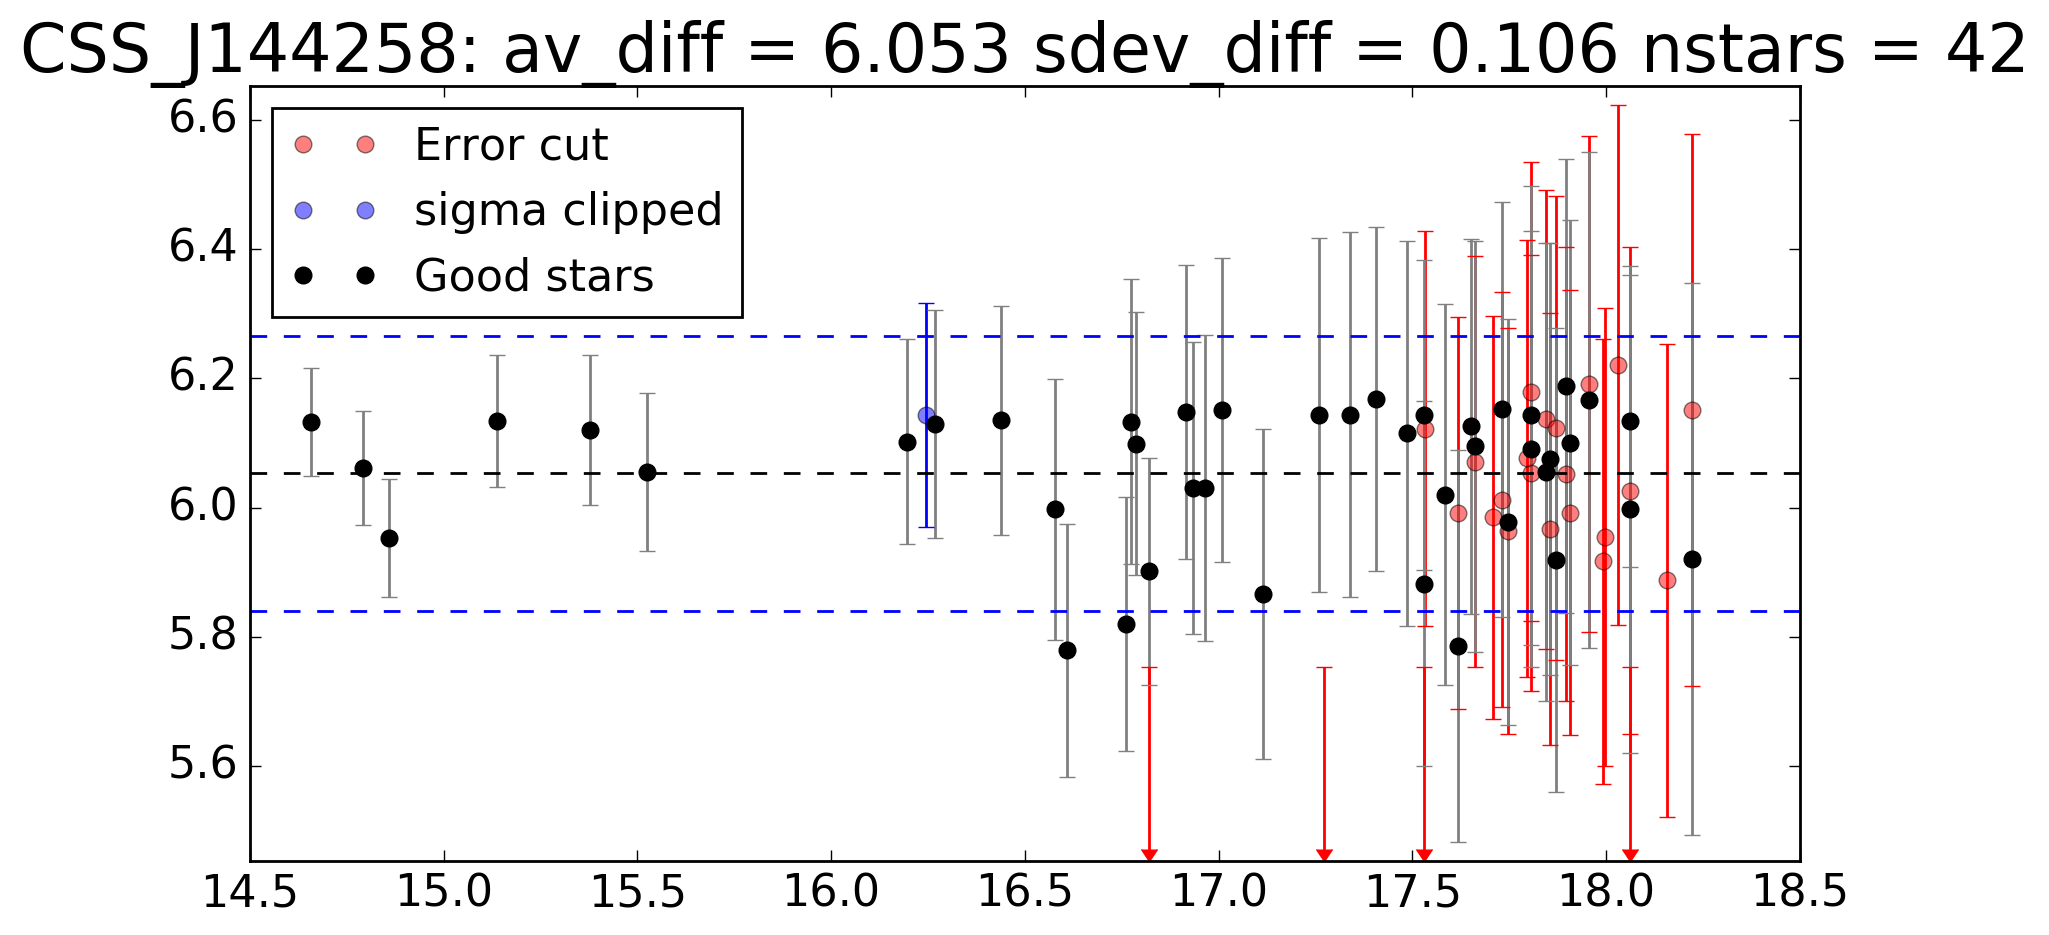

In [17]:
apcor, sdev_apcor = calculate_aperture_correction_testing.calc_apcor(flux_epoch_1, 'apcor.raw', 3, target_stem, 0.3)


Is the error cut too big here? Maybe I could decrease that to increase the number of stars that are being used because they look pretty decent. The shitty ones would be sigma clipped anyway. 

Going for 3$\sigma$ clipping, 0.3 mag error cut

In [18]:
### applying the apperture correction that was just calculated

apply_aperture_correction.apply_apcor(target_stem + '_e1_' + new_chan + '_dn.alf', apcor, num_chan)


Channel = 1


0

## This is the place where I think it was having trouble previously - calculating the offset between all the individual epochs

running daomaster
12
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J144258_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J144258_3p6um_cal.raw     H%87  0.00 0']
3


/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calibrate_all_epochs.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mask[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1] = difference_sample[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1]
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/numpy/ma/core.py:3289: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _data[indx] = dval
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/numpy/ma/core.py:3290: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _mask[indx] = mval
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[in

11
12
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e10_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e11_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e12_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e2_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e3_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e4_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e5_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e6_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e7_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e8_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e9_3p6um_dn.off
Finished offset calibration
0.00337283973 -0.148295045946
1 -0.140220907298 0.100248992365 507
2 -0.149911885246 0.0914210356558 488
3 -0.15079241517 0.0904103796522 501
4 -0.149299401198 0.104551022697 501
5 -0.145135826772 0.105521964985 508
6 -0.147414201183 0.0938054243032 507
7 -0.150298828125 0.113275704858 512
8 -0.145889546351 0.101

0

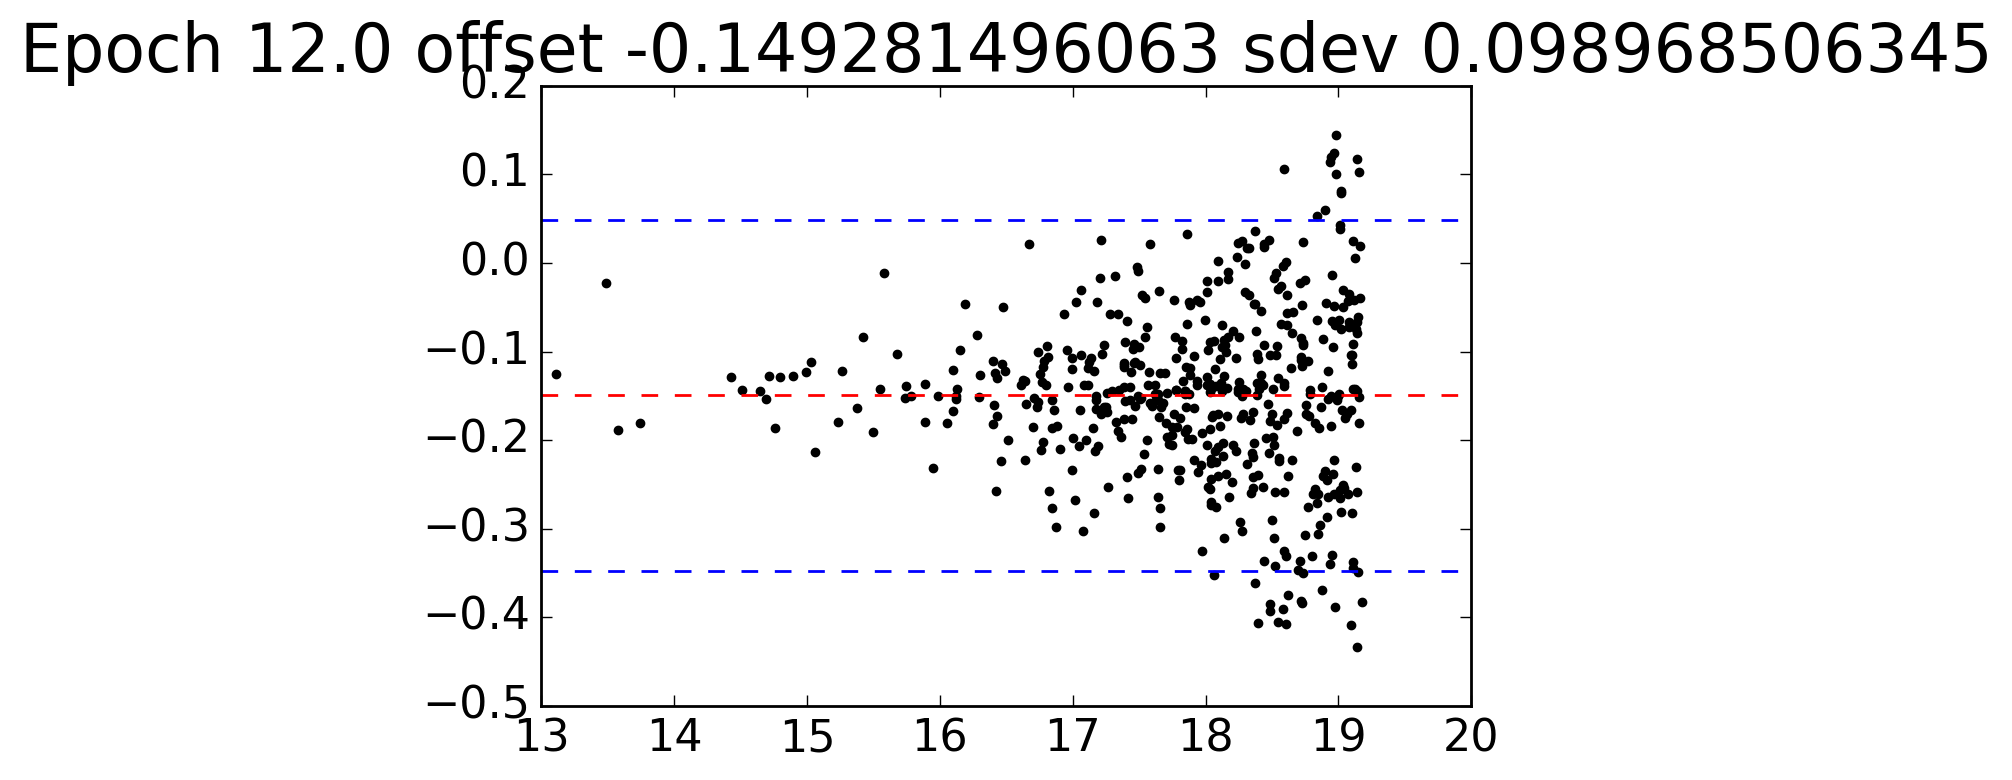

In [19]:
calibrate_all_epochs.calibrate(target_stem + '_' + new_chan + '.mch')


In [20]:
### apply the location corrections
all_location_corrections.location_corr(target_stem, new_chan)


CSS_J144258_e1_correction_3p6um.fits
CSS_J144258_e10_correction_3p6um.fits
CSS_J144258_e11_correction_3p6um.fits
CSS_J144258_e12_correction_3p6um.fits
CSS_J144258_e2_correction_3p6um.fits
CSS_J144258_e3_correction_3p6um.fits
CSS_J144258_e4_correction_3p6um.fits
CSS_J144258_e5_correction_3p6um.fits
CSS_J144258_e6_correction_3p6um.fits
CSS_J144258_e7_correction_3p6um.fits
CSS_J144258_e8_correction_3p6um.fits
CSS_J144258_e9_correction_3p6um.fits
12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J144258_3p6um_cal.mch_new V%87  0.00 0']
['CSS_J144258_3p6um.temp_cal    V%87  0.00 0']


0

# calibration should be done now, so try making a light curve

In [21]:
mch_file = target_stem + '_3p6um_cal.mch'
phot_file = target_stem + '_3p6um.cal'
mch_file = open(mch_file, 'r')
num_frames = len(glob.glob('*_dn.cal'))


file_list = []
for count in np.arange(0, num_frames):
    line = mch_file.readline()
    lines = line.split("\'")[1]
    file_list.append(lines)


times = []
num_frames = len(glob.glob('*_dn.cal'))
for name in np.arange(0, num_frames):
    fits_name = re.sub(".cal", ".fits", file_list[name])
    fits_name = re.sub(" ", "", fits_name)

    hdulist = astropy.io.fits.open(fits_name)
    prihdr = hdulist[0].header
    times.append(prihdr['date_obs'])

times = Time(times, format='isot', scale='utc')
mjds = times.mjd
print times
print mjds


['2016-05-19T07:11:16.754' '2016-05-19T15:24:46.214'
 '2016-05-19T16:19:10.171' '2016-05-19T17:17:43.132'
 '2016-05-19T08:16:02.902' '2016-05-19T09:04:58.082'
 '2016-05-19T10:00:39.429' '2016-05-19T11:03:00.788'
 '2016-05-19T11:39:38.766' '2016-05-19T12:49:12.726'
 '2016-05-19T13:43:05.487' '2016-05-19T14:32:39.644']
[ 57527.299  57527.642  57527.68   57527.721  57527.344  57527.378
  57527.417  57527.46   57527.486  57527.534  57527.572  57527.606]


In [22]:
if ((num_frames % 6 ) == 0):
    n_lines_raw = int((num_frames / 6) + 1)
else:
    n_lines_raw = int(np.ceil(num_frames) / 6 + 1)
print n_lines_raw


with open(phot_file) as input:
    lines = []
    while True:
        line = list(itertools.islice(input, n_lines_raw))
        if line:
            lines.append(line)
        else:
            break
num_stars = len(lines)


3


220d44m33.522s -9d06m16.092s


 [astropy.io.fits.verify]
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/matplotlib/backend_bases.py:2144: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if dpi == 'figure':


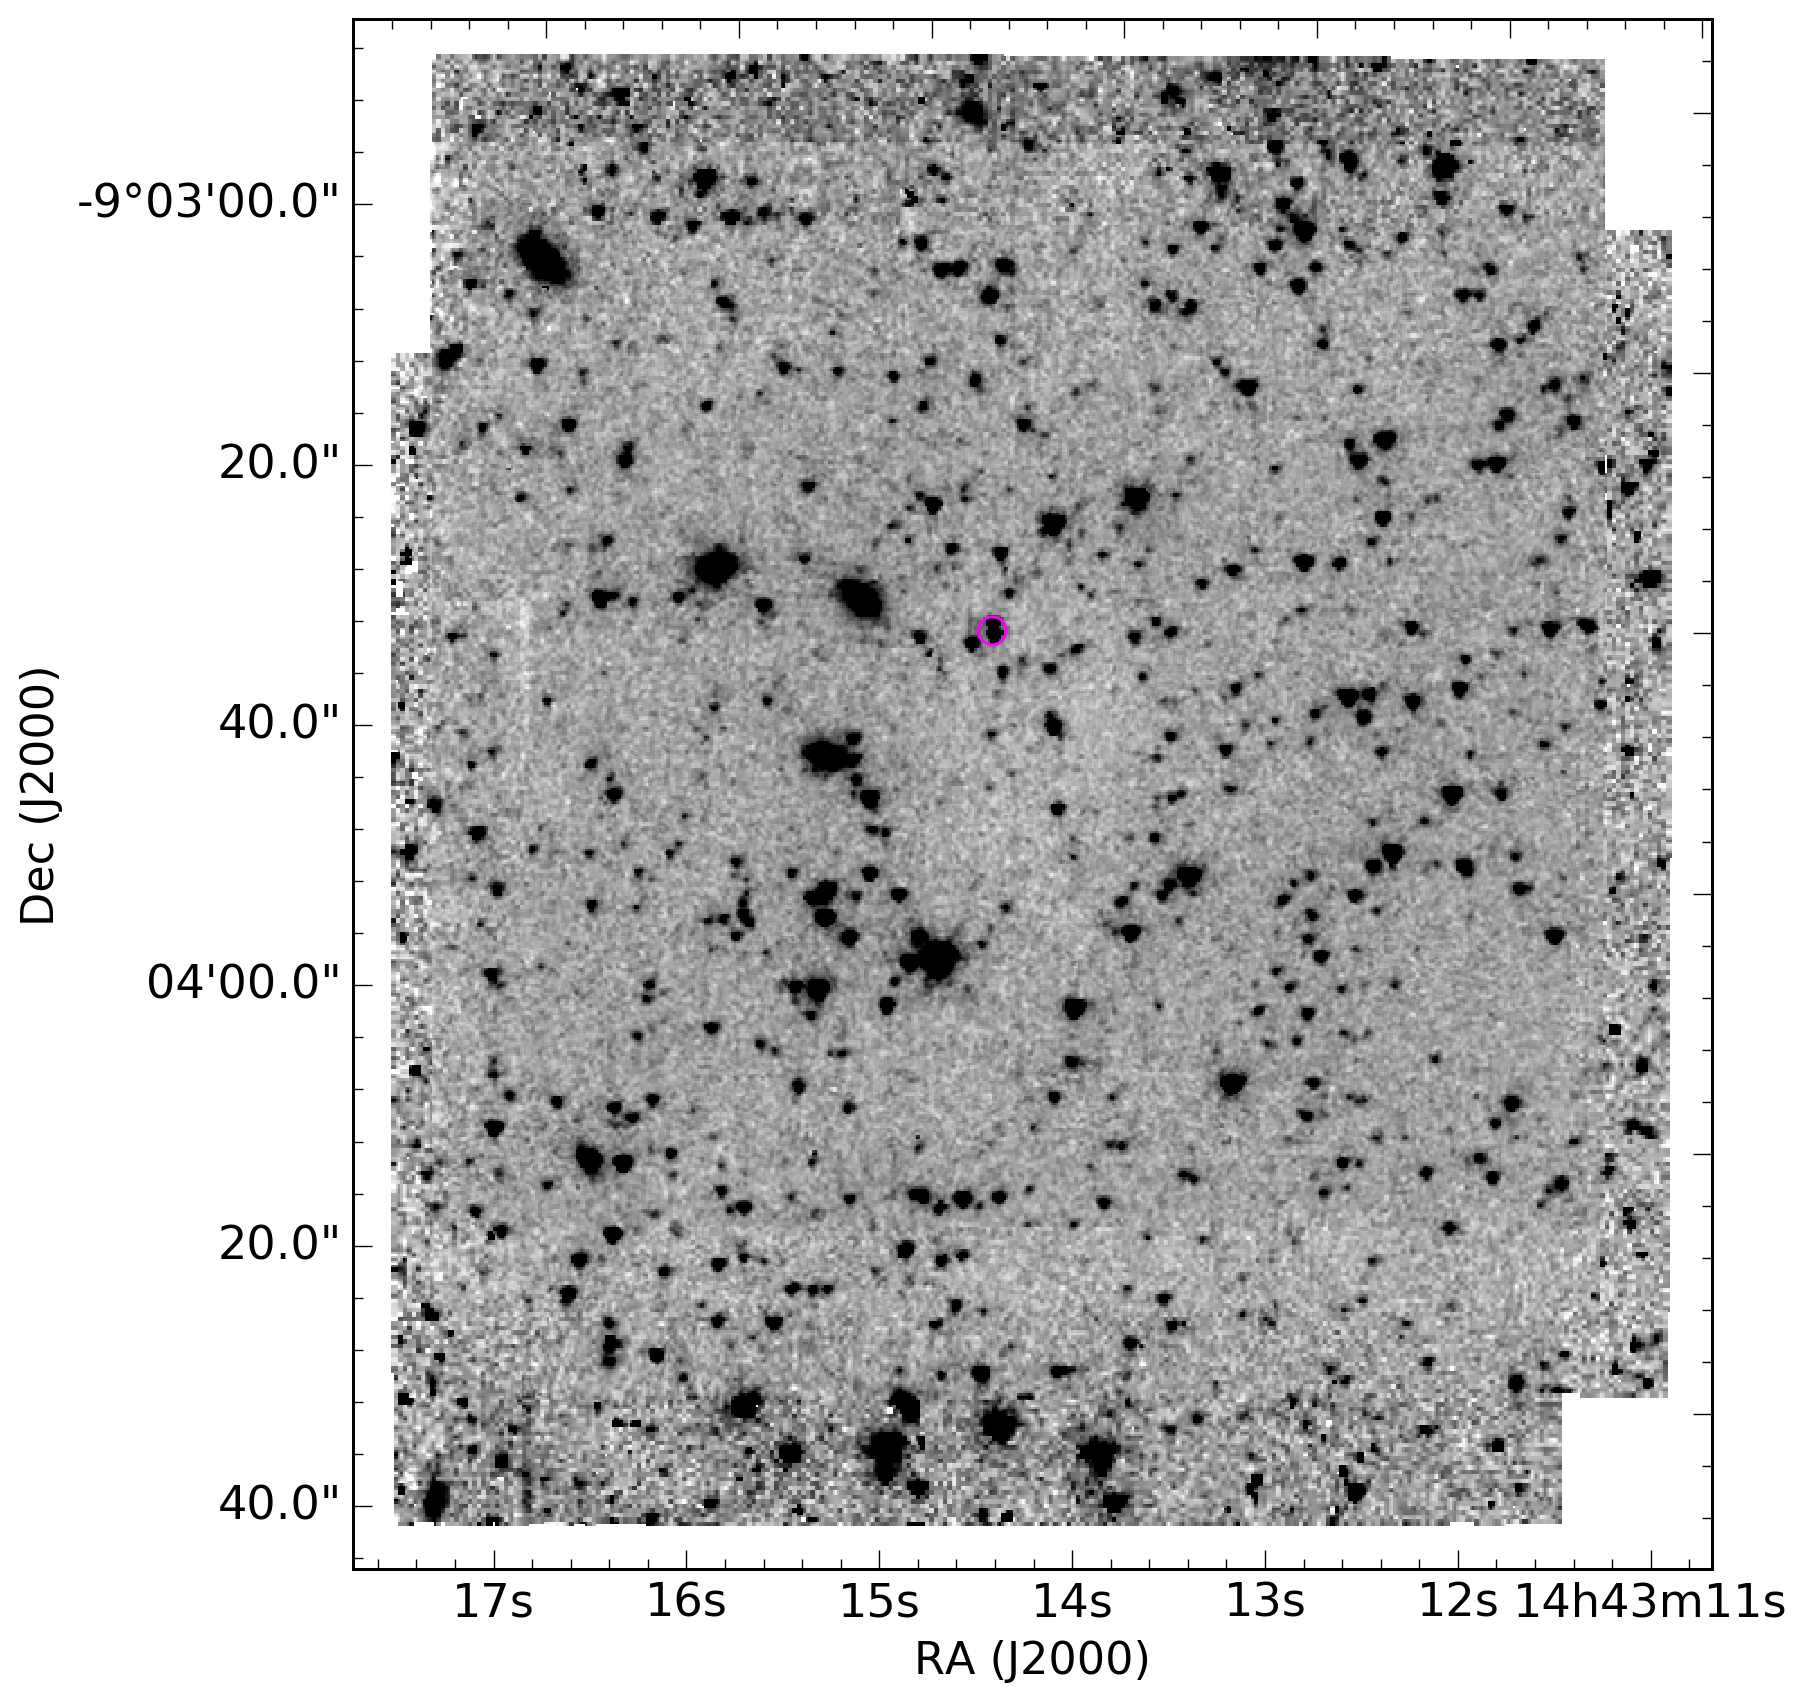

In [23]:
coords = str(target_list.ra[0]) +' ' +str(target_list.dec[0])
ra= SkyCoord(coords, unit=(u.deg, u.deg)).ra
dec = SkyCoord(coords, unit=(u.deg, u.deg)).dec
fitsfile = target_stem + '_e1_3p6um.fits'
print ra, dec


inputfile = fitsfile

fig = mp.figure(figsize=(10,10))
mosaic = aplpy.FITSFigure(inputfile, figure = fig)
mosaic.show_grayscale(vmin=0.037,vmax=0.115, invert='true') ### manually implimenting zscale
mosaic.tick_labels.set_font(size='small')
mosaic.tick_labels.set_xformat("hh:mm:ss")
mosaic.set_theme('publication')
mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='none', marker='o', s=100)
mosaic.save('testfig.pdf')

In [24]:
print inputfile

CSS_J144258_e1_3p6um.fits


In [25]:
min_distance = 10000.
rr_x, rr_y = mosaic.world2pixel(ra, dec)


objects = np.zeros((num_stars, (num_frames*2) + 3))
for star in np.arange(0,num_stars):
    data = "".join(lines[star])
    data = data.split()
    objects[star][0] = data[0] ## ID
    objects[star][1] = data[1] ## XC
    objects[star][2] = data[2] ## YC
    for epoch in np.arange(0,(num_frames*2), 2):
        objects[star][epoch + 3]  = data[epoch + 3] ## mag
        objects[star][epoch + 4] = data[epoch + 4] ## err
    distance = np.sqrt((rr_x - objects[star][1])**2 + (rr_y - objects[star][2])**2)
    if distance < min_distance:
        min_distance = distance
        best_match = objects[star][0]
        best_star = star

mag = np.zeros(num_frames)
err = np.zeros(num_frames)
for epoch in np.arange(0,num_frames):
    mag[epoch] = objects[best_star][(epoch*2) + 3]  
    err[epoch] = objects[best_star][(epoch*2) + 4] 


In [26]:
idx = np.argsort(mjds)
mjds = mjds[idx]
mag = mag[idx]
err = err[idx]


In [27]:
period = target_list.period[0]
phase = (mjds / period) - np.floor(mjds / period)
phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))


In [28]:
mag_long  = np.concatenate((mag, mag, mag, mag, mag))

err_long = np.concatenate((err, err, err, err, err))
obs = np.arange(1, num_frames+1, 1)


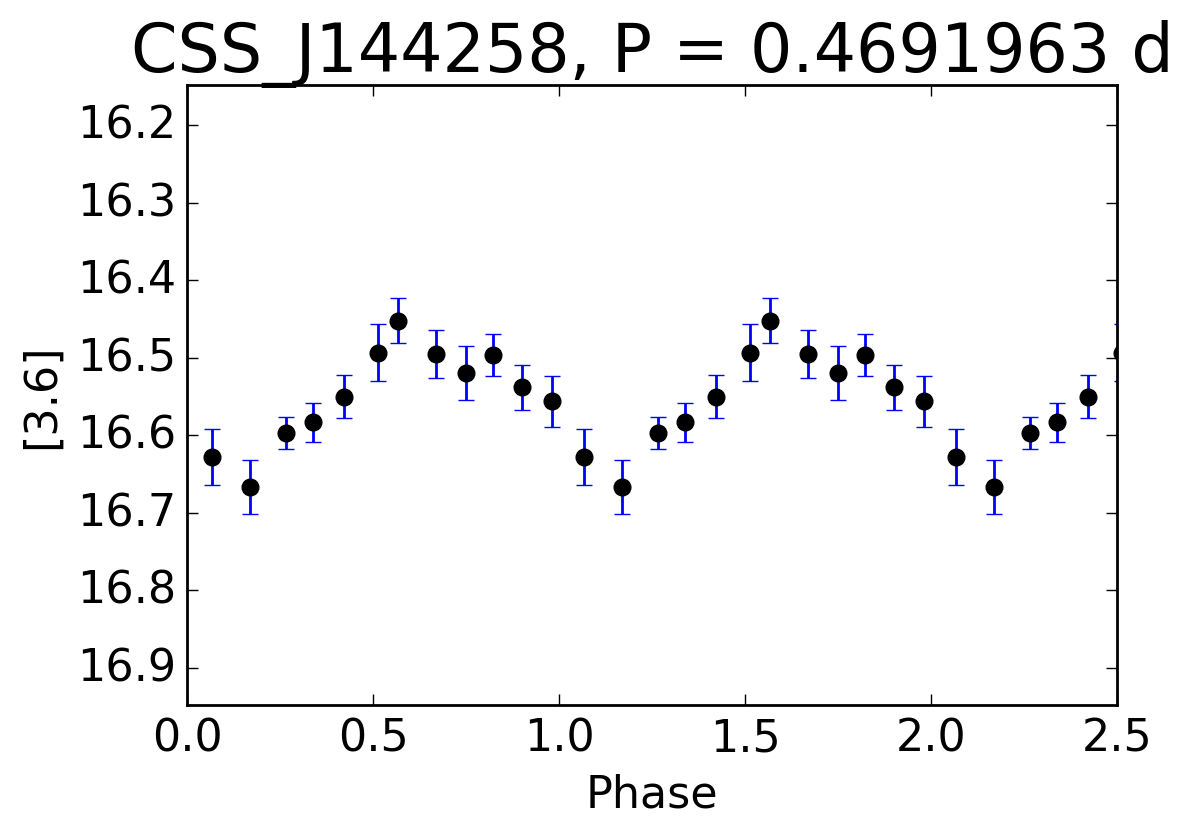

In [29]:
mp.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])
mp.errorbar(phase, mag_long, yerr=err_long, ls='None')
mp.plot(phase, mag_long, 'ko', ls='None')
mp.xlabel("Phase")
mp.ylabel('[3.6]')
mp.title(target_stem + ', P = ' + str(period) +' d')


# this looks nice. 
# What about a gloess fit? NO NOT YET DO THE OTHER ONES FIRST


# ok pipeline this shit

In [30]:
def make_rrl_finder_chart(target_stem, ra, dec):
    coords = str(ra) +' ' +str(dec)
    ra= SkyCoord(coords, unit=(u.deg, u.deg)).ra
    dec = SkyCoord(coords, unit=(u.deg, u.deg)).dec
    fitsfile = target_stem + '_e1_3p6um.fits'
    print ra, dec

    inputfile = fitsfile
    fitsdata = astropy.io.fits.open(fitsfile)[0].data
    interval = ZScaleInterval()
    zmin, zmax = interval.get_limits(fitsdata)
    
    fig = mp.figure(figsize=(10,10))
    mosaic = aplpy.FITSFigure(inputfile, figure = fig)
    mosaic.show_grayscale(vmin=zmin,vmax=zmax, invert='true') ### manually implimenting zscale
    mosaic.tick_labels.set_font(size='small')
    mosaic.tick_labels.set_xformat("hh:mm:ss")
    mosaic.set_theme('publication')
    mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='magenta', marker='o', s=100, alpha=0.3)
    mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='magenta', marker='o', s=300, alpha=0.1)
    mosaic.save(target_stem + '_location.pdf')

    

In [31]:
def find_which_star(target_stem, ra, dec):
    fitsfile = target_stem + '_e1_3p6um.fits'
    mosaic = aplpy.FITSFigure(fitsfile, figure = fig)
    rr_x, rr_y = mosaic.world2pixel(ra, dec)
    
    min_distance = 10000.
    num_frames = len(glob.glob('*_dn.cal'))
    if ((num_frames % 6 ) == 0):
        n_lines_raw = int((num_frames / 6) + 1)
    else:
        n_lines_raw = int(np.ceil(num_frames) / 6 + 1)
    print n_lines_raw
    phot_file = target_stem + '_3p6um.cal'


    with open(phot_file) as input:
        lines = []
        while True:
            line = list(itertools.islice(input, n_lines_raw))
            if line:
                lines.append(line)
            else:
                break
    num_stars = len(lines)



    objects = np.zeros((num_stars, (num_frames*2) + 3))
    for star in np.arange(0,num_stars):
        data = "".join(lines[star])
        data = data.split()
        objects[star][0] = data[0] ## ID
        objects[star][1] = data[1] ## XC
        objects[star][2] = data[2] ## YC
        for epoch in np.arange(0,(num_frames*2), 2):
            objects[star][epoch + 3]  = data[epoch + 3] ## mag
            objects[star][epoch + 4] = data[epoch + 4] ## err
        distance = np.sqrt((rr_x - objects[star][1])**2 + (rr_y - objects[star][2])**2)
        if distance < min_distance:
            min_distance = distance
            best_match = objects[star][0]
            best_star = star
    mag = np.zeros(num_frames)
    err = np.zeros(num_frames)
    for epoch in np.arange(0,num_frames):
        mag[epoch] = objects[best_star][(epoch*2) + 3]  
        err[epoch] = objects[best_star][(epoch*2) + 4] 
        
    return (mag, err)



In [32]:
def grab_mjds(mch_file):
    mch_file = open(mch_file, 'r')
    num_frames = len(glob.glob('*_dn.cal'))

    file_list = []
    for count in np.arange(0, num_frames):
        line = mch_file.readline()
        lines = line.split("\'")[1]
        file_list.append(lines)
    times = []
    num_frames = len(glob.glob('*_dn.cal'))
    for name in np.arange(0, num_frames):
        fits_name = re.sub(".cal", ".fits", file_list[name])
        fits_name = re.sub(" ", "", fits_name)

        hdulist = astropy.io.fits.open(fits_name)
        prihdr = hdulist[0].header
        times.append(prihdr['date_obs'])

    times = Time(times, format='isot', scale='utc')
    mjds = times.mjd
    return(mjds)

    

In [33]:
def plot_a_lc(target_stem, target_name, period, mjds, mag, err):
    idx = np.argsort(mjds)
    mjds = mjds[idx]
    mag = mag[idx]
    err = err[idx]

    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))

    mag_long  = np.concatenate((mag, mag, mag, mag, mag))

    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)

    mp.close()
    mp.clf()
    mp.axis([0,2.5,(np.average(mag) + 0.4),(np.average(mag) - 0.4)])
    mp.errorbar(phase, mag_long, yerr=err_long, ls='None')
    mp.plot(phase, mag_long, 'ko', ls='None')
    mp.xlabel("Phase")
    mp.ylabel('[3.6]')
    mp.title(target_name + ', P = ' + str(period) +' d')
    outplot = target_name + '_lc.pdf'
    mp.savefig(outplot)
    
    output = target_name + '_rrlyrae.data'
    output_file = open(output, "w")

    for frame in np.arange(0, num_frames):
        output_file.write("{0:.8f} {1:.3f} {2:.3f} \n".format(mjds[frame], mag[frame], err[frame]))

    output_file.close()

    

In [34]:
def calibrate_and_plot(row):
    survey_ident = row['survey_ident']
    ra = row['ra']
    dec = row['dec']
    period = row['period']
    target_name = row['target_name']

    channel = 1 ### hardwired to channel 1 here
    if (channel == 1 or channel == '3p6um' or channel == '1'): new_chan = '3p6um'
    elif (channel == 2 or channel == '4p5um' or channel == '2'): new_chan = '4p5um'
    else: 
        print 'invalid channel'
        exit(1)

    if new_chan == '3p6um': num_chan = 1
    if new_chan == '4p5um': num_chan = 2
    target_stem = sgr_setup.get_target_stem(survey_ident)
    dir_name = re.sub('\.', '_', survey_ident)
    dir_name = re.sub('-', '', dir_name)
    directory = '/Users/vs522/Dropbox/TRACCS/TRACCS_Output/' + dir_name + '/' + dir_name + '_' + new_chan
    os.chdir(directory)
    if (len(glob.glob(target_stem + '*' + new_chan +'*.alf'))==0):
        print 'You need to run ALLFRAME before you can calibrate the photometry'
        print 'This is the CALIBRATION ONLY script'
        print 'Run ``globular_pipeline_anychannel.py`` to do the combined photometry and calibration script'
        exit(1)
    flux_epoch_1 = target_stem + '_e1_' + new_chan
    aperture_correction_photometry.apcor_photo(flux_epoch_1)
    apcor, sdev_apcor = calculate_aperture_correction_testing.calc_apcor(flux_epoch_1, 'apcor.raw', 3, target_stem, 0.3)
    apply_aperture_correction.apply_apcor(target_stem + '_e1_' + new_chan + '_dn.alf', apcor, num_chan)
    calibrate_all_epochs.calibrate(target_stem + '_' + new_chan + '.mch')
    all_location_corrections.location_corr(target_stem, new_chan)
    
    
    make_rrl_finder_chart(target_stem, ra, dec)

    mch_file = target_stem + '_3p6um_cal.mch'
    phot_file = target_stem + '_3p6um.cal'


    mag, err = find_which_star(target_stem, ra, dec)
    mjds = grab_mjds(mch_file)
    
    plot_a_lc(target_stem, target_name, period, mjds, mag, err)


should have made this part of the code modular.... do it now

actually most of it already is. it's just the light curve part that isn't. fix that shit

In [35]:
top_row = target_list.head(2)

In [36]:
top_row

survey_ident    period    vmag          ra      dec target_name
0  CSS_J144258.2-090616  0.469196  17.254  220.742645 -9.10447     Pal5_03
1  CSS_J145408.5-051633  0.568599  17.398  223.535782 -5.27594     Pal5_05

2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:180: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:181: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


11
12
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e10_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e11_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e12_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e2_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e3_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e4_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e5_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e6_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e7_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e8_3p6um_dn.off
2 CSS_J144258_e12_3p6um_dn.alf CSS_J144258_e9_3p6um_dn.off
Finished offset calibration
0.00337283973 -0.148295045946
1 -0.140220907298 0.100248992365 507
2 -0.149911885246 0.0914210356558 488
3 -0.15079241517 0.0904103796522 501
4 -0.149299401198 0.104551022697 501
5 -0.145135826772 0.105521964985 508
6 -0.147414201183 0.0938054243032 507
7 -0.150298828125 0.113275704858 512
8 -0.145889546351 0.101

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J145408_e1_3p6um
at CSS_J145408_e1_3p6um

     CSS_J145408_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 54 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 54 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J145408_3p6um_cal.mch_new P%87  0.00 0']
['CSS_J145408_3p6um_cal.raw     P%87  0.00 0', 'CSS_J145408_3p6um_cal.raw     Q%87  0.00 0', 'CSS_J145408_3p6um_cal.raw     T%87  0.00 0', 'CSS_J145408_3p6um_cal.raw     V%87  0.00 0', 'CSS_J145408_3p6um_cal.raw     W%87  0.00 0']
3
11
12
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e10_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e11_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e12_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e2_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e3_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e4_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e5_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e6_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e7_3p6um_dn.off
2 CSS_J145408_e12_3p6um_dn.alf CSS_J145408_e8_3p6um_dn.off
2 CS

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J134430_e1_3p6um
at CSS_J134430_e1_3p6um

     CSS_J134430_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 86 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 86 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J134430_3p6um_cal.mch_new \\%87  0.00 0']
['CSS_J134430_3p6um_cal.raw     \\%87  0.00 0']
3
11
12
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e10_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e11_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e12_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e2_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e3_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e4_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e5_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e6_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e7_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e8_3p6um_dn.off
2 CSS_J134430_e12_3p6um_dn.alf CSS_J134430_e9_3p6um_dn.off
Finished offset calibration
0.00698120865542 -0.161745510297
1 -0.14820626151 0.106638706902 543
2 -0.168513227513 0.1237432316

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J151101_e1_3p6um
at CSS_J151101_e1_3p6um

     CSS_J151101_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J151101_3p6um_cal.mch_new \\%87  0.00 0']
['CSS_J151101_3p6um_cal.raw     \\%87  0.00 0']
3
11
12
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e10_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e11_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e12_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e2_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e3_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e4_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e5_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e6_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e7_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e8_3p6um_dn.off
2 CSS_J151101_e12_3p6um_dn.alf CSS_J151101_e9_3p6um_dn.off
Finished offset calibration
0.678637673838 0.0472227219803
1 -0.168670682731 0.112348014175 498
2 -0.16633808554 0.10355985388 

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J152902_e1_3p6um
at CSS_J152902_e1_3p6um

     CSS_J152902_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 62 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J152902_3p6um_cal.mch_new Z%87  0.00 0']
['CSS_J152902_3p6um_cal.raw     Z%87  0.00 0']
3
11
12
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e10_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e11_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e12_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e2_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e3_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e4_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e5_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e6_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e7_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e8_3p6um_dn.off
2 CSS_J152902_e12_3p6um_dn.alf CSS_J152902_e9_3p6um_dn.off
Finished offset calibration
0.00352358557776 -0.155125578923
1 -0.154435064935 0.0962531784144 616
2 -0.151435691318 0.1013134555

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J153528_e1_3p6um
at CSS_J153528_e1_3p6um

     CSS_J153528_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 59 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 59 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J153528_3p6um_cal.mch_new T%87  0.00 0']
['CSS_J153528_3p6um_cal.raw     T%87  0.00 0']
3
11
12
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e10_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e11_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e12_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e2_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e3_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e4_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e5_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e6_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e7_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e8_3p6um_dn.off
2 CSS_J153528_e12_3p6um_dn.alf CSS_J153528_e9_3p6um_dn.off
Finished offset calibration
0.00500480507714 -0.164826665191
1 -0.170044326241 0.105732717782 564
2 -0.168240614334 0.11825332235

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155355_e1_3p6um
at CSS_J155355_e1_3p6um

     CSS_J155355_e1_3p6um...                 


                                      Picture size:    695   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 87 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 87 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J155355_3p6um_cal.mch_new \\%87  0.00 0']
['CSS_J155355_3p6um_cal.raw     \\%87  0.00 0']
3
11
12
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e10_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e11_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e12_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e2_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e3_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e4_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e5_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e6_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e7_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e8_3p6um_dn.off
2 CSS_J155355_e12_3p6um_dn.alf CSS_J155355_e9_3p6um_dn.off
Finished offset calibration
0.0105195089666 1.29256604621
1 1.29917380952 0.0919254396613 420
2 1.29934382022 0.0996903339674 4

INFO: Auto-setting resolution to 98.0645 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155742_e1_3p6um
at CSS_J155742_e1_3p6um

     CSS_J155742_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J145408_e1_3p6um
at CSS_J145408_e1_3p6um

     CSS_J145408_e1_3p6um...                 


                                      Picture size:    604   

TIMEOUT: Timeout exceeded.
<pexpect.pty_spawn.spawn object at 0x12c159c90>
command: /Users/vs522/daophot/daomaster
args: ['/Users/vs522/daophot/daomaster']
buffer (last 100 chars): 's: CSS_J145408_3p6um_cal.raw     V\x87  0.00 0\x07\r\n\r\n          New output file name (default OVERWRITE): '
before (last 100 chars): 's: CSS_J145408_3p6um_cal.raw     V\x87  0.00 0\x07\r\n\r\n          New output file name (default OVERWRITE): '
after: <class 'pexpect.exceptions.TIMEOUT'>
match: None
match_index: None
exitstatus: None
flag_eof: False
pid: 79679
child_fd: 83
closed: False
timeout: 30
delimiter: <class 'pexpect.exceptions.EOF'>
logfile: None
logfile_read: None
logfile_send: None
maxread: 2000
ignorecase: False
searchwindowsize: None
delaybeforesend: 0.05
delayafterclose: 0.1
delayafterterminate: 0.1
searcher: searcher_re:
    0: re.compile("A file with the new transformations")

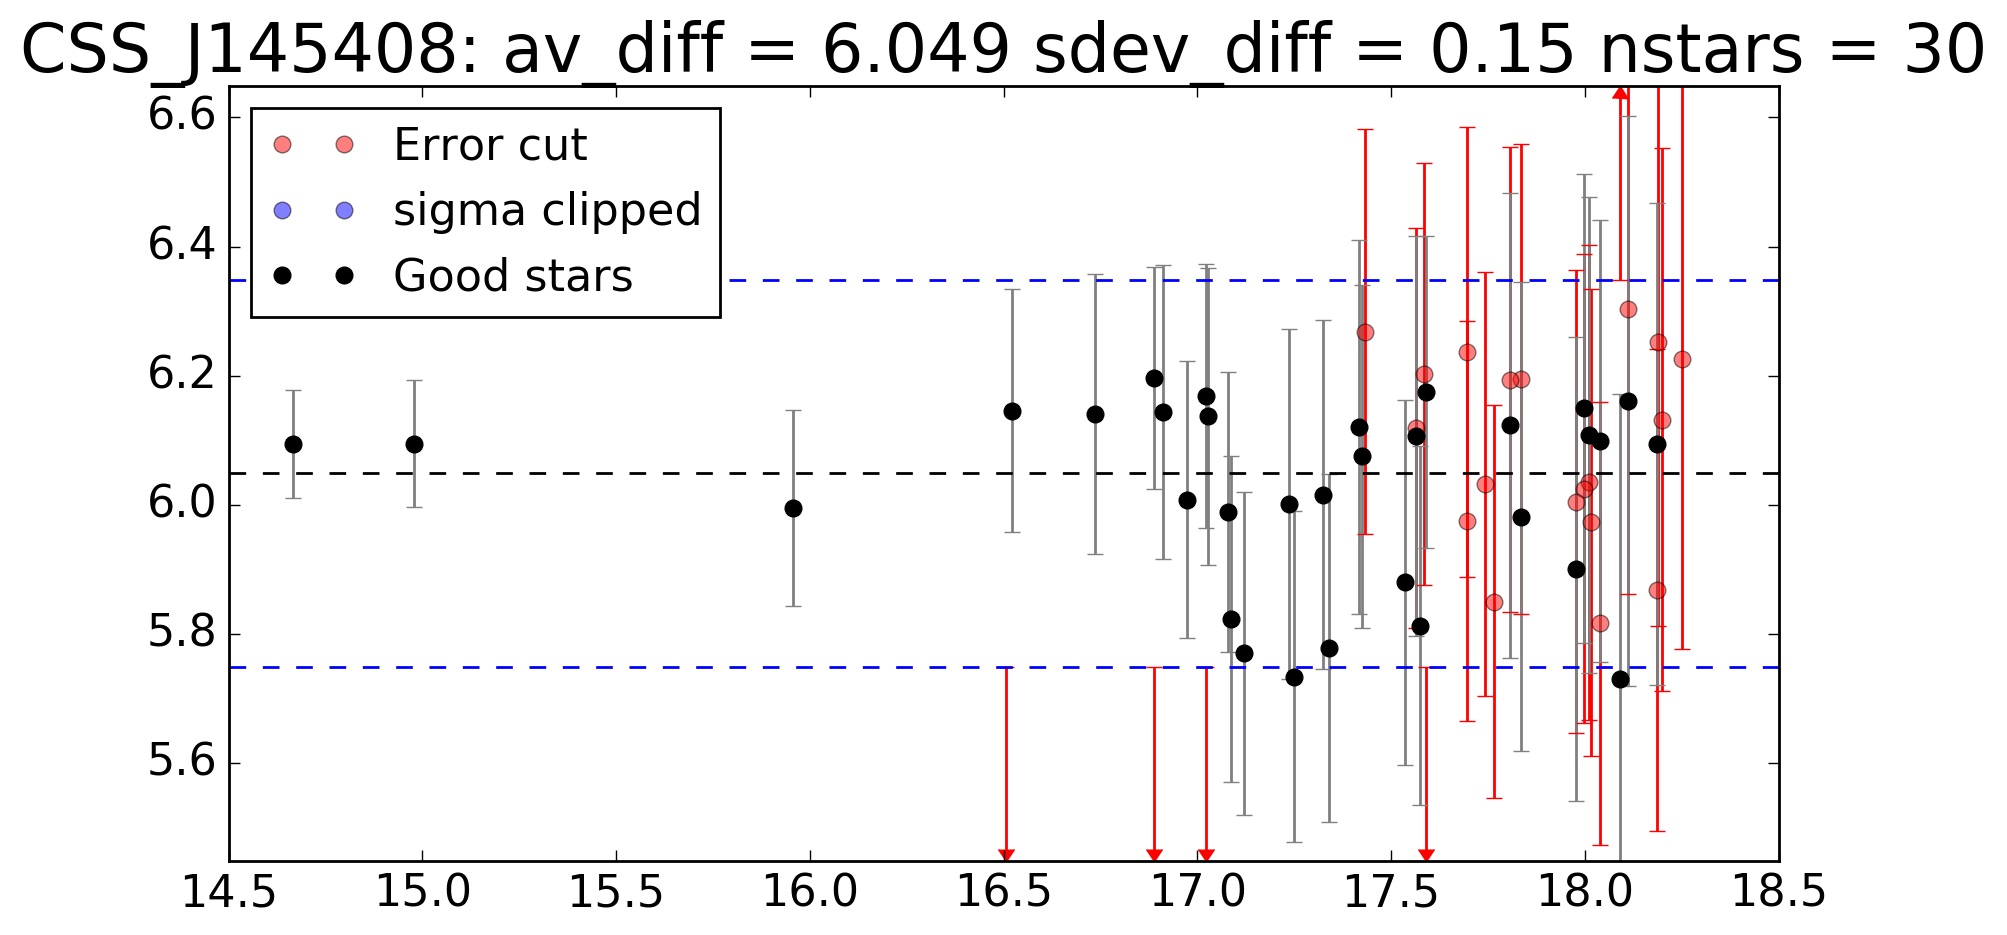

In [37]:
target_list.apply(lambda line: calibrate_and_plot(line), axis=1)

# Pipeline seems to work 
## bugs to fix
* ~~white lines on finder charts - emailed Thomas~~ Fixed - can't use seaborn with aplpy
* Some stars not actually observed - remove stars that I know weren't observed from target list
* Some fields have more than one RR Lyrae - alter target list to reflect correct names.


In [38]:
### the targets with survey_ident starting with LIN were not observed
not_observed = target_list.survey_ident.str.contains('lin', flags=re.IGNORECASE, regex=True, na=False)
target_list = target_list[~not_observed]

In [39]:
target_list
### New target list has only targets that were actually observed by TRACCS

survey_ident    period    vmag          ra        dec target_name
0   CSS_J144258.2-090616  0.469196  17.254  220.742645  -9.104470     Pal5_03
1   CSS_J145408.5-051633  0.568599  17.398  223.535782  -5.275940     Pal5_05
2   CSS_J134430.7-052047  0.542442  17.165  223.628098  -5.346430     Pal5_06
3   CSS_J151101.1-013754  0.462673  17.347  227.754669  -1.631890     Pal5_10
4   CSS_J152902.2+022431  0.520741  17.424  232.259460   2.408740     Pal5_13
5   CSS_J153528.4+033005  0.496329  17.433  233.868744   3.501560     Pal5_14
6   CSS_J155355.7+053741  0.523602  17.078  238.482330   5.628180     Pal5_17
7   CSS_J155742.7+055725  0.527256  17.497  239.428314   5.957150     Pal5_18
8              QUEST_400  0.332511  17.330  228.991542  -0.189750         400
9              QUEST_402  0.401276  17.460  229.024125  -0.186750         402
10             QUEST_403  0.551669  17.460  229.039667  -0.273056         403
11             QUEST_404  0.493070  17.380  229.053292  -0.167417         404
12             QUEST_405  0.329673  17.530  229.204500  -0.129667         405
16  CSS_J154610.7+551423  0.600936  16.444  236.544748  55.239919    15551122
17  CSS_J165319.2+485203  0.643204  15.631  253.330366  48.867444    19548146
18  CSS_J161924.5+411627  0.650577  16.902  244.852325  41.274368   Hermus_13
19  CSS_J161659.8+390748  0.537154  16.191  244.249268  39.130051   Hermus_08
20  CSS_J161039.7+332502  0.642536  17.103  242.665436  33.417480   Hermus_04

Final solvable bug -- the some of the QUEST RR Lyrae had more than one target in a field. So the directory structure doesn't match up with the survey_ident names in this table. Need to change these by hand. Then need to change the output file names so that the RR Lyrae can be identified by their TARGET names, not by the survey idents.

### Fields that had more than one star:
* QUEST 400
* QUEST 402


### Extra missing field: QUEST 405 doesn't appear to exist
* Checked SHA - no target by that name observed. Removing it from dataframe

In [40]:
target_list.ix[8, 'survey_ident'] = 'QUEST_400_402'
target_list.ix[9, 'survey_ident'] = 'QUEST_400_402'


/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [43]:
target_list

survey_ident    period    vmag          ra        dec target_name
0   CSS_J144258.2-090616  0.469196  17.254  220.742645  -9.104470     Pal5_03
1   CSS_J145408.5-051633  0.568599  17.398  223.535782  -5.275940     Pal5_05
2   CSS_J134430.7-052047  0.542442  17.165  223.628098  -5.346430     Pal5_06
3   CSS_J151101.1-013754  0.462673  17.347  227.754669  -1.631890     Pal5_10
4   CSS_J152902.2+022431  0.520741  17.424  232.259460   2.408740     Pal5_13
5   CSS_J153528.4+033005  0.496329  17.433  233.868744   3.501560     Pal5_14
6   CSS_J155355.7+053741  0.523602  17.078  238.482330   5.628180     Pal5_17
7   CSS_J155742.7+055725  0.527256  17.497  239.428314   5.957150     Pal5_18
8          QUEST_400_402  0.332511  17.330  228.991542  -0.189750   QUEST_400
9          QUEST_400_402  0.401276  17.460  229.024125  -0.186750   QUEST_402
10             QUEST_403  0.551669  17.460  229.039667  -0.273056   QUEST_403
11             QUEST_404  0.493070  17.380  229.053292  -0.167417   QUEST_404
12             QUEST_405  0.329673  17.530  229.204500  -0.129667   QUEST_405
16  CSS_J154610.7+551423  0.600936  16.444  236.544748  55.239919    15551122
17  CSS_J165319.2+485203  0.643204  15.631  253.330366  48.867444    19548146
18  CSS_J161924.5+411627  0.650577  16.902  244.852325  41.274368   Hermus_13
19  CSS_J161659.8+390748  0.537154  16.191  244.249268  39.130051   Hermus_08
20  CSS_J161039.7+332502  0.642536  17.103  242.665436  33.417480   Hermus_04

In [44]:
target_list.ix[8, 'target_name'] = 'QUEST_400'
target_list.ix[9, 'target_name'] = 'QUEST_402'
target_list.ix[10, 'target_name'] = 'QUEST_403'
target_list.ix[11, 'target_name'] = 'QUEST_404'
target_list.ix[12, 'target_name'] = 'QUEST_405'


In [45]:
not_observed = target_list.survey_ident.str.contains('QUEST_405', regex=True, na=False)
target_list = target_list[~not_observed]

In [46]:
target_list

survey_ident    period    vmag          ra        dec target_name
0   CSS_J144258.2-090616  0.469196  17.254  220.742645  -9.104470     Pal5_03
1   CSS_J145408.5-051633  0.568599  17.398  223.535782  -5.275940     Pal5_05
2   CSS_J134430.7-052047  0.542442  17.165  223.628098  -5.346430     Pal5_06
3   CSS_J151101.1-013754  0.462673  17.347  227.754669  -1.631890     Pal5_10
4   CSS_J152902.2+022431  0.520741  17.424  232.259460   2.408740     Pal5_13
5   CSS_J153528.4+033005  0.496329  17.433  233.868744   3.501560     Pal5_14
6   CSS_J155355.7+053741  0.523602  17.078  238.482330   5.628180     Pal5_17
7   CSS_J155742.7+055725  0.527256  17.497  239.428314   5.957150     Pal5_18
8          QUEST_400_402  0.332511  17.330  228.991542  -0.189750   QUEST_400
9          QUEST_400_402  0.401276  17.460  229.024125  -0.186750   QUEST_402
10             QUEST_403  0.551669  17.460  229.039667  -0.273056   QUEST_403
11             QUEST_404  0.493070  17.380  229.053292  -0.167417   QUEST_404
16  CSS_J154610.7+551423  0.600936  16.444  236.544748  55.239919    15551122
17  CSS_J165319.2+485203  0.643204  15.631  253.330366  48.867444    19548146
18  CSS_J161924.5+411627  0.650577  16.902  244.852325  41.274368   Hermus_13
19  CSS_J161659.8+390748  0.537154  16.191  244.249268  39.130051   Hermus_08
20  CSS_J161039.7+332502  0.642536  17.103  242.665436  33.417480   Hermus_04

In [47]:
top_line = target_list.head(1)

In [48]:
top_line

survey_ident    period    vmag          ra      dec target_name
0  CSS_J144258.2-090616  0.469196  17.254  220.742645 -9.10447     Pal5_03

2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J145408_e1_3p6um
at CSS_J145408_e1_3p6um

     CSS_J145408_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J145408_e1_3p6um
at CSS_J145408_e1_3p6um

     CSS_J145408_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J134430_e1_3p6um
at CSS_J134430_e1_3p6um

     CSS_J134430_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J151101_e1_3p6um
at CSS_J151101_e1_3p6um

     CSS_J151101_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J152902_e1_3p6um
at CSS_J152902_e1_3p6um

     CSS_J152902_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J153528_e1_3p6um
at CSS_J153528_e1_3p6um

     CSS_J153528_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155355_e1_3p6um
at CSS_J155355_e1_3p6um

     CSS_J155355_e1_3p6um...                 


                                      Picture size:    695   

INFO: Auto-setting resolution to 98.0645 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J155742_e1_3p6um
at CSS_J155742_e1_3p6um

     CSS_J155742_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at Q_400_402_e1_3p6um
at Q_400_402_e1_3p6um

     Q_400_402_e1_3p6um...                   


                                      Picture size:    604   689


INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at Q_400_402_e1_3p6um
at Q_400_402_e1_3p6um

     Q_400_402_e1_3p6um...                   


                                      Picture size:    604   689


INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at Q_403_e1_3p6um
at Q_403_e1_3p6um

     Q_403_e1_3p6um...                       


                                      Picture size:    604   689


 Comma

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['Q_403_3p6um_cal.mch_new       X%87  0.00 0']
['Q_403_3p6um_cal.raw           X%87  0.00 0']
3
11
12
2 Q_403_e12_3p6um_dn.alf Q_403_e10_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e11_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e12_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e2_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e3_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e4_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e5_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e6_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e7_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e8_3p6um_dn.off
2 Q_403_e12_3p6um_dn.alf Q_403_e9_3p6um_dn.off
Finished offset calibration
0.00280761518107 -0.132781483685
1 -0.131240740741 0.0901172316739 594
2 -0.126703020134 0.0992725760384 596
3 -0.13316097561 0.108374066614 615
4 -0.129397708674 0.0868847116631 611
5 -0.133991582492 0.0832994169154 594
6 -0.1373900

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at Q_404_e1_3p6um
at Q_404_e1_3p6um

     Q_404_e1_3p6um...                       


                                      Picture size:    604   689


 Comma

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J154610_e1_3p6um
at CSS_J154610_e1_3p6um

     CSS_J154610_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J154610_3p6um_cal.mch_new U%87  0.00 0']
['CSS_J154610_3p6um_cal.raw     U%87  0.00 0']
3
11
12
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e10_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e11_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e12_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e2_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e3_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e4_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e5_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e6_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e7_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e8_3p6um_dn.off
2 CSS_J154610_e12_3p6um_dn.alf CSS_J154610_e9_3p6um_dn.off
Finished offset calibration
0.00891103852539 0.762097058143
1 0.767270588235 0.113525678695 255
2 0.750811764706 0.113407731602 2

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J165319_e1_3p6um
at CSS_J165319_e1_3p6um

     CSS_J165319_e1_3p6um...                 


                                      Picture size:    604   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 67 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 67 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J165319_3p6um_cal.mch_new W%87  0.00 0']
['CSS_J165319_3p6um_cal.raw     W%87  0.00 0']
3


/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:193: RuntimeWarning: invalid value encountered in isfinite
  if np.any(~np.isfinite(data)):
/Users/vs522/anaconda3/envs/iraf27/lib/python2.7/site-packages/numpy/ma/core.py:1032: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)


11
12
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e10_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e11_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e12_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e2_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e3_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e4_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e5_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e6_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e7_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e8_3p6um_dn.off
2 CSS_J165319_e12_3p6um_dn.alf CSS_J165319_e9_3p6um_dn.off
Finished offset calibration
0.015512438041 -0.129953226868
1 -0.117898203593 0.174532176562 167
2 -0.133404761905 0.173655695137 168
3 -0.115379746835 0.129434486023 158
4 -0.147490909091 0.130579761678 165
5 -0.14152866242 0.132106045056 157
6 -0.139134146341 0.135723019795 164
7 -0.137195121951 0.141386853757 164
8 -0.119772151899 0.12792

INFO: Auto-setting resolution to 88.9032 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J161924_e1_3p6um
at CSS_J161924_e1_3p6um

     CSS_J161924_e1_3p6um...                 


                                      Picture size:    697   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 66 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 66 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J161924_3p6um_cal.mch_new H%87  0.00 0']
['CSS_J161924_3p6um_cal.raw     H%87  0.00 0']
3
11
12
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e10_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e11_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e12_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e2_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e3_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e4_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e5_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e6_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e7_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e8_3p6um_dn.off
2 CSS_J161924_e12_3p6um_dn.alf CSS_J161924_e9_3p6um_dn.off
Finished offset calibration
0.0208655499721 1.29683702477
1 1.31181794195 0.141959528571 379
2 1.24991383812 0.209148417305 383
3

INFO: Auto-setting resolution to 98.0645 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J161659_e1_3p6um
at CSS_J161659_e1_3p6um

     CSS_J161659_e1_3p6um...                 


                                      Picture size:    697   

/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:88: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 73 but corresponding boolean dimension is 50
  axp1.errorbar(alf2[alf2_sample==0], clipped2[alf2_sample==0], yerr = total_err[alf2_sample==0], color='grey', ls='none')
/Users/vs522/Dropbox/Python/smhash_code/full_photometry_pipeline/calculate_aperture_correction_testing.py:92: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 73 but corresponding boolean dimension is 50
  axp1.plot(alf2[alf2_sample==0], clipped2[alf2_sample==0], 'ko', ls='none', label='Good stars')


12, 1, 12
making output files
1
2
3
4
asked about transformations
asked about output file
asked about transfer table
['CSS_J161659_3p6um_cal.mch_new P%87  0.00 0']
['CSS_J161659_3p6um_cal.raw     P%87  0.00 0']
3
11
12
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e10_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e11_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e12_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e2_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e3_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e4_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e5_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e6_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e7_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e8_3p6um_dn.off
2 CSS_J161659_e12_3p6um_dn.alf CSS_J161659_e9_3p6um_dn.off
Finished offset calibration
0.0106657229293 0.401003307011
1 0.403559259259 0.166784875323 270
2 0.407820143885 0.162205449784 27

INFO: Auto-setting resolution to 98.0645 dpi [aplpy.core]


3
2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J161039_e1_3p6um
at CSS_J161039_e1_3p6um

     CSS_J161039_e1_3p6um...                 


                                      Picture size:    604   

INFO: Auto-setting resolution to 89.1613 dpi [aplpy.core]


3


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
16    None
17    None
18    None
19    None
20    None
dtype: object

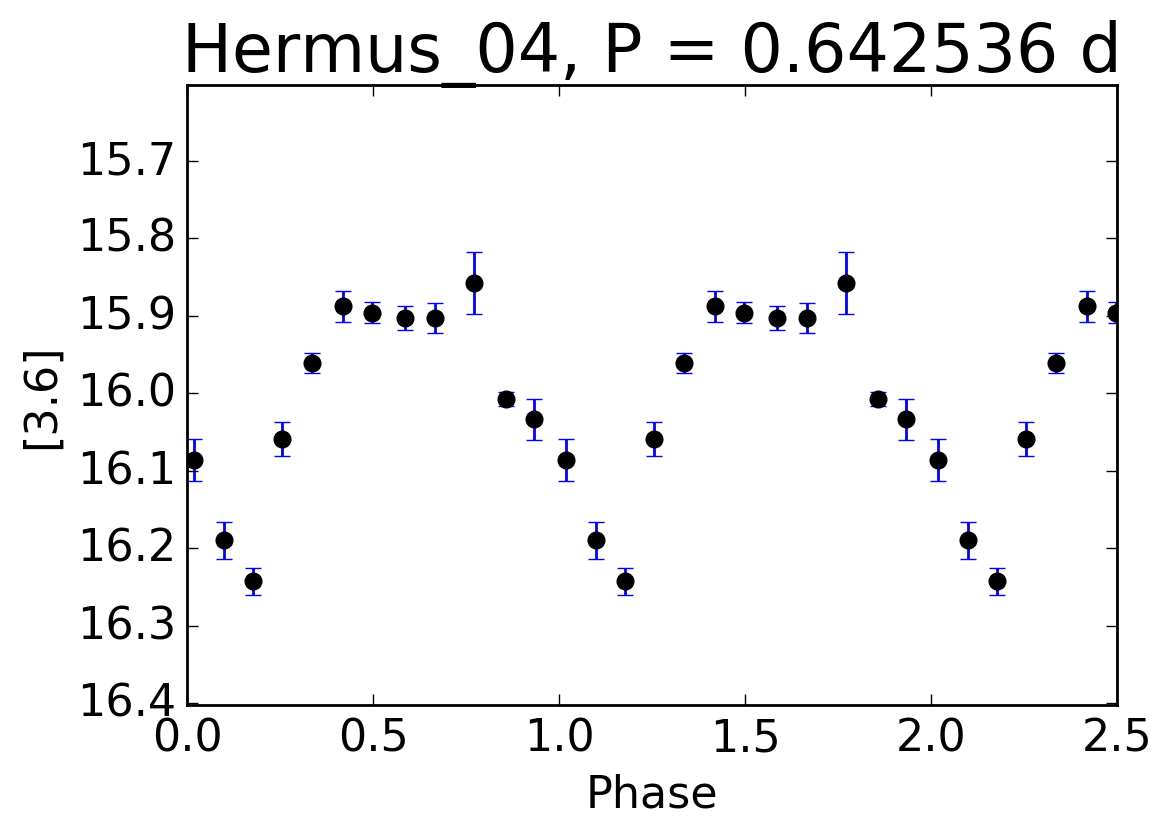

In [49]:
target_list.apply(lambda line: calibrate_and_plot(line), axis=1)

# OK! All run now. Now can start fixing the shitty offset points.

Going to go through each target in the list, visually inspect each light curve, fit a gloess curve and see if there are any problems.

In [50]:
target_list
counter = 0

In [51]:
target_list_reindexed = target_list.reset_index(drop=True)

In [52]:
## Get to the right directory:
def directory_switcher(counter):
    survey_ident = target_list_reindexed.ix[counter, 'survey_ident']
    dir_name = re.sub('\.', '_', survey_ident)
    dir_name = re.sub('-', '', dir_name)
    new_chan = '3p6um' ## hardwired to channel 1
    directory = '/Users/vs522/Dropbox/TRACCS/TRACCS_Output/' + dir_name + '/' + dir_name + '_' + new_chan
    os.chdir(directory)

    return(os.getcwd()) ### Print out the current directory at the end so I know I'm in the right place
    

In [53]:
directory_switcher(counter)

'/Users/vs522/Dropbox/TRACCS/TRACCS_Output/CSS_J144258_2090616/CSS_J144258_2090616_3p6um'

In [54]:
def plot_existing_lc(counter, phased=1, smooth=0.1):

    target_name = target_list_reindexed.ix[counter, 'target_name']
    rrl_data = target_name + '_rrlyrae.data'
    
    rrl_df = pd.read_csv(rrl_data, delim_whitespace=True, header=None, names=('mjds', 'mag', 'err'))
    
    period = target_list_reindexed.ix[counter, 'period']
    idx = np.argsort(rrl_df.mjds)
    mjds = rrl_df.mjds[idx]
    mag = rrl_df.mag[idx]
    err = rrl_df.err[idx]

    phase = (mjds / period) - np.floor(mjds / period)
    phase = np.concatenate((phase,(phase+1.0),(phase+2.0),(phase+3.0),(phase+4.0)))

    mag_long  = np.concatenate((mag, mag, mag, mag, mag))
    
    nir1 = len(mag)

    err_long = np.concatenate((err, err, err, err, err))
    obs = np.arange(1, num_frames+1, 1)
    ir11, ir1x, yir1, yeir1, xphaseir1 = gf.fit_one_band(mag_long,err_long, phase,len(mag),smooth)
    aveir1, adevir1, sdevir1, varir1, skewir1, kurtosisir1, ampir1 = gf.moment(ir11[200:300],100)
    if phased == 1:
        factor = np.sqrt(nir1)
    if phased == 0:
        factor = 1
    sdevir1 = sdevir1/factor

    target_name_display = re.sub('_', ' ', target_name)

    mp.close()
    mp.clf()
    mp.axis([1,3.5,(np.average(mag) + 0.3),(np.average(mag) - 0.3)])
    mp.plot(ir1x,ir11,'k-')
    mp.errorbar(phase, mag_long, yerr=err_long, ls='None', zorder=4)
    mp.plot(phase, mag_long, 'ro',  ls='None', zorder=4)
    mp.axhline(aveir1, color='k',ls='--')
    mp.xlabel("Phase")
    mp.ylabel('[3.6]')
    mp.title(target_name_display + ', P = ' + str(np.around(period, decimals=4)) +' d, [3.6] = ' + str(np.around(aveir1, decimals=3)) + ' $\pm$ ' + str(np.around(sdevir1, decimals=3)) + ' mag')
    mp.show()
    mp.savefig(target_name + '_gloess.pdf')



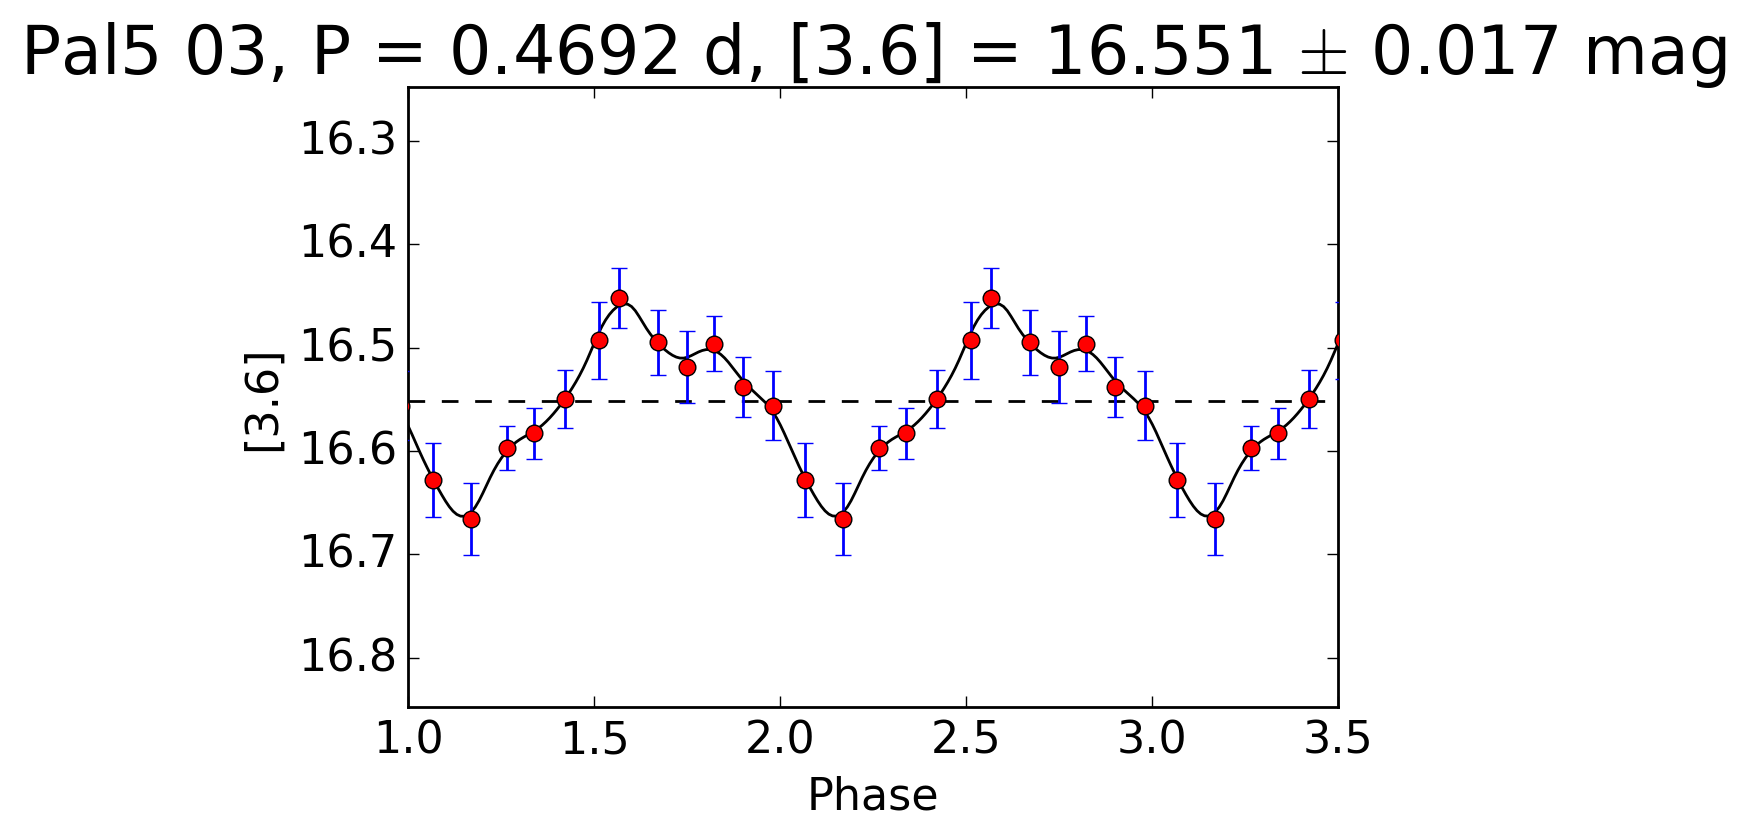

In [55]:
plot_existing_lc(0, 1, 1.5/12.)

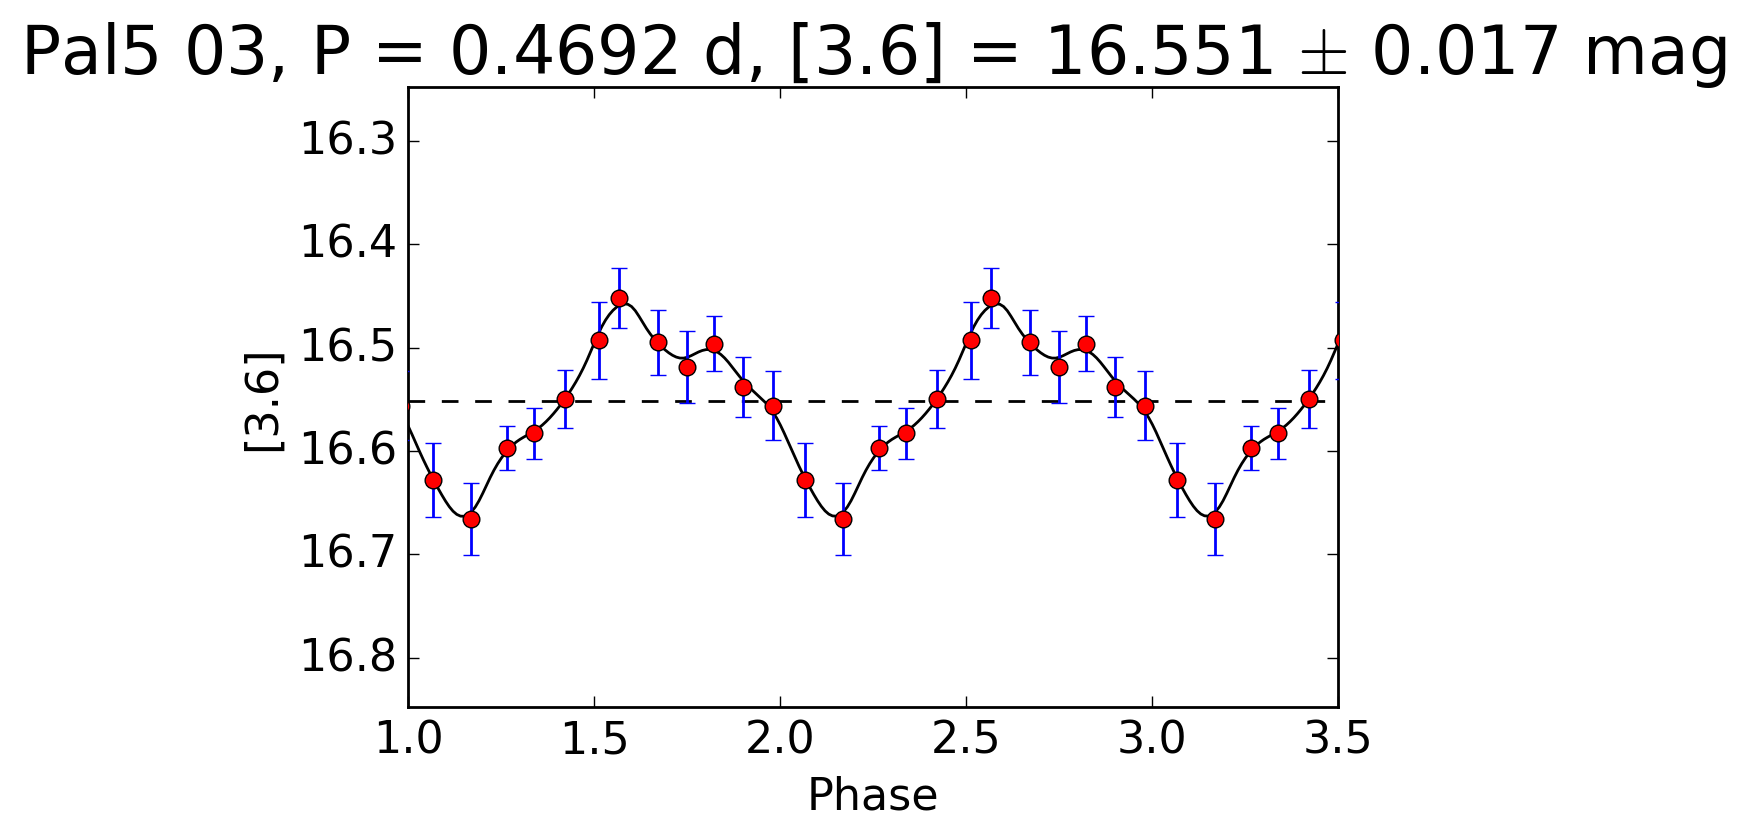

In [86]:
counter = 0
directory_switcher(counter)
plot_existing_lc(counter, 1, 1.5/12.)

In [87]:
offsets_df = pd.read_csv('CSS_J145408_3p6um_cal.off_log', delim_whitespace=True, header=None, names=('obs', 'offset', 'sdev', 'nstars'))

IOError: File CSS_J145408_3p6um_cal.off_log does not exist

In [89]:
offsets_df.offset.mean()

-0.165

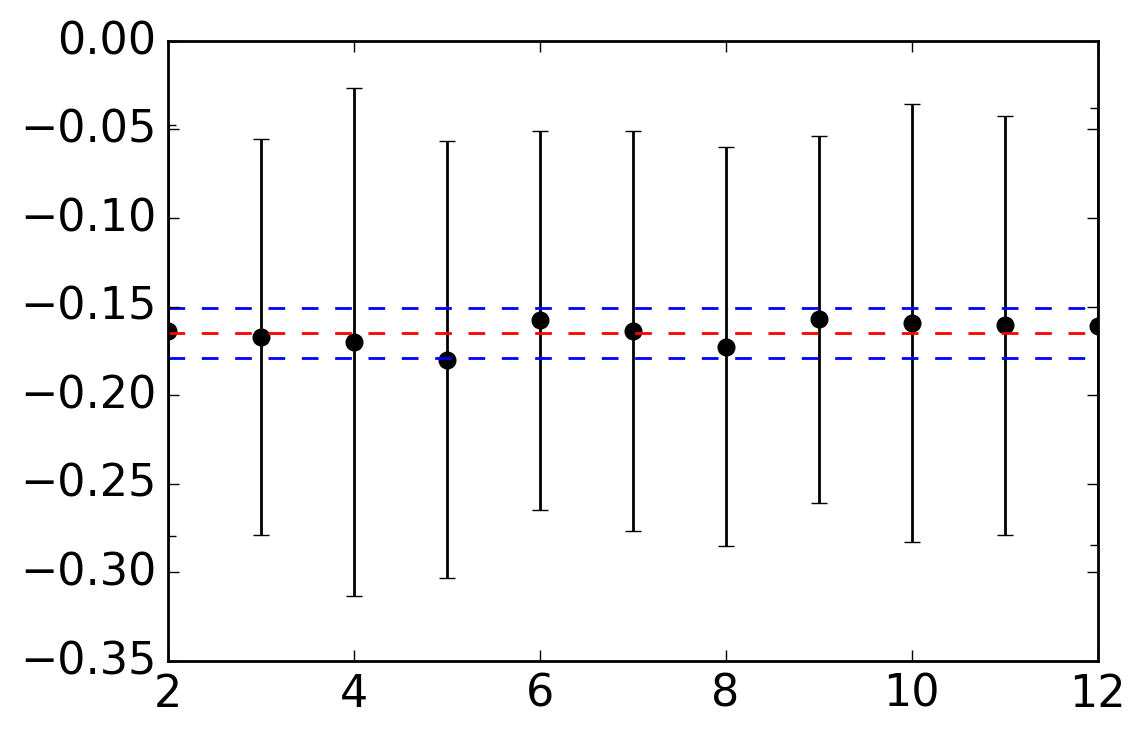

In [90]:
mp.close()
mp.clf()
mp.errorbar(offsets_df.obs, offsets_df.offset, yerr=offsets_df.sdev, color='k', ls='none')
mp.plot(offsets_df.obs, offsets_df.offset, 'ko', ls='none')
mp.axhline(offsets_df.offset.mean(), color='r', ls='--')
mp.axhline(offsets_df.offset.mean()+ 2*offsets_df.offset.std(), color='b', ls='--')
mp.axhline(offsets_df.offset.mean()- 2*offsets_df.offset.std(), color='b', ls='--')



This star is an example of poor multi-epoch calibration.

In [91]:
def multi_epoch_calibration(counter):
    survey_ident = target_list.ix[counter, 'survey_ident']
    target_stem = sgr_setup.get_target_stem(survey_ident)
    calibrate_tester(target_stem + '_3p6um.mch')


In [92]:
directory_switcher(1)
multi_epoch_calibration(1)


running daomaster
12
12, 1, 12
making output files
1
2
3
4


TIMEOUT: Timeout exceeded.
<pexpect.pty_spawn.spawn object at 0x148dc5a10>
command: /Users/vs522/daophot/daomaster
args: ['/Users/vs522/daophot/daomaster']
buffer (last 100 chars): 's: CSS_J145408_3p6um_cal.raw     H\x87  0.00 0\x07\r\n\r\n          New output file name (default OVERWRITE): '
before (last 100 chars): 's: CSS_J145408_3p6um_cal.raw     H\x87  0.00 0\x07\r\n\r\n          New output file name (default OVERWRITE): '
after: <class 'pexpect.exceptions.TIMEOUT'>
match: None
match_index: None
exitstatus: None
flag_eof: False
pid: 82539
child_fd: 83
closed: False
timeout: 30
delimiter: <class 'pexpect.exceptions.EOF'>
logfile: None
logfile_read: None
logfile_send: None
maxread: 2000
ignorecase: False
searchwindowsize: None
delaybeforesend: 0.05
delayafterclose: 0.1
delayafterterminate: 0.1
searcher: searcher_re:
    0: re.compile("A file with the new transformations")

In [60]:
def calibrate_tester(input):



## Grab the input mch file
## First line should be the calibrated epoch 1 data
## Rest should be the alf files
## First file should have the .apc extension
## All others should have .alf

	input_mch = input
	output_mch = re.sub('.mch', '_cal.mch', input)
	output = open(output_mch, 'w')
	
	for line in open(input_mch, 'r'):
		is_epoch1 = re.search('_e1_', line)
		if (is_epoch1 != None):
			splitline = line.split()
			name = splitline[0]
			new_name = name.split(".")[0]+ '.apcor'
			output.write( "{0:s} ' {1:10s} {2:10s} {3:10s} {4:10s} {5:10s} {6:10s} {7:10s} {8:10s} \n".format(new_name, splitline[2], splitline[3], splitline[4], splitline[5], splitline[6], splitline[7], splitline[8], splitline[9]))
		else:
			splitline = line.split()
			name = splitline[0]
			new_name = name.split(".")[0] + '.alf'
			output.write( "{0:s} ' {1:10s} {2:10s} {3:10s} {4:10s} {5:10s} {6:10s} {7:10s} {8:10s} \n".format(new_name, splitline[2], splitline[3], splitline[4], splitline[5], splitline[6], splitline[7], splitline[8], splitline[9]))
		
	output.close()
	
	file_list = glob.glob('*.alf')

	target = re.sub(".mch","", output_mch)
	if (os.path.isfile(target + '_cal.raw')): os.remove(target + '_cal.raw')
	print "running daomaster"
	num_frames = len(file_list)
	print num_frames

	daomaster = pexpect.spawn("daomaster")
	daomaster.expect("File with list of input files")
	daomaster.sendline(output_mch)
	daomaster.expect("Minimum number, minimum fraction, enough frames")
	daomaster.sendline(str(num_frames) + ", 1, " + str(num_frames))
	print str(num_frames) + ", 1, " + str(num_frames)
	daomaster.expect("Maximum sigma")
	daomaster.sendline("99")
	## desired degrees of freedom:
	daomaster.expect("Your choice")
	daomaster.sendline("6")
	daomaster.expect("Critical match-up radius")
	daomaster.sendline("10")

	for radius in range (10,-1, -1):
		daomaster.expect("New match-up radius")
		daomaster.sendline(str(radius))

## Only need the transformations here
	print "making output files"
	daomaster.expect("Assign new star IDs")
	print '1'
	daomaster.sendline("y")
	daomaster.expect("A file with mean magnitudes and scatter")
	print '2'
	daomaster.sendline("n")
	daomaster.expect("A file with corrected magnitudes and errors")
	print '3'
	daomaster.sendline("n")
	daomaster.expect("A file with raw magnitudes and errors")
	print '4'
	daomaster.sendline("y")
	daomaster.expect("Output file name")
	daomaster.sendline(target + ".raw")

	daomaster.expect("A file with the new transformations")
	daomaster.sendline("y")
	print "asked about transformations"
	daomaster.expect("Output file name")
	daomaster.sendline(output_mch + "_new")
	print "asked about output file"
	daomaster.expect("A file with the transfer table")
	daomaster.sendline("n")
	print "asked about transfer table"
	daomaster.expect("Individual .COO files")
	daomaster.sendline("n")

	for alf in file_list:
		mtr = re.sub(".alf", ".mtr",alf)
		old_mtr = glob.glob(mtr +'*')
		if len(old_mtr) > 0:
			old_mtr = glob.glob(mtr +'*')[0]
			if (os.path.isfile(old_mtr)): os.remove(old_mtr)



	daomaster.expect("Simply transfer star IDs")
	daomaster.sendline("y")

	daomaster.expect("Good bye")
	daomaster.close(force=True)

## Fixing the bad output file name
	new_mch  = glob.glob('*.mch_new*')
	print new_mch
	shutil.move( str(new_mch[0]), output_mch)

	new_raw = glob.glob(target +'.raw*')
	print new_raw
	shutil.move( str(new_raw[0]), target + '.raw')

	for alf in file_list:
		mtr = re.sub(".alf", ".mtr",alf)
		new_mtr = glob.glob(mtr +'*')[0]
		shutil.move(new_mtr, mtr)
	
	if ((num_frames % 6 ) == 0):
		n_lines_raw = int((num_frames / 6) + 1)
	else:
		n_lines_raw = int(np.ceil(num_frames) / 6 + 1)
	print n_lines_raw


## Example of how to read in a variable length multi line file!!!
	with open(target + '.raw') as raw_file:
		lines = []
		## skip the 3 header lines
		for count in np.arange(0,3): raw_file.readline()
		while True:
			line = list(itertools.islice(raw_file, n_lines_raw))
			if line:
				lines.append(line)
			else:
				break
		#print lines
		
	num_stars = len(lines)

## Read all relavent data into a numpy array

	objects = np.zeros((num_stars, (num_frames*2) + 3))
	for star in np.arange(0,num_stars):
		data = "".join(lines[star])
		data = data.split()
		objects[star][0] = data[0] ## ID
		objects[star][1] = data[1] ## XC
		objects[star][2] = data[2] ## YC
		for epoch in np.arange(0,(num_frames*2), 2):
			objects[star][epoch + 3]  = data[epoch + 3] ## mag
			objects[star][epoch + 4] = data[epoch + 4] ## err
			 
	epoch1 = objects[:,3]
	epoch1_err = objects[:,4]
	sorted_epoch1 = np.argsort(epoch1)

	object_sample = np.zeros(num_stars)
	epoch1_sample = np.zeros(num_stars)
	difference_sample = np.zeros(num_stars)
	
	epoch1_sample = epoch1[sorted_epoch1]
	object_sample = objects[ : , epoch + 3][sorted_epoch1]

	offsets = np.zeros(num_frames)
	sdev_offsets = np.zeros(num_frames)
	howmany_stars = np.zeros(num_frames)
	offsets_log = re.sub('.mch', '.off_log', output_mch)
	offsets_log_file = open(offsets_log, 'w')

		 
	for epoch in np.arange(2, (num_frames*2), 2, dtype=np.int): ## starting from 1 because don't match epoch 1 to itself
		object_sample = objects[ : , epoch + 3][sorted_epoch1]
		difference_sample = epoch1_sample - object_sample
		mask = np.ma.masked_all(num_stars)
		
		#difference = epoch1 - objects[ : , epoch + 3]
		#ediff = np.sqrt(epoch1_err**2 + objects[ : , epoch + 4]**2)
		#clipped = sigma_clip(difference, sigma = 3., iters=None)

		for mag_bin in np.arange(0,11):
			mask[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1] = difference_sample[(mag_bin)*num_stars*0.1:(mag_bin+1)*num_stars*0.1] 
    ## Sigma clip the sample
			clipped3 = sigma_clip(mask, sigma = 2.5, iters=None, cenfunc=np.ma.mean)
    ## Copy the sigma clipped sample to the masked array
			mask = clipped3
    
		clipped50 = sigma_clip(mask[:num_stars*0.5], sigma = 3., iters=None, cenfunc=np.ma.mean)
		av_diff50 = np.ma.mean(clipped50)
		sdev_diff50 = np.ma.mean(clipped50)

		av_diff = np.ma.mean(clipped50)
		sdev_diff = np.ma.std(clipped50)
		howmany_stars[(epoch/2.)] = clipped50.count()
		offsets[(epoch/2.)] = av_diff
		sdev_offsets[(epoch/2.)] = sdev_diff

	
		#print "Epoch " + str((epoch/2.)+1) + " offset " +str(av_diff) + " sdev " + str(sdev_diff)
		mp.close('all')		
		axp1 = mp.subplot(111)
		#axp1.errorbar(epoch1, clipped, yerr = ediff, color='grey', ls='none')
		axp1.plot(epoch1_sample[:num_stars*0.5], clipped50, 'k.', ls='none')	
		axp1.axhline(av_diff, color='r', ls='--')
		axp1.axhline(av_diff+2*sdev_diff, color='b', ls='--')
		axp1.axhline(av_diff-2*sdev_diff, color='b', ls='--')
		mp.title("Epoch " + str((epoch/2.)+1) + " offset " +str(av_diff) + " sdev " + str(sdev_diff))
		
		#mp.show()
		mp.savefig(target  + str(int((epoch/2.)+1)) + '.pdf')
## Read the file names from the mch file to make sure the order matches up with the order in the raw file

	names = []
	for line in open(output_mch, 'r'):
		splitline = line.split()
		is_epoch1 = re.search('_e1_', splitline[0])
		## Do not apply an offset for epoch 1 
		## So don't append it to the list of files to work on
		if (is_epoch1==None):
			names.append(splitline[0].split("\'")[1])
	print len(names)
	print len(offsets)
	epoch_count = 1	
	for count in np.arange(0, len(names)):
		mtr_name = re.sub(".alf", ".mtr", str(names[count]))
		off_name = re.sub(".alf", ".off", str(names[count]))
		
		input_mtr = open(mtr_name, "r")
		output_mtr = open(off_name, "w")
		for count in np.arange(0,3): 
			header = input_mtr.readline()
			output_mtr.write(header)
		input_mtr.close()
		output_mtr.close()
		#print mtr_name, off_name
		id, xc, yc, mag, err = np.loadtxt(mtr_name, skiprows=3, usecols=(0, 1, 2, 3, 4), unpack='TRUE')
		newmag = mag + offsets[epoch_count]
		np.savetxt(off_name, np.column_stack((id, xc, yc, newmag, err)), fmt= "%d %.2f %.2f %.3f %.3f")				
		print count, names[count], off_name
		epoch_count = epoch_count + 1
	
	print "Finished offset calibration"
	
	std_of_offs = np.ma.std(offsets[1:])
	mean_of_offs = np.ma.mean(offsets[1:])
	print std_of_offs, mean_of_offs
	
	### Now write an updated mch file with the correct file names
	
	final_mch = open('tempmch', 'w')
	
	for frame in np.arange(1,num_frames):
		offsets_log_file.write("{0:d} {1:8.4f} {2:8.4f} {3:d} \n".format(int(frame+1), offsets[frame], sdev_offsets[frame], int(howmany_stars[frame])))
		if ((abs(offsets[frame] - mean_of_offs) > 2*std_of_offs) and (frame!= 0)):
			print 'OUTLIER:',  int(frame), offsets[frame+1], sdev_offsets[frame+1], int(howmany_stars[frame+1])
		else: print int(frame), offsets[frame], sdev_offsets[frame], int(howmany_stars[frame])
		
		
	offsets_log_file.close()
	
	for line in open(output_mch, 'r'):
		is_epoch1 = re.search('_e1_', line)
		if (is_epoch1 != None):
			final_mch.write( "{0:s}".format(line))
		else:
			splitline = line.split()
			name = splitline[0]
			new_name = name.split(".")[0] + '.off'
			final_mch.write( " {0:s} ' {1:10s} {2:10s} {3:10s} {4:10s} {5:10s} {6:10s} {7:10s} {8:10s} \n".format(new_name, splitline[2], splitline[3], splitline[4], splitline[5], splitline[6], splitline[7], splitline[8], splitline[9]))
		
	final_mch.close()
	
	shutil.move('tempmch', output_mch)
	
	return(0)


In [57]:
def robust_offset_calculator(counter):
    

    file_list = glob.glob('*.alf')
    num_frames = len(file_list)
    ### Reading in the daomaster raw file here
    if ((num_frames % 6 ) == 0):
        n_lines_raw = num_frames / 6.0 + 1.0
    else:
        n_lines_raw = np.ceil(num_frames) / 6.0
    with open(target_stem + '_3p6um_cal.raw') as raw_file:
        lines = []
    ## skip the 3 header lines
        for count in np.arange(0,3): raw_file.readline()
        while True:
            line = list(itertools.islice(raw_file, n_lines_raw))
            if line:
                lines.append(line)
            else:
                break
    num_stars = len(lines)

    objects = np.zeros((num_stars, (num_frames*2) + 3))
    for star in np.arange(0,num_stars):
        data = "".join(lines[star])
        data = data.split()
        objects[star][0] = data[0] ## ID
        objects[star][1] = data[1] ## XC
        objects[star][2] = data[2] ## YC
        for epoch in np.arange(0,(num_frames*2), 2):
            objects[star][epoch + 3]  = data[epoch + 3] ## mag
            objects[star][epoch + 4] = data[epoch + 4] ## err
 
    epoch1 = objects[:,3]
    epoch1_err = objects[:,4]
    min_epoch1 = min(epoch1)

    offsets = np.zeros(num_frames)
    sdev_offsets = np.zeros(num_frames)


    for epoch in np.arange(2, (num_frames*2), 2): ## starting from 1 because don't match epoch 1 to itself
        difference = epoch1 - objects[ : , epoch + 3]
        ediff = np.sqrt(epoch1_err**2 + objects[ : , epoch + 4]**2)
        clipped = sigma_clip(difference, sig = 4., iters=100)

        av_diff = np.ma.mean(clipped)
        sdev_diff = np.ma.std(clipped)
        offsets[(epoch/2.)] = av_diff
        sdev_offsets[(epoch/2.)] = sdev_diff


        print "Epoch " + str((epoch/2.)+1) + " offset " +str(av_diff) + " sdev " + str(sdev_diff)
        mp.close('all')	
        axp1 = mp.subplot(111)
        mp.axis([min_epoch1, min_epoch1+8, -1, 1])
        axp1.errorbar(epoch1, clipped, yerr = ediff, color='grey', ls='none')
        axp1.plot(epoch1, clipped, 'k.', ls='none')	
        axp1.axhline(av_diff, color='r', ls='--')
        axp1.axhline(av_diff+2*sdev_diff, color='b', ls='--')
        axp1.axhline(av_diff-2*sdev_diff, color='b', ls='--')

        mp.show()


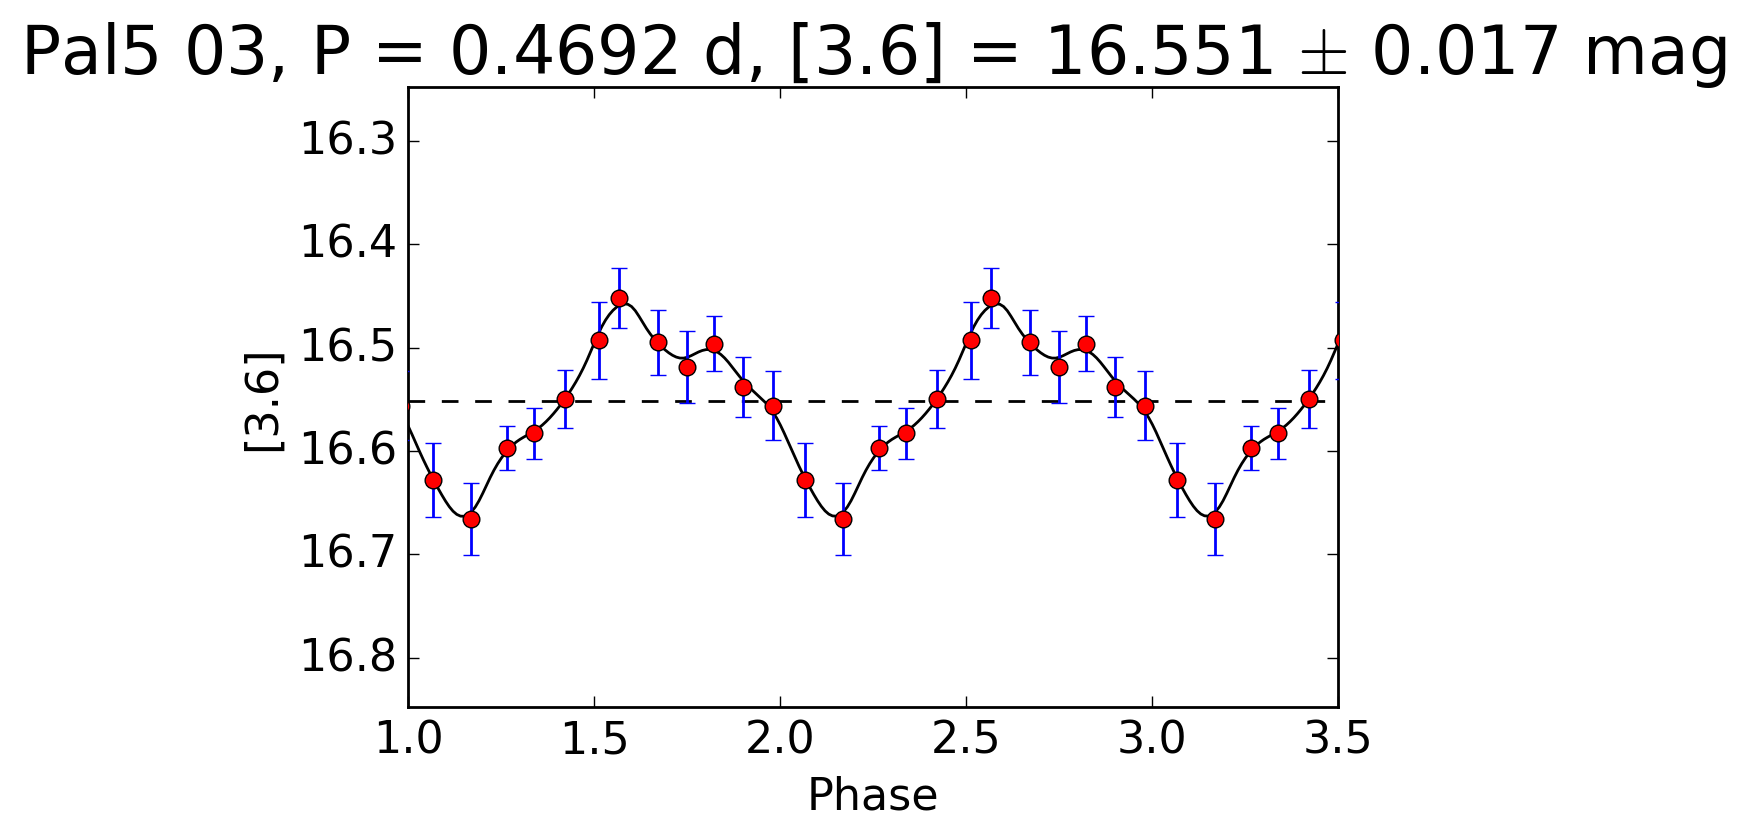

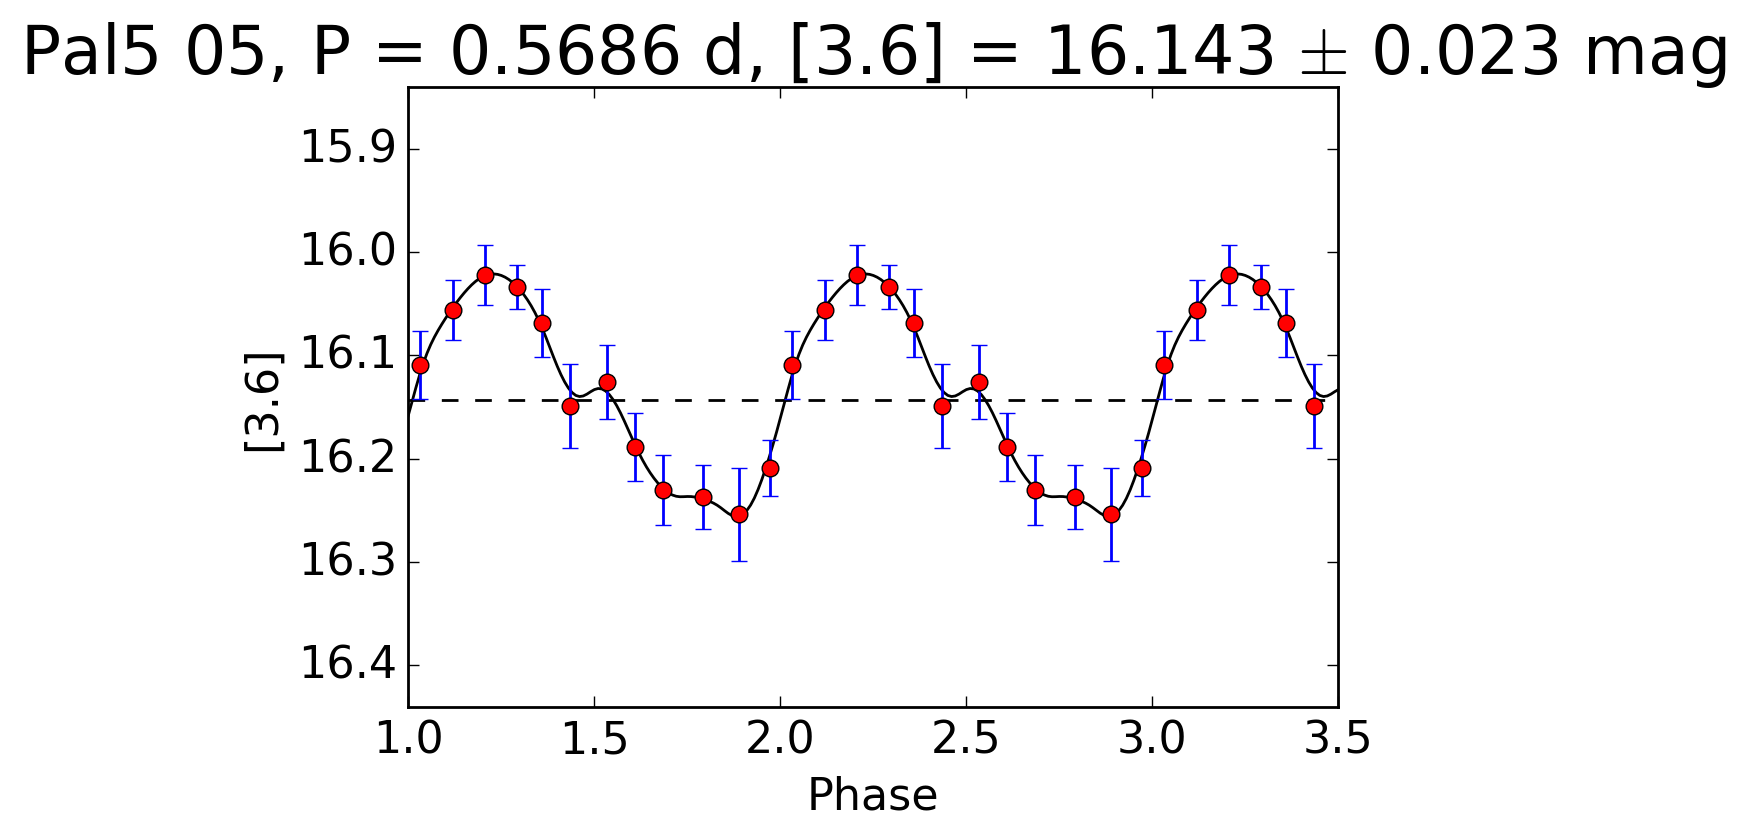

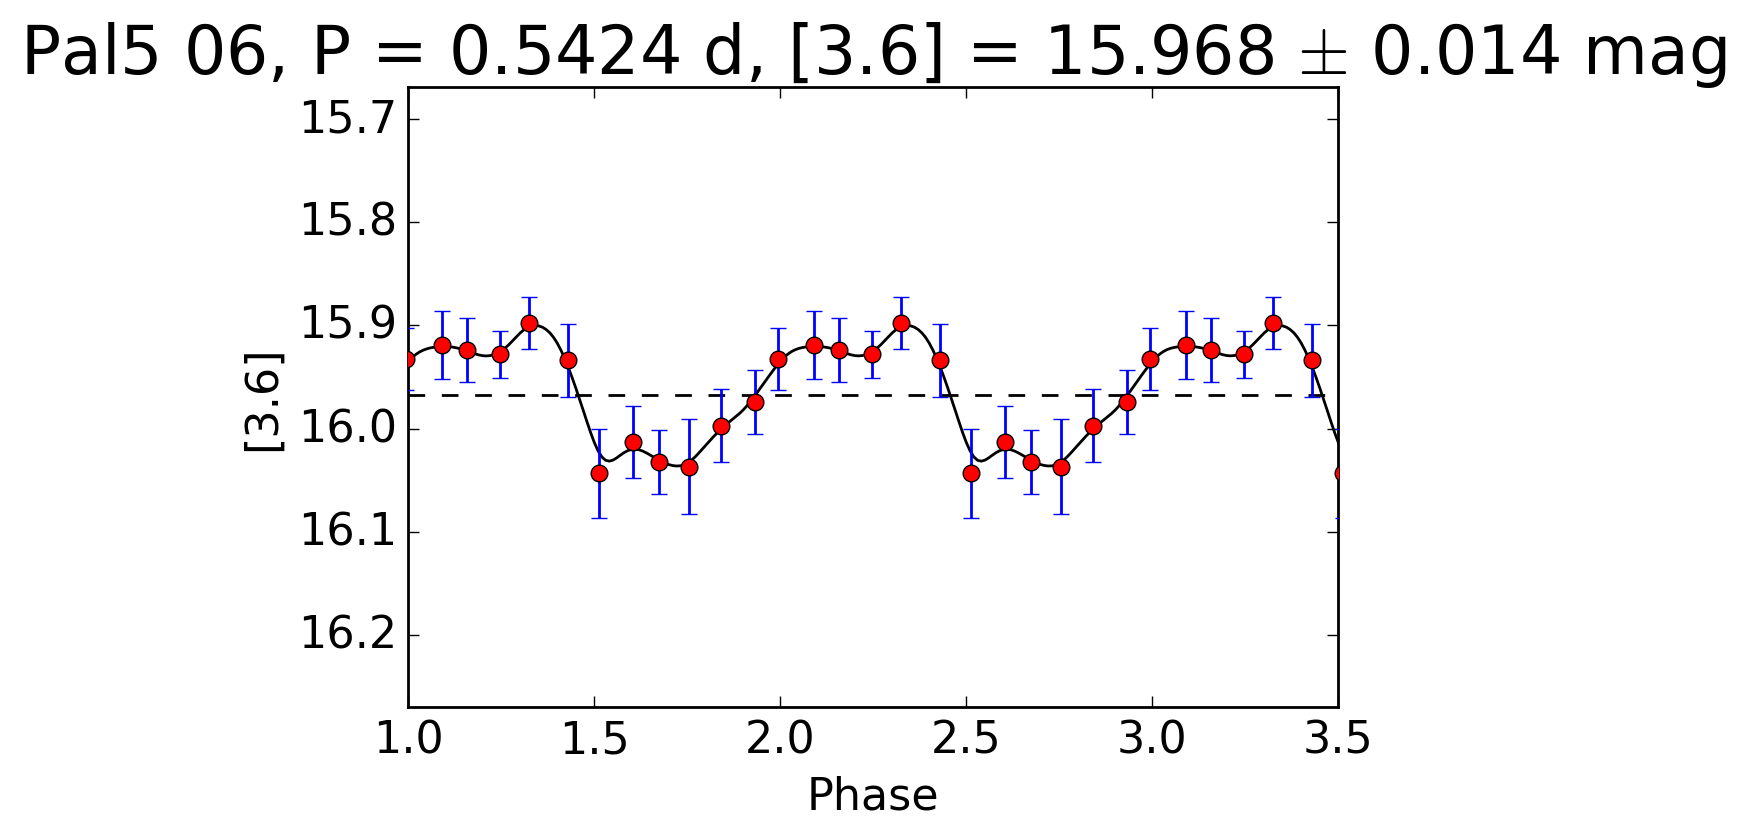

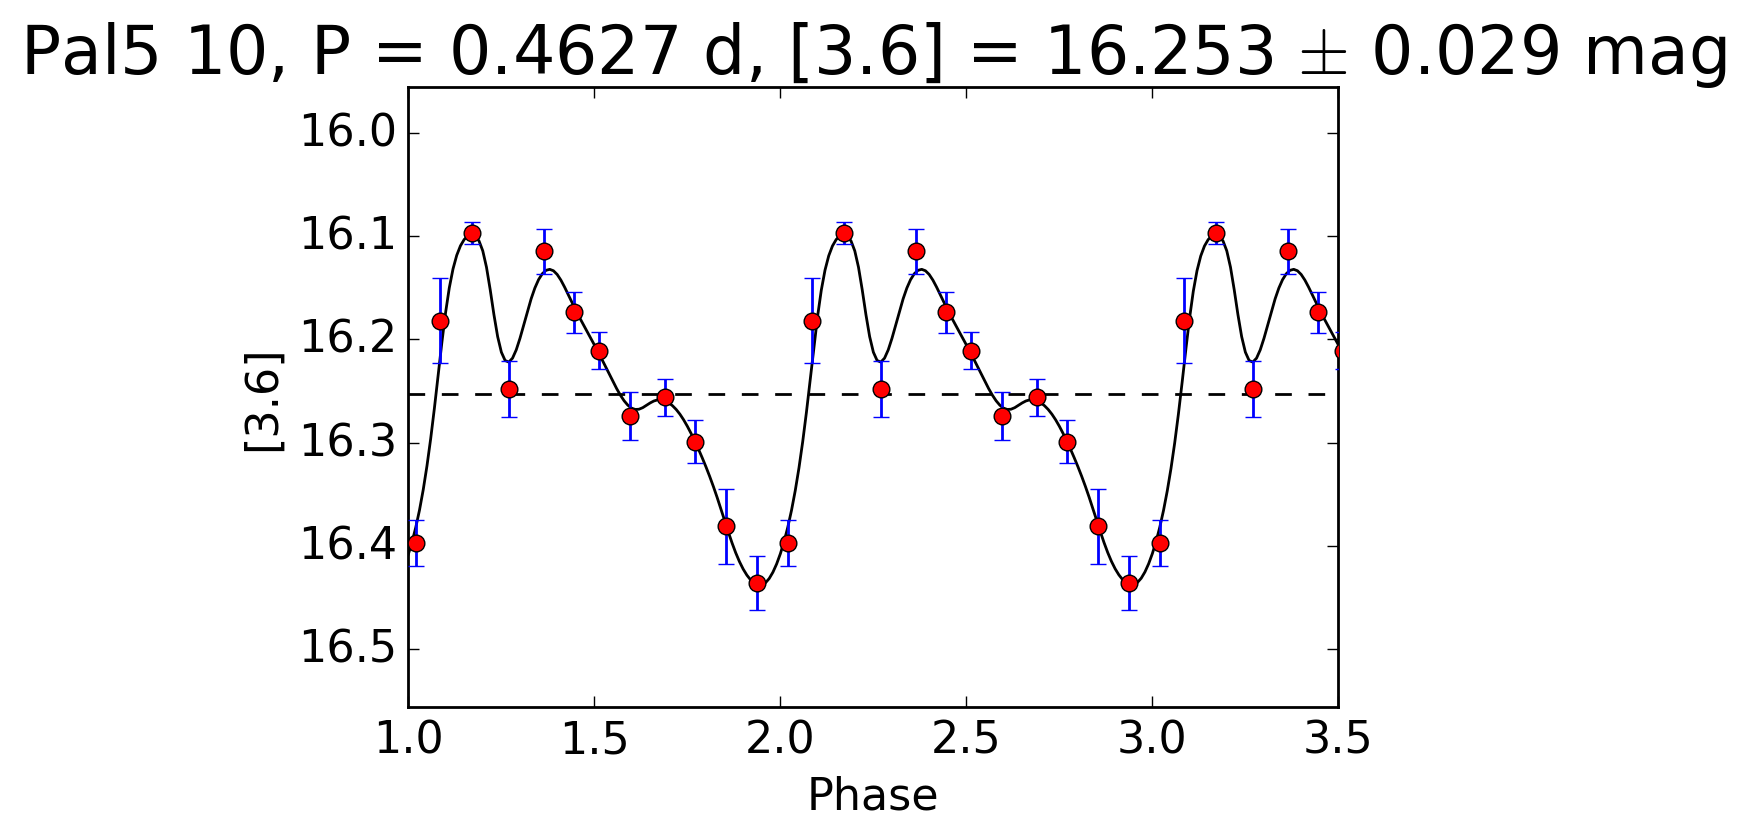

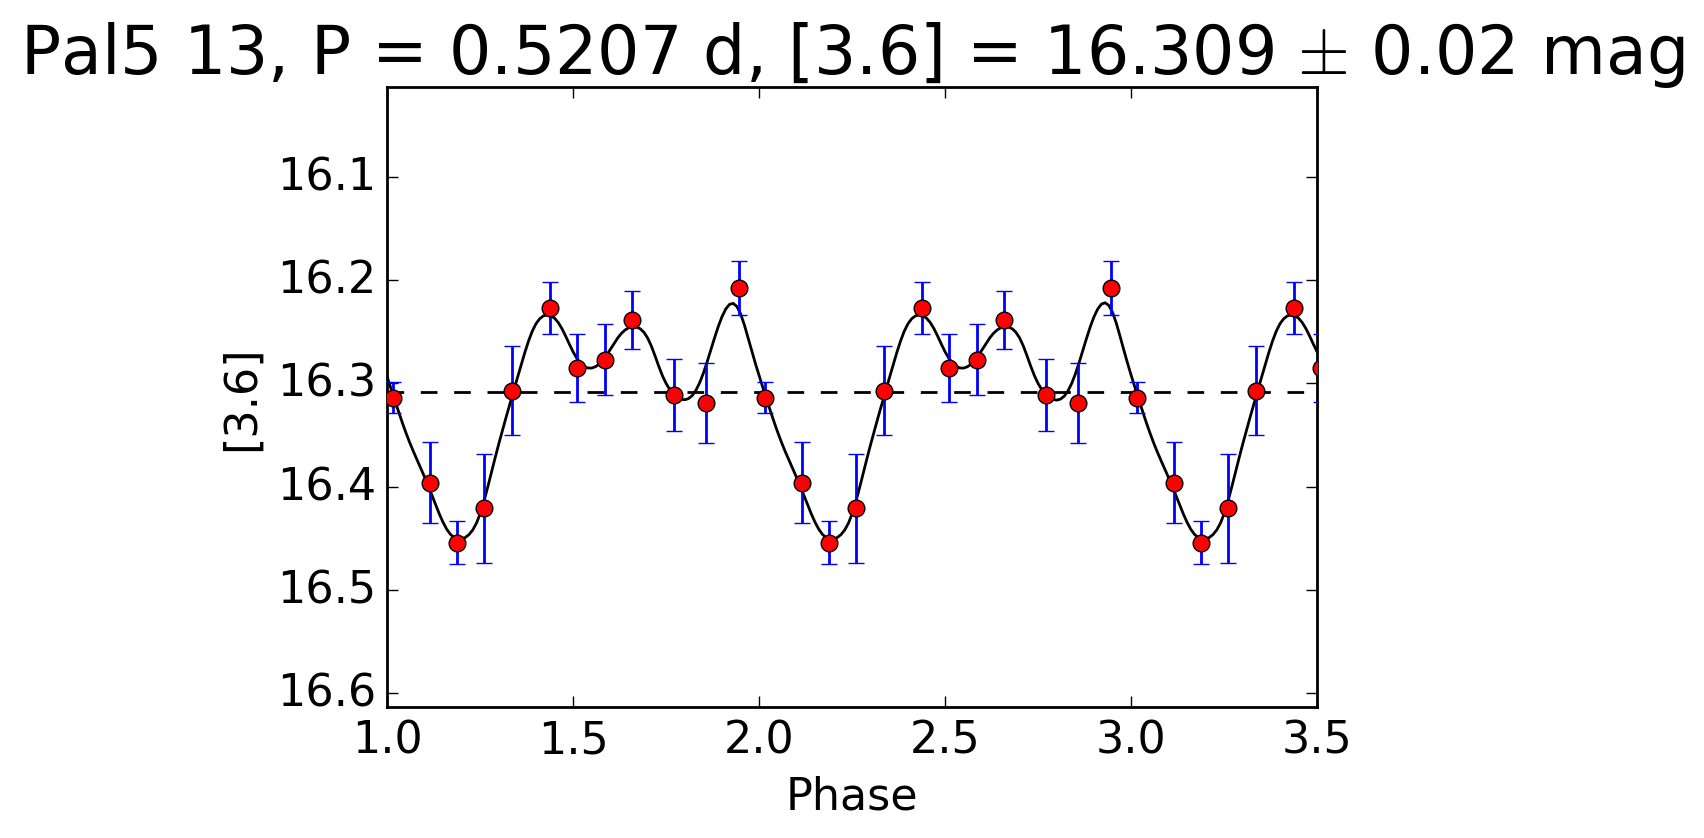

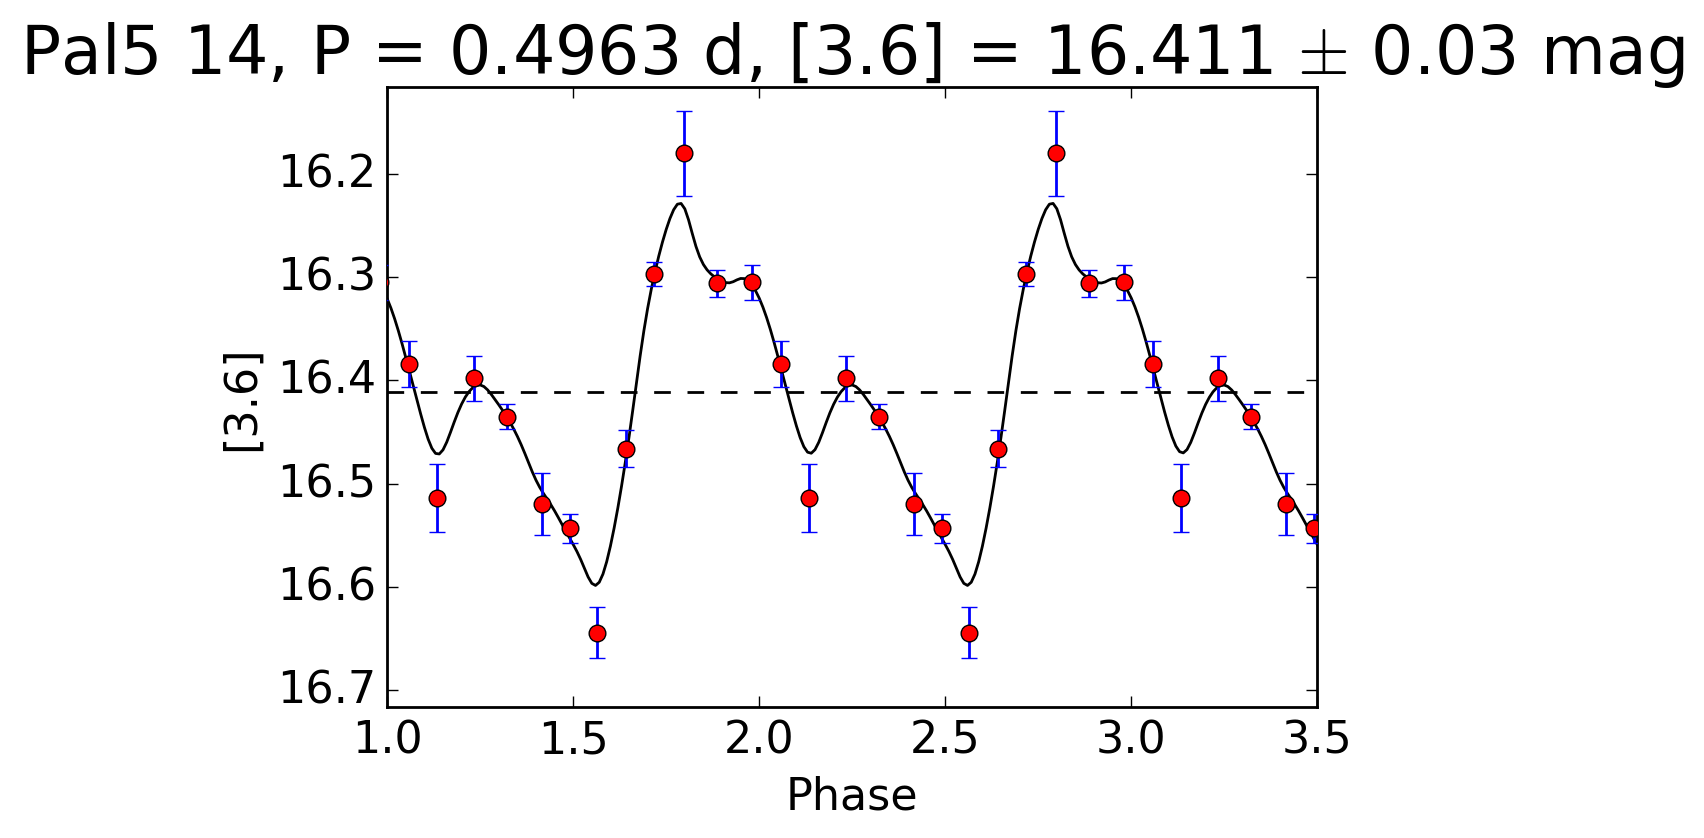

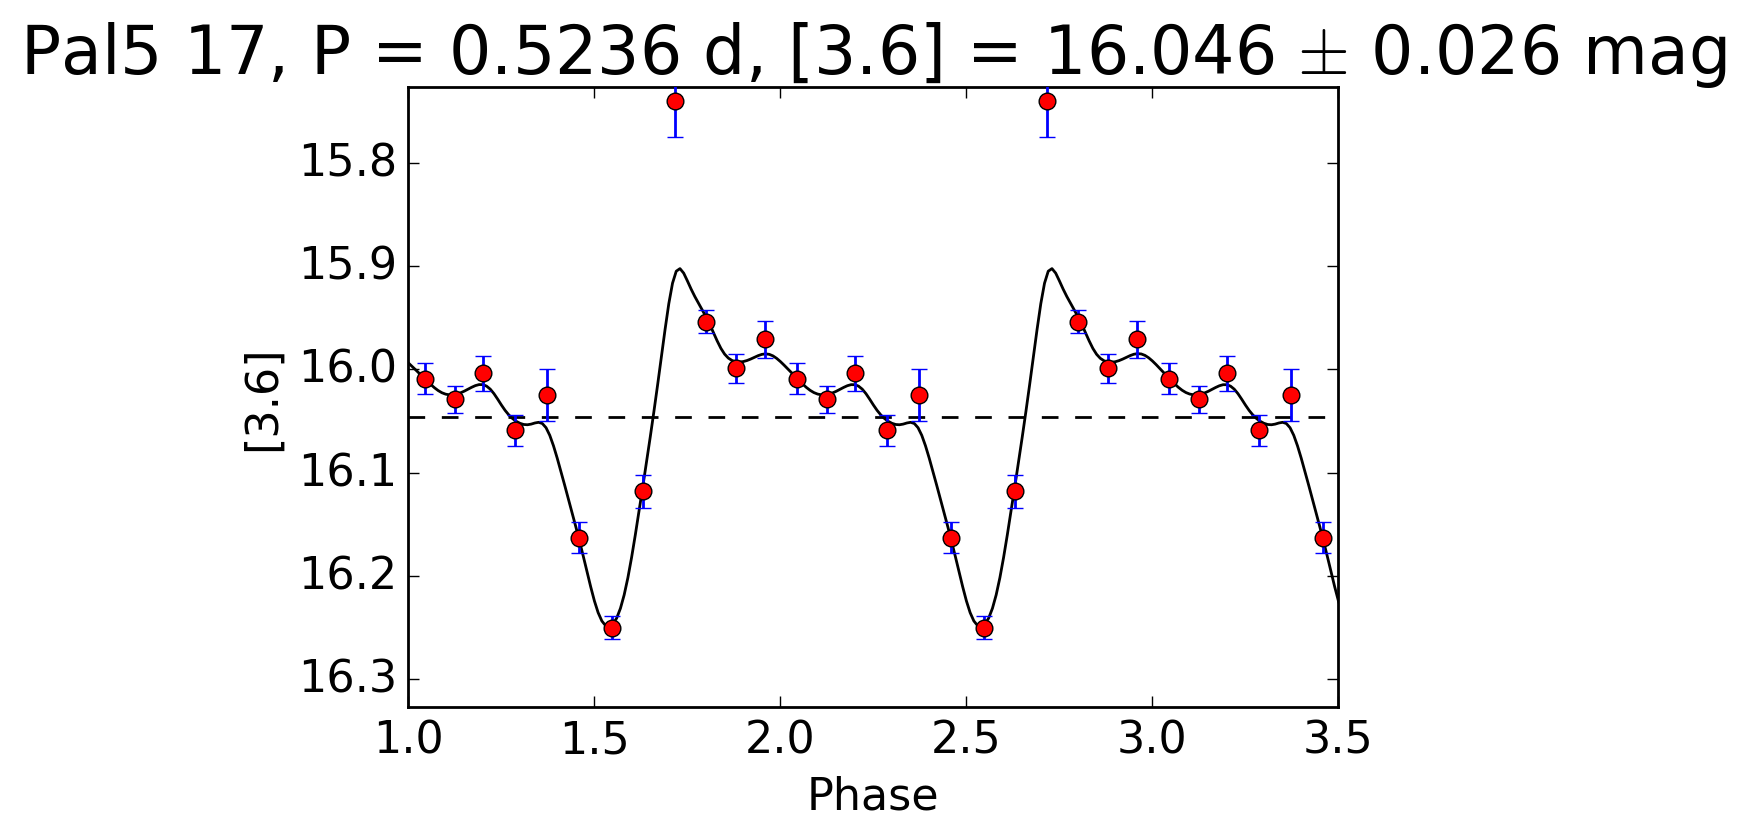

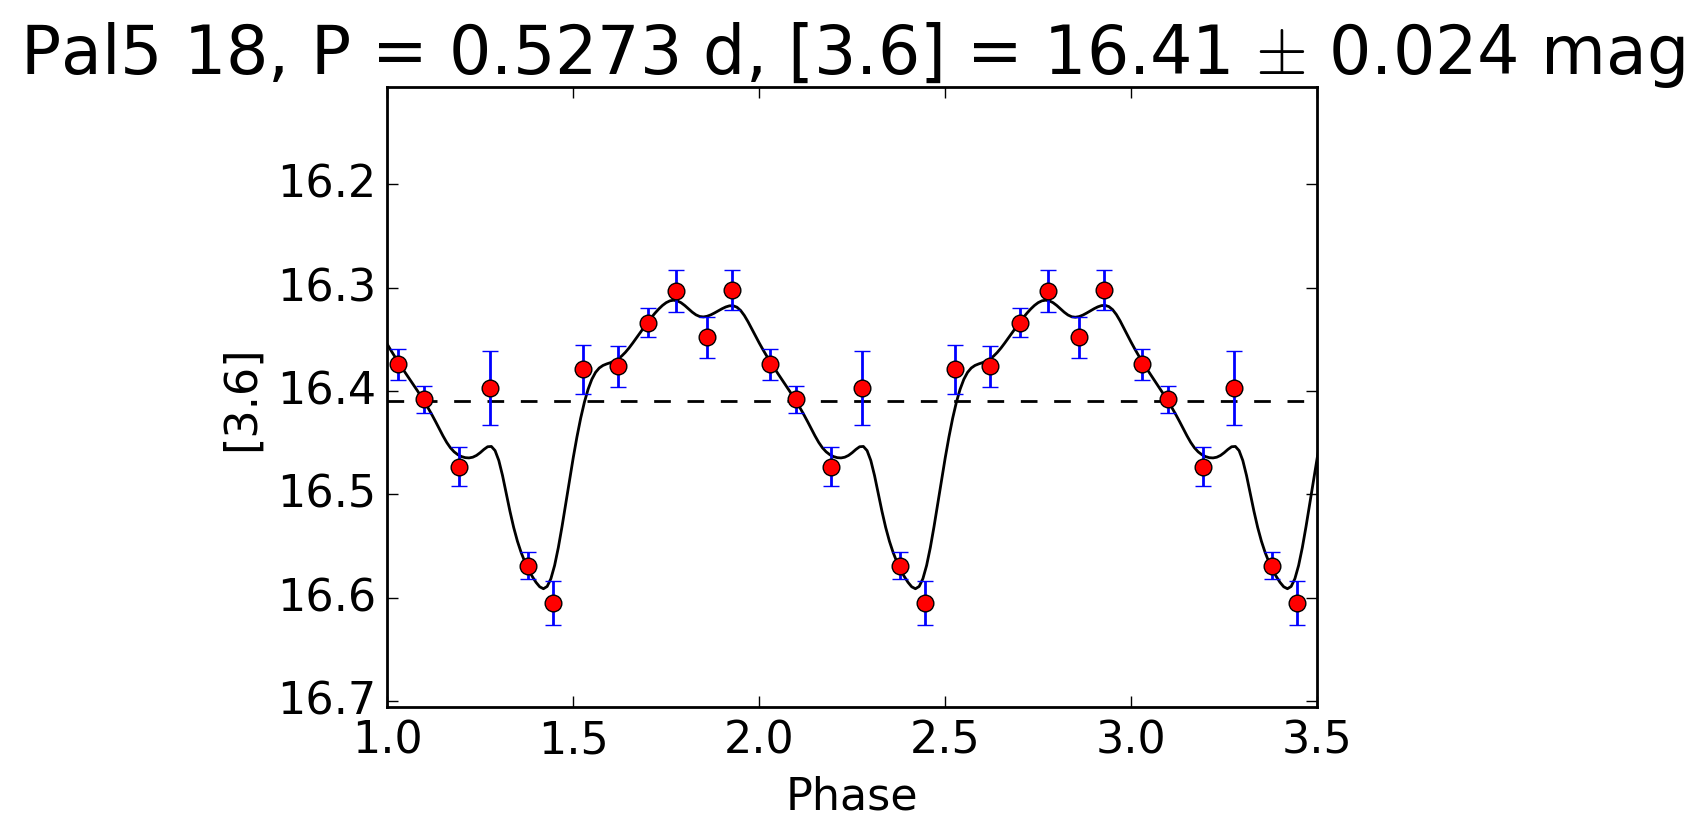

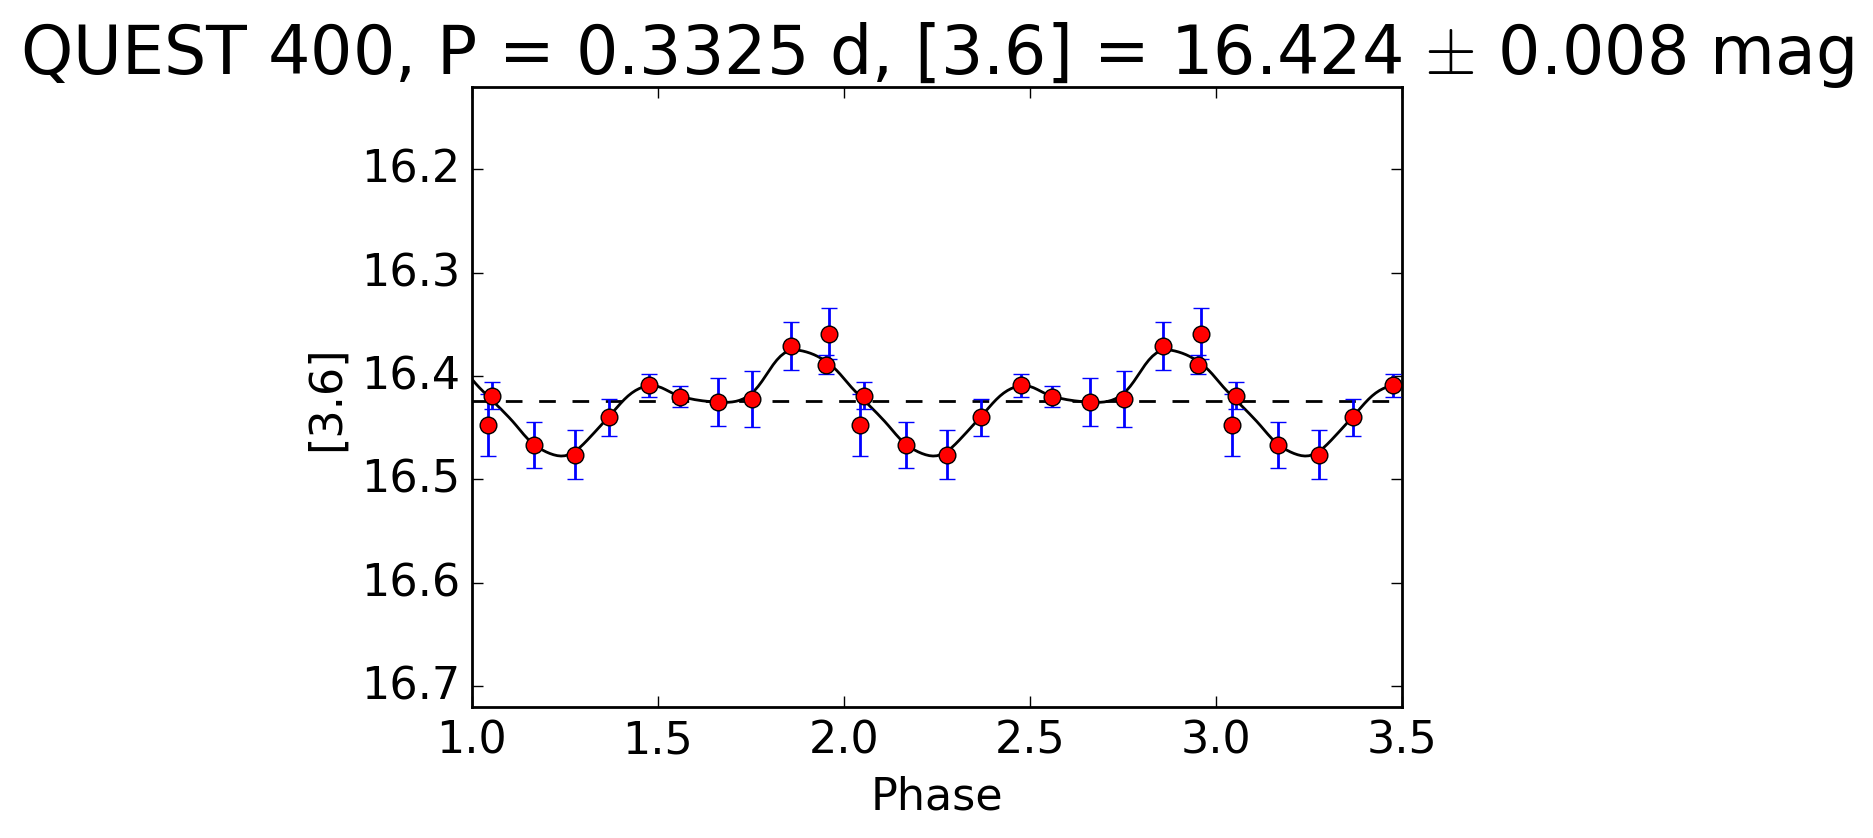

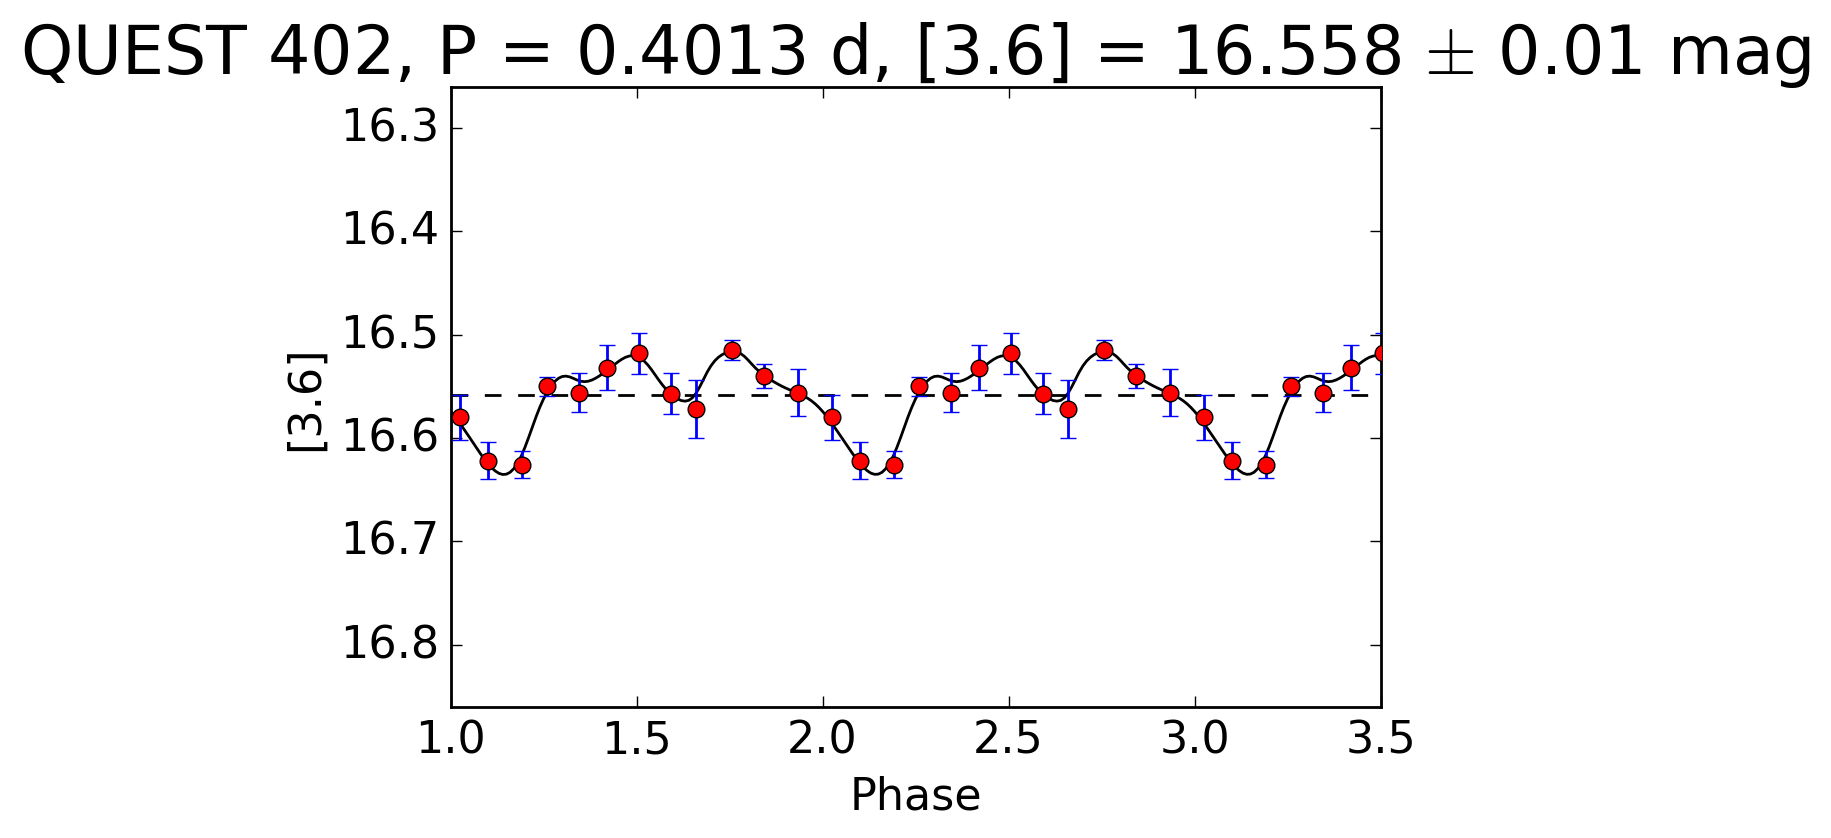

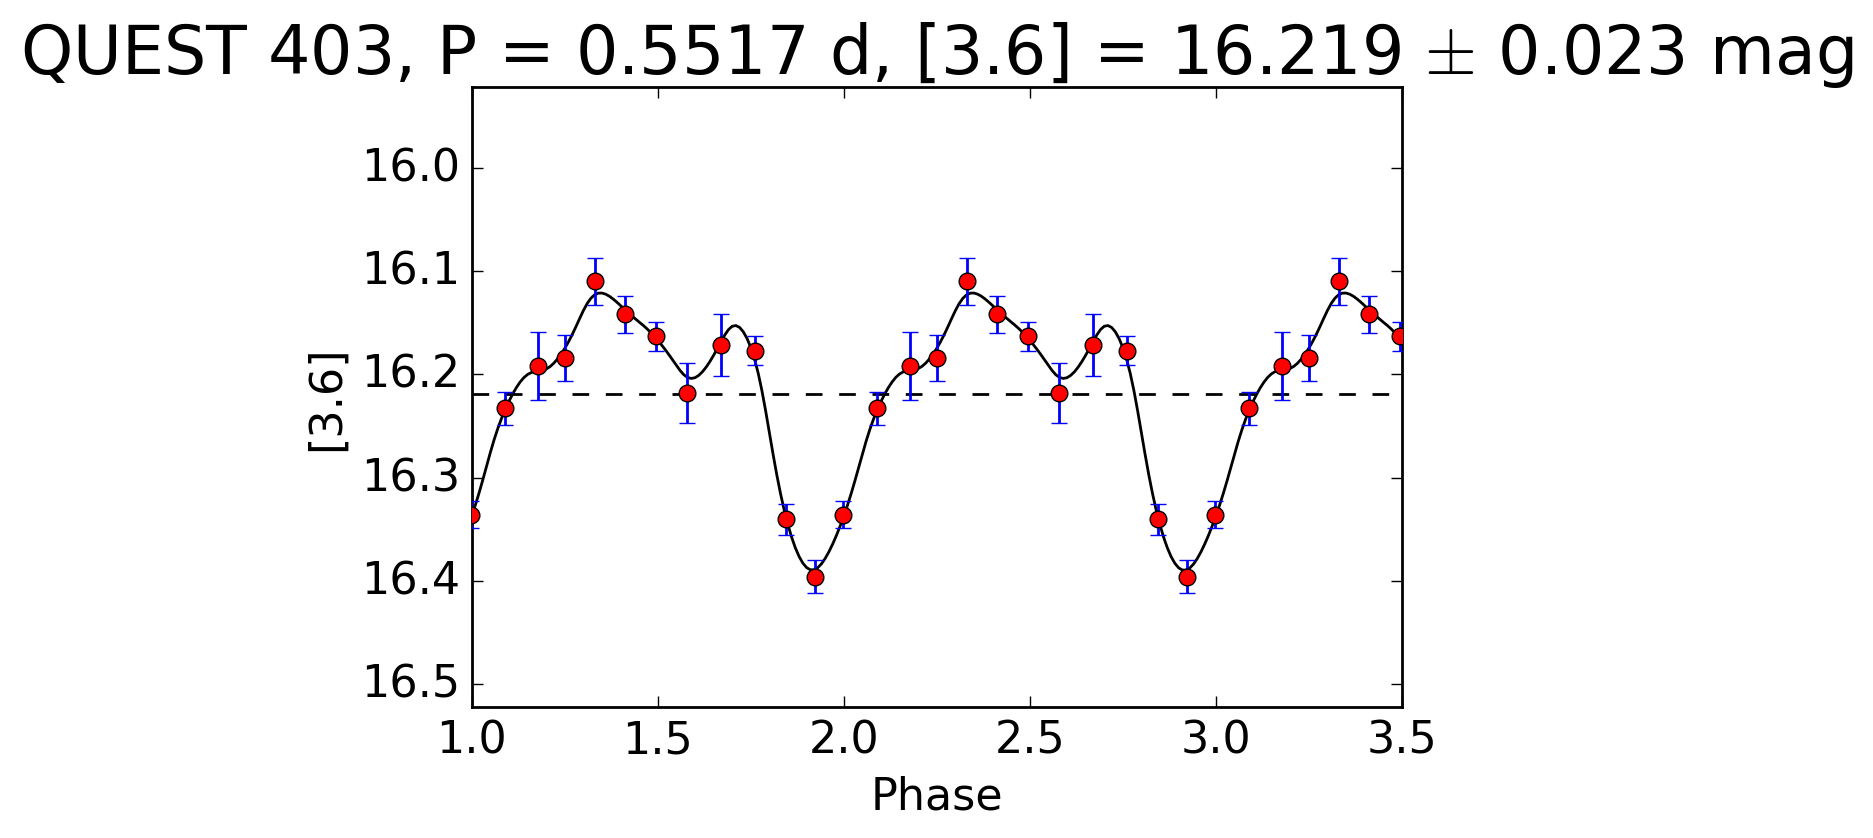

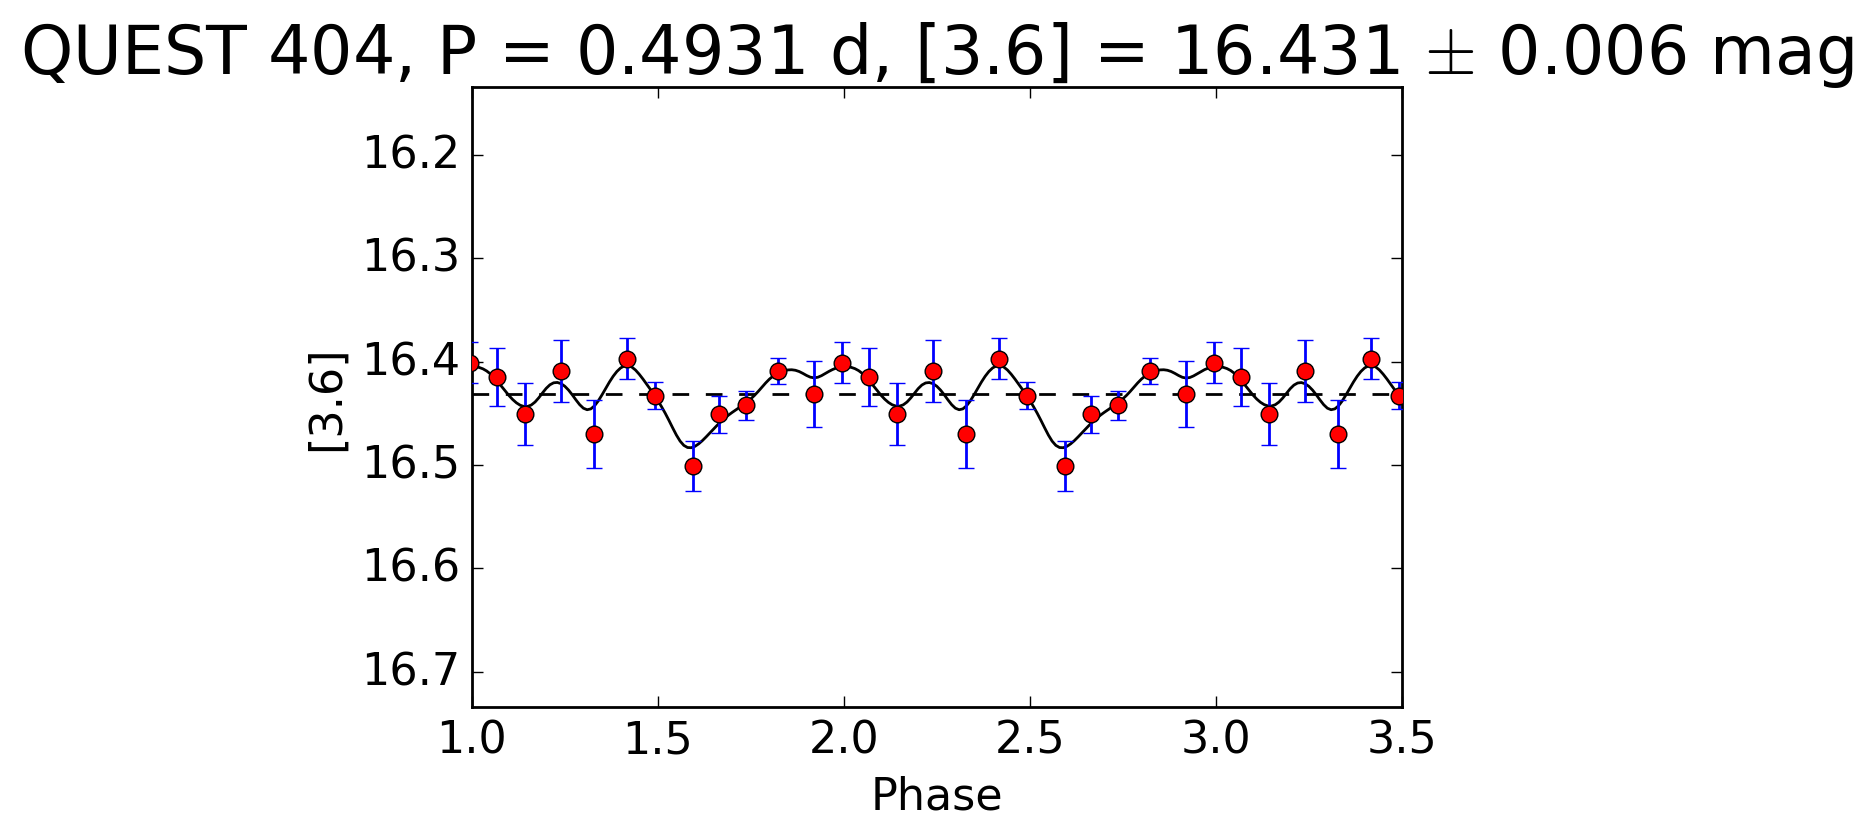

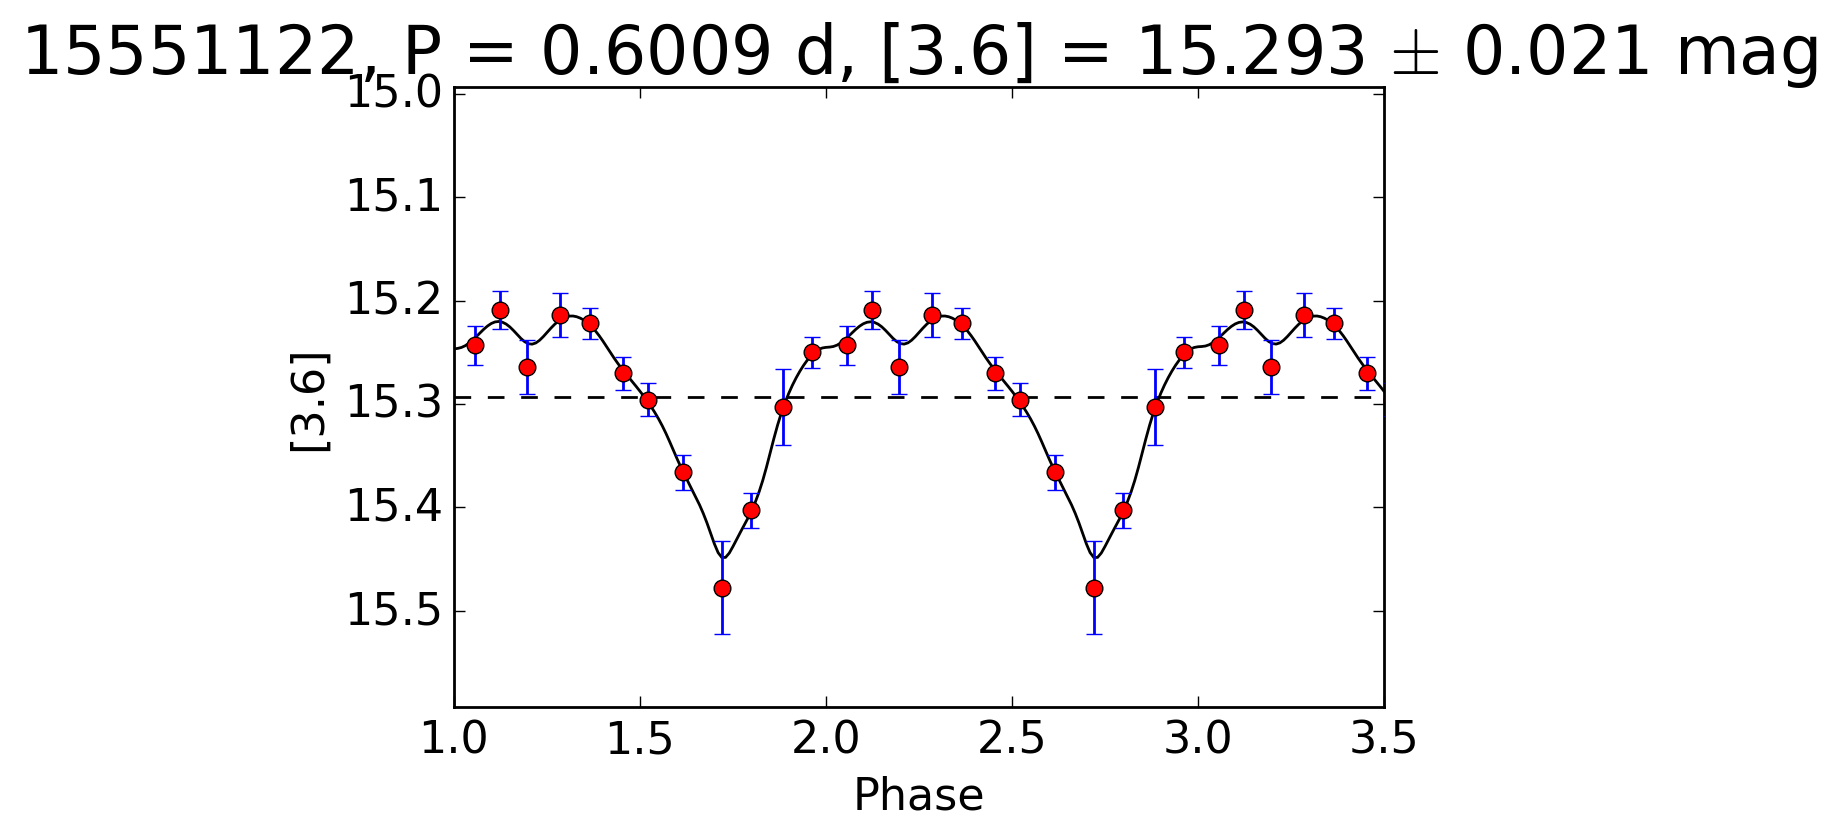

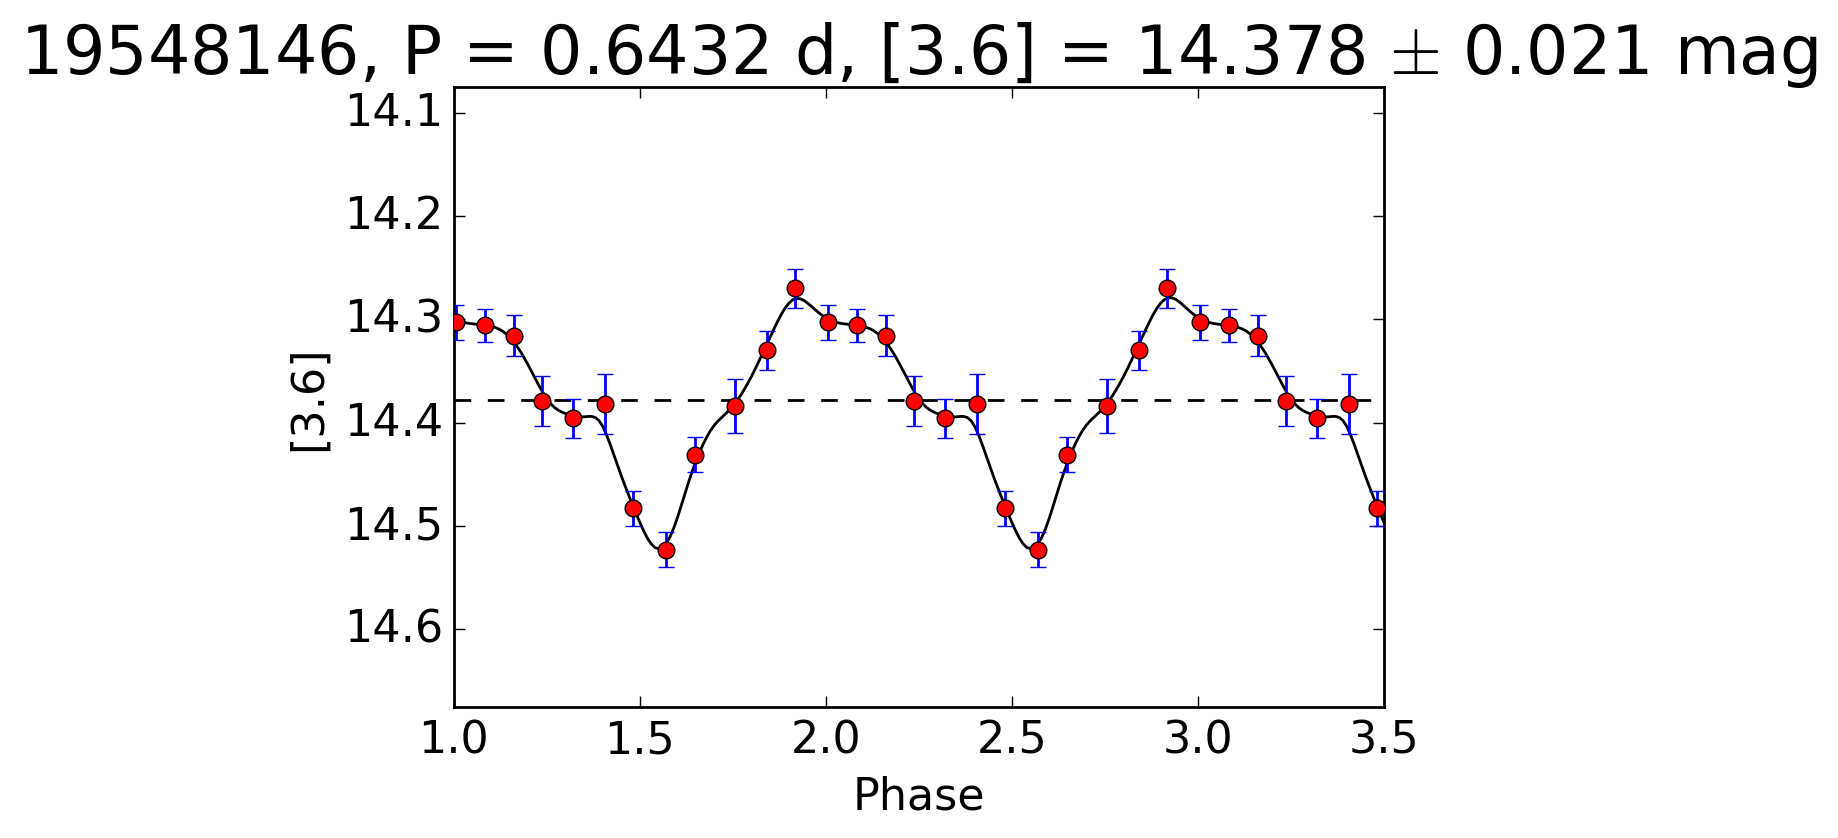

/Users/vs522/Dropbox/Python/gloess/gloess_fits.py:64: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
/Users/vs522/Dropbox/Python/gloess/gloess_fits.py:66: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)


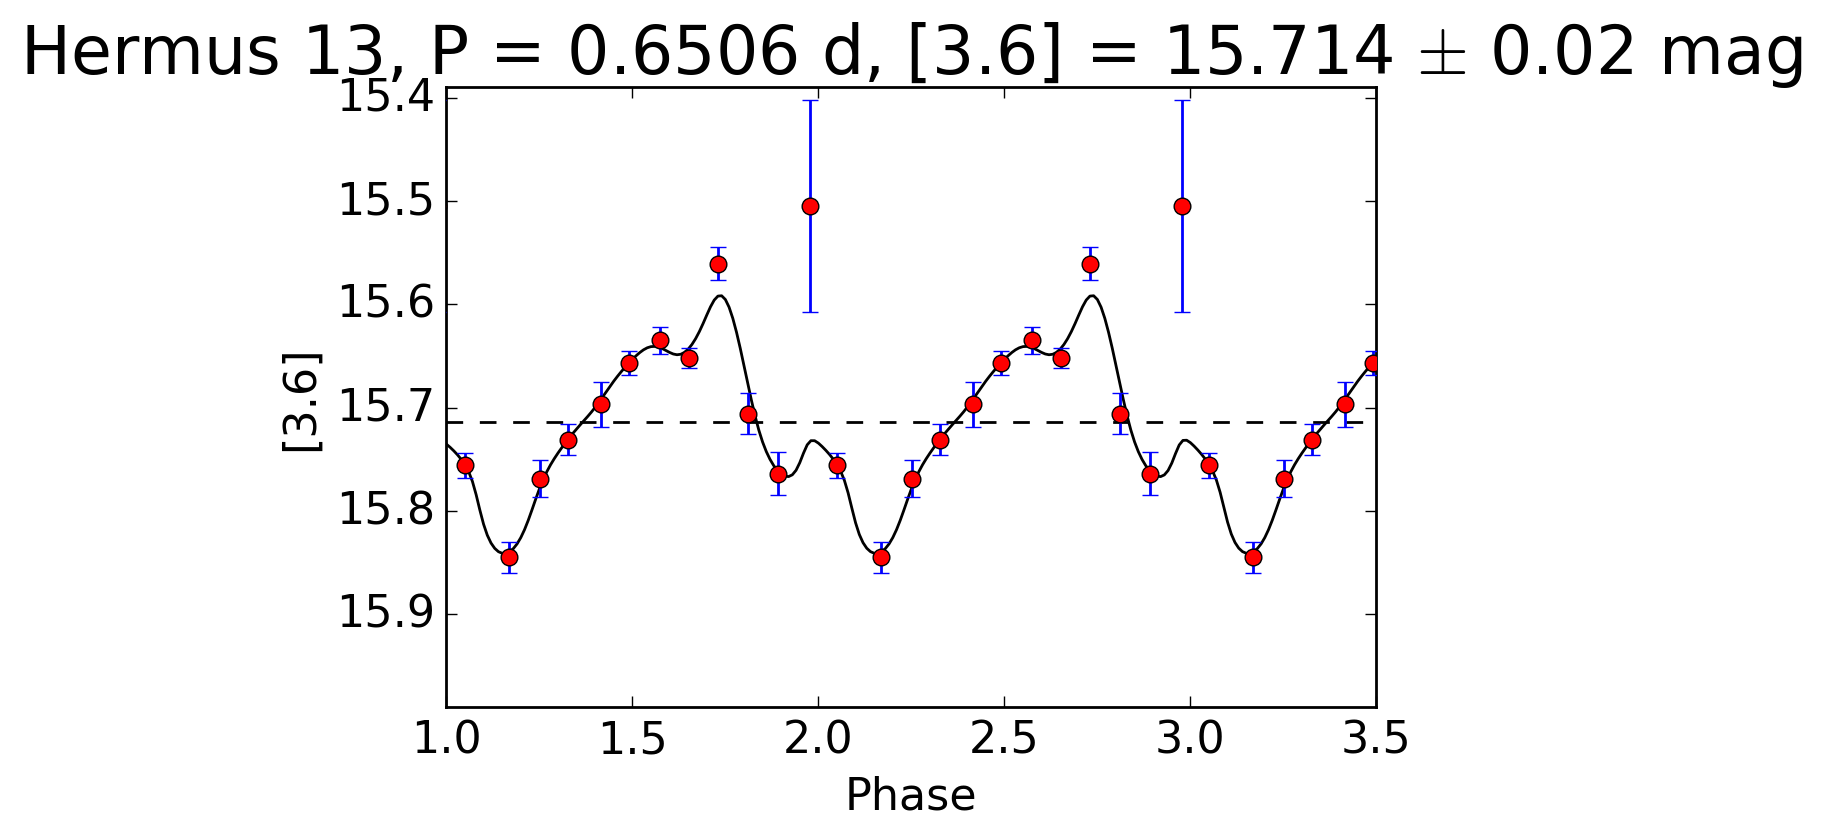

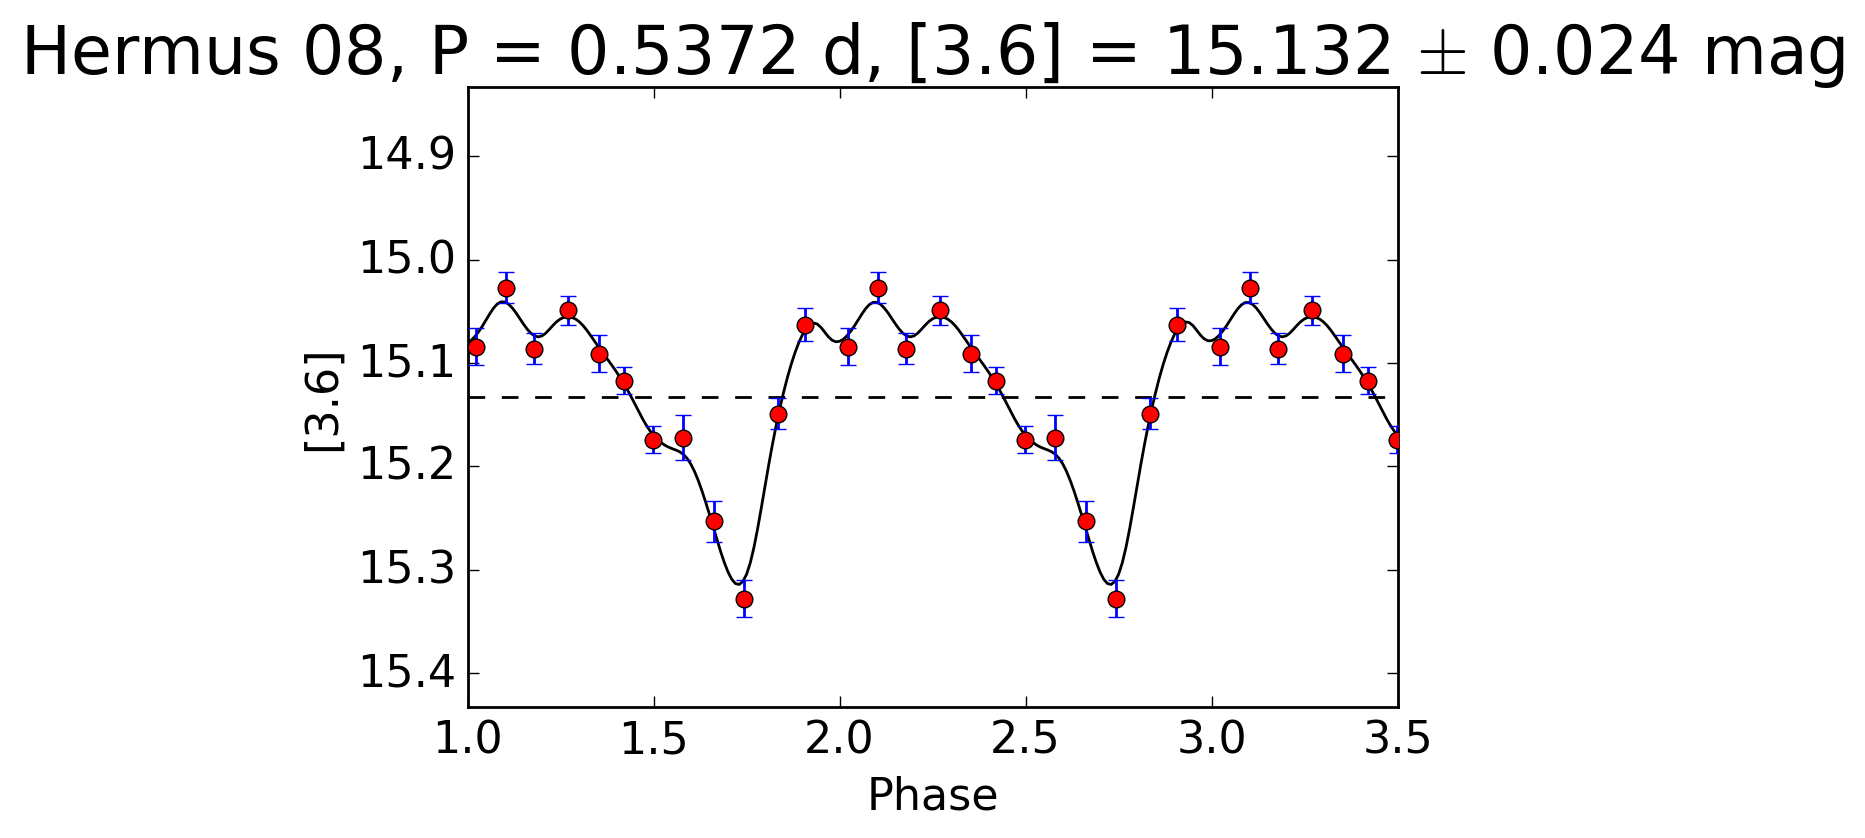

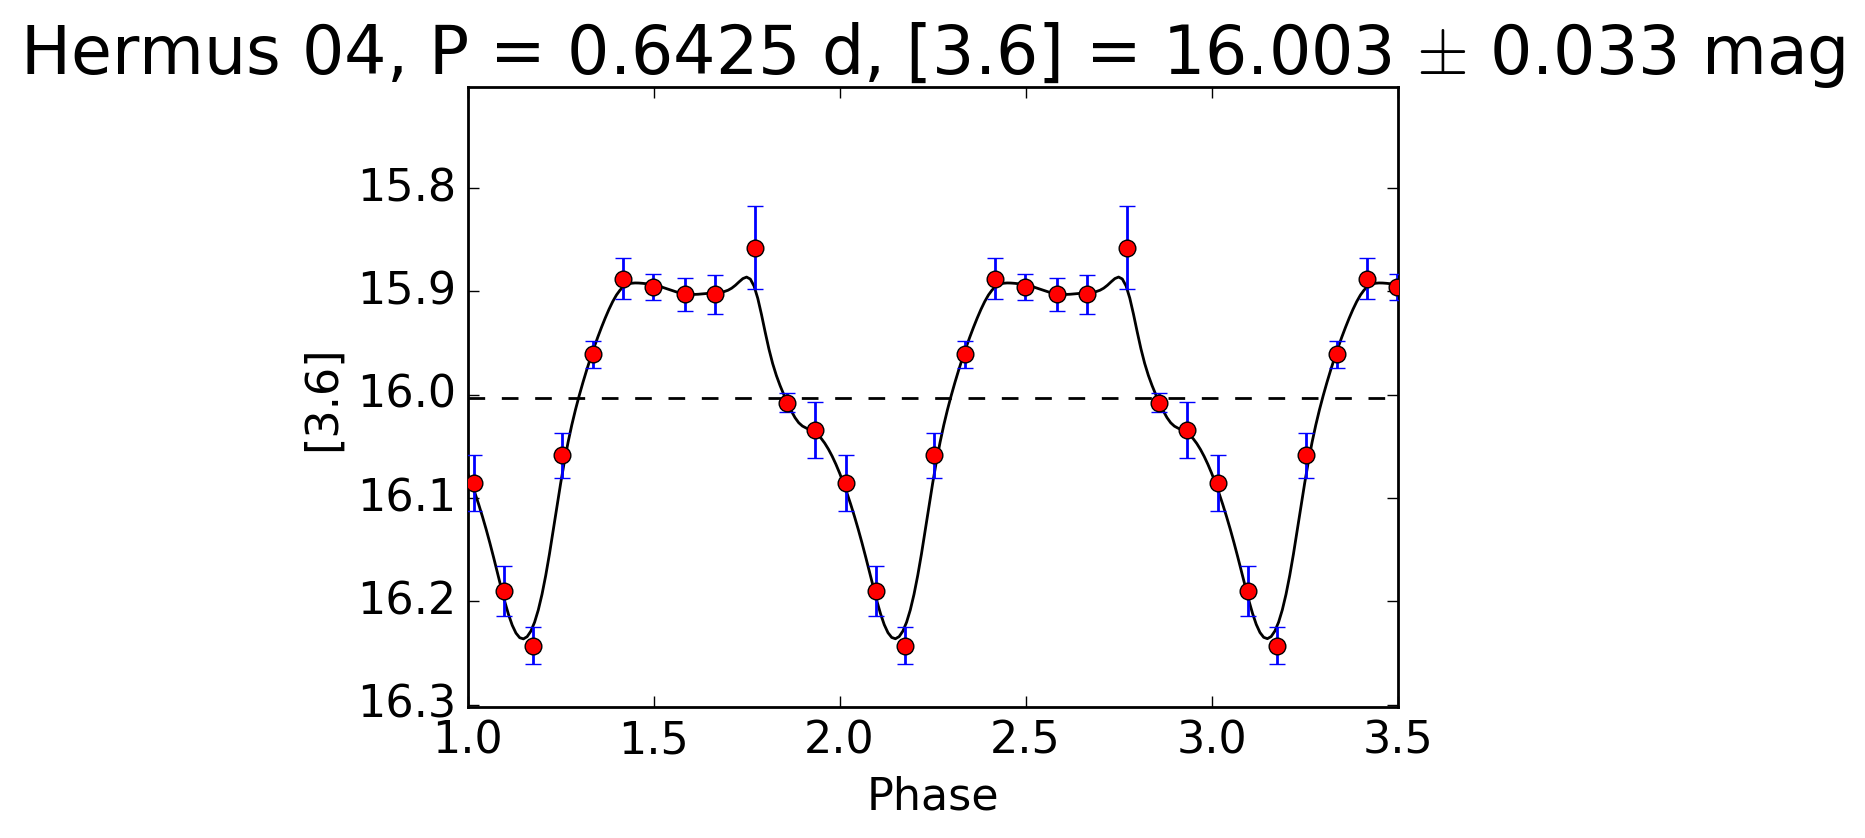

In [64]:
for counter in np.arange(0,(len(target_list_reindexed)),1):
    directory_switcher(counter)
    plot_existing_lc(counter, 1, 1.5/12.)

In [ ]:
target_list_reindexed

In [ ]:
target_list_reindexed['Abs_Mag'] = (-2.342 * np.log10(target_list_reindexed.period) -1.155)

In [ ]:
target_list_reindexed

In [ ]:
15.714+0.718

In [ ]:
def mu2pc(mu):
    return 10**((mu + 5.) / 5.)

In [ ]:
mu2pc(16.708)

In [ ]:
def make_finderchart:
    coords = str(target_list.ra[0]) +' ' +str(target_list.dec[0])
    ra= SkyCoord(coords, unit=(u.deg, u.deg)).ra
    dec = SkyCoord(coords, unit=(u.deg, u.deg)).dec
    fitsfile = target_stem + '_e1_3p6um.fits'
    print ra, dec


    inputfile = fitsfile

    fig = mp.figure(figsize=(10,10))
    mosaic = aplpy.FITSFigure(inputfile, figure = fig)
    mosaic.show_grayscale(vmin=0.037,vmax=0.115, invert='true') ### manually implimenting zscale
    mosaic.tick_labels.set_font(size='small')
    mosaic.tick_labels.set_xformat("hh:mm:ss")
    mosaic.set_theme('publication')
    mosaic.show_markers(ra.deg, dec.deg, edgecolor='magenta', facecolor='none', marker='o', s=100)
    mosaic.save('testfig.pdf')

In [161]:
reload(qa_code)

<module 'qa_code' from '/Users/vs522/Dropbox/Python/smhash_code/qa_code.py'>

In [142]:
targets = target_list_reindexed.head(1)

2, 1, 2
making output files

  READ NOISE (ADU; 1 frame) =     7.80        GAIN (e-/ADU; 1 frame) =     3.70
 LOW GOOD DATUM (in sigmas) =    30.00      HIGH GOOD DATUM (in ADU) =311000.00
             FWHM OF OBJECT =     3.50         THRESHOLD (in sigmas) =     4.00
  LS (LOW SHARPNESS CUTOFF) =     0.30    HS (HIGH SHARPNESS CUTOFF) =     1.40
  LR (LOW ROUNDNESS CUTOFF) =    -1.00    HR (HIGH ROUNDNESS CUTOFF) =     1.00
             WATCH PROGRESS =    -2.00                FITTING RADIUS =     4.00
                 PSF RADIUS =    19.00                  VARIABLE PSF =     0.00
              SKY ESTIMATOR =     0.00            ANALYTIC MODEL PSF =    -6.00
  EXTRA PSF CLEANING PASSES =     5.00       USE SATURATED PSF STARS =     0.00
       PERCENT ERROR (in %) =     0.75          PROFILE ERROR (in %) =     5.00

 Command: at CSS_J144258_e1_3p6um
at CSS_J144258_e1_3p6um

     CSS_J144258_e1_3p6um...                 


                                      Picture size:    604   68

3
220d44m33.522s -9d06m16.092s


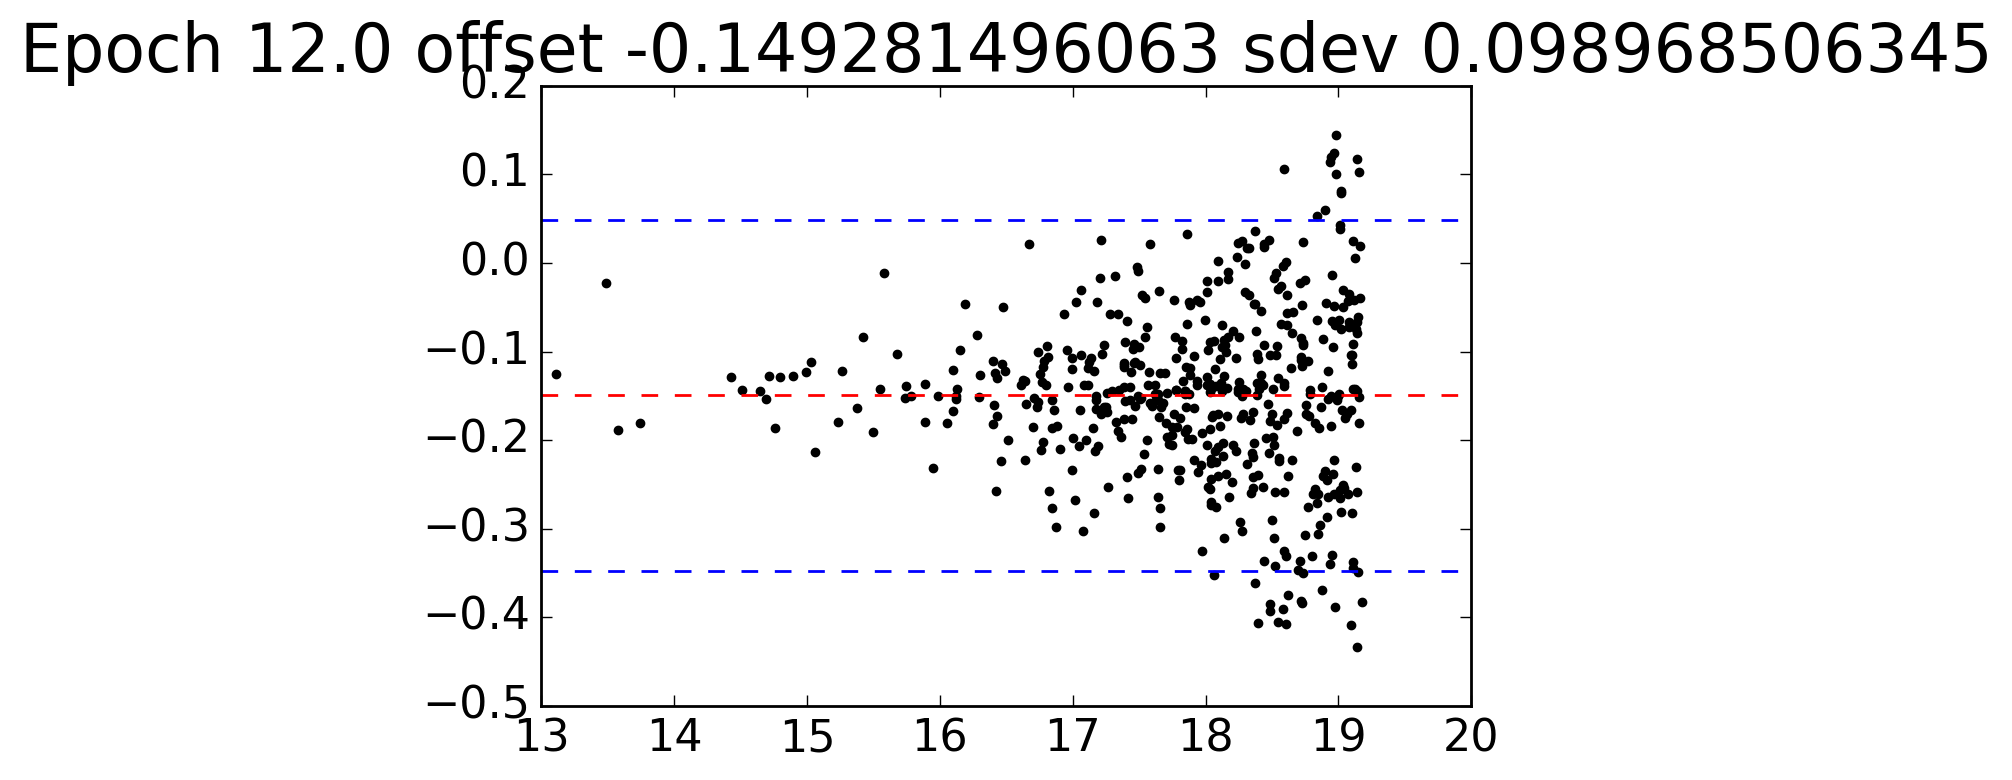

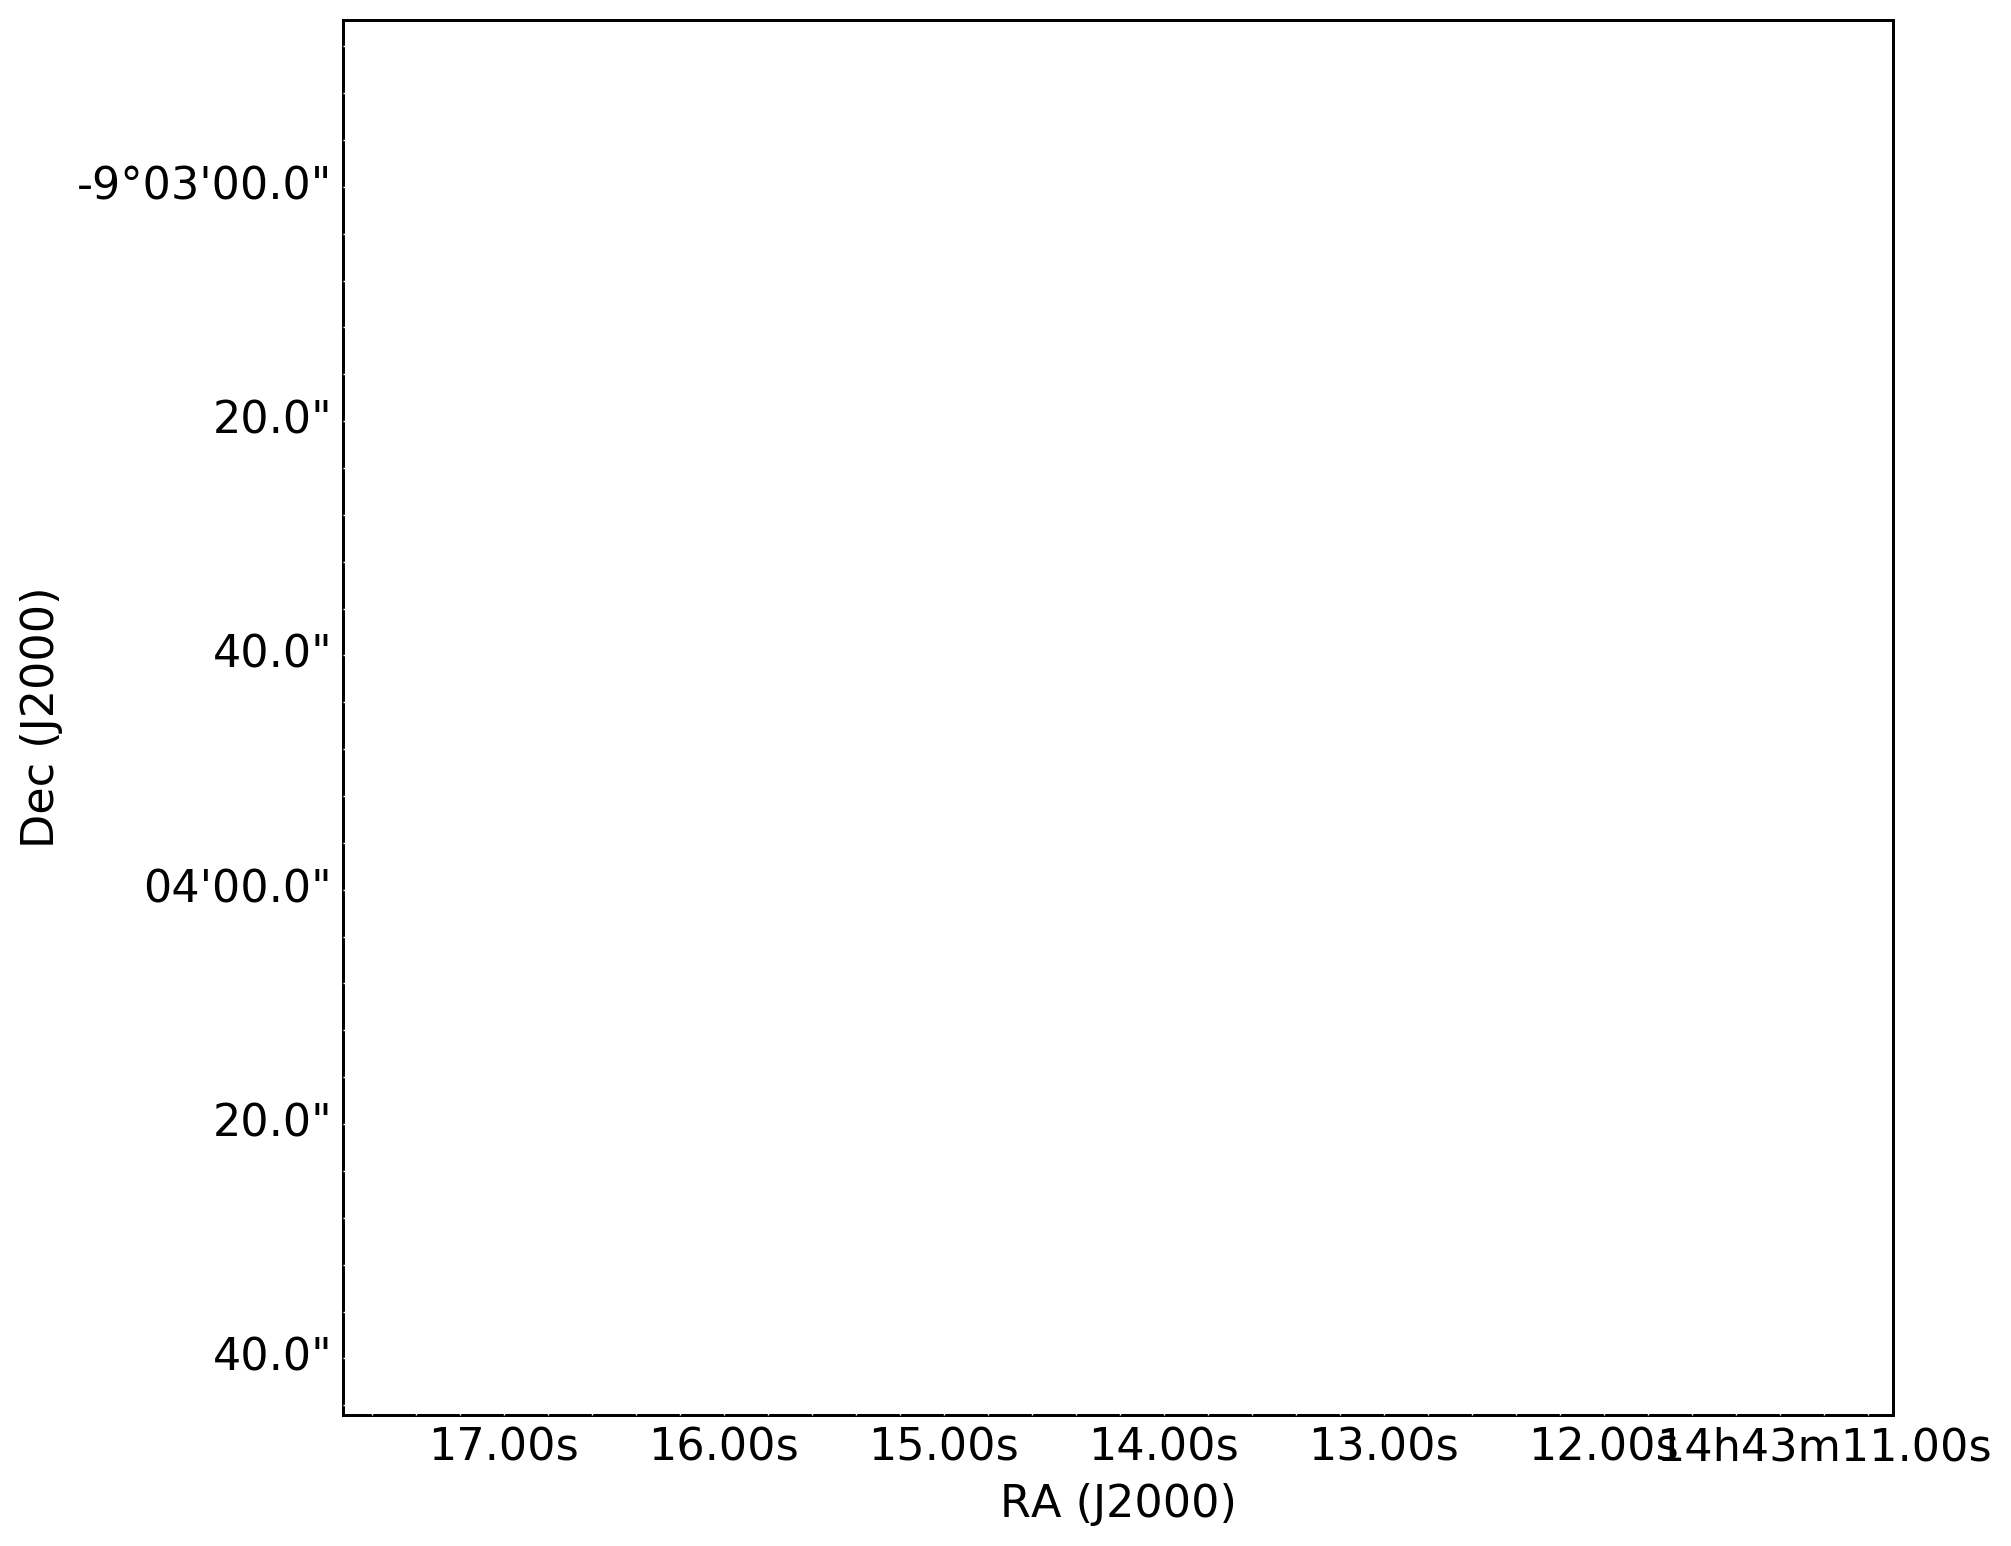

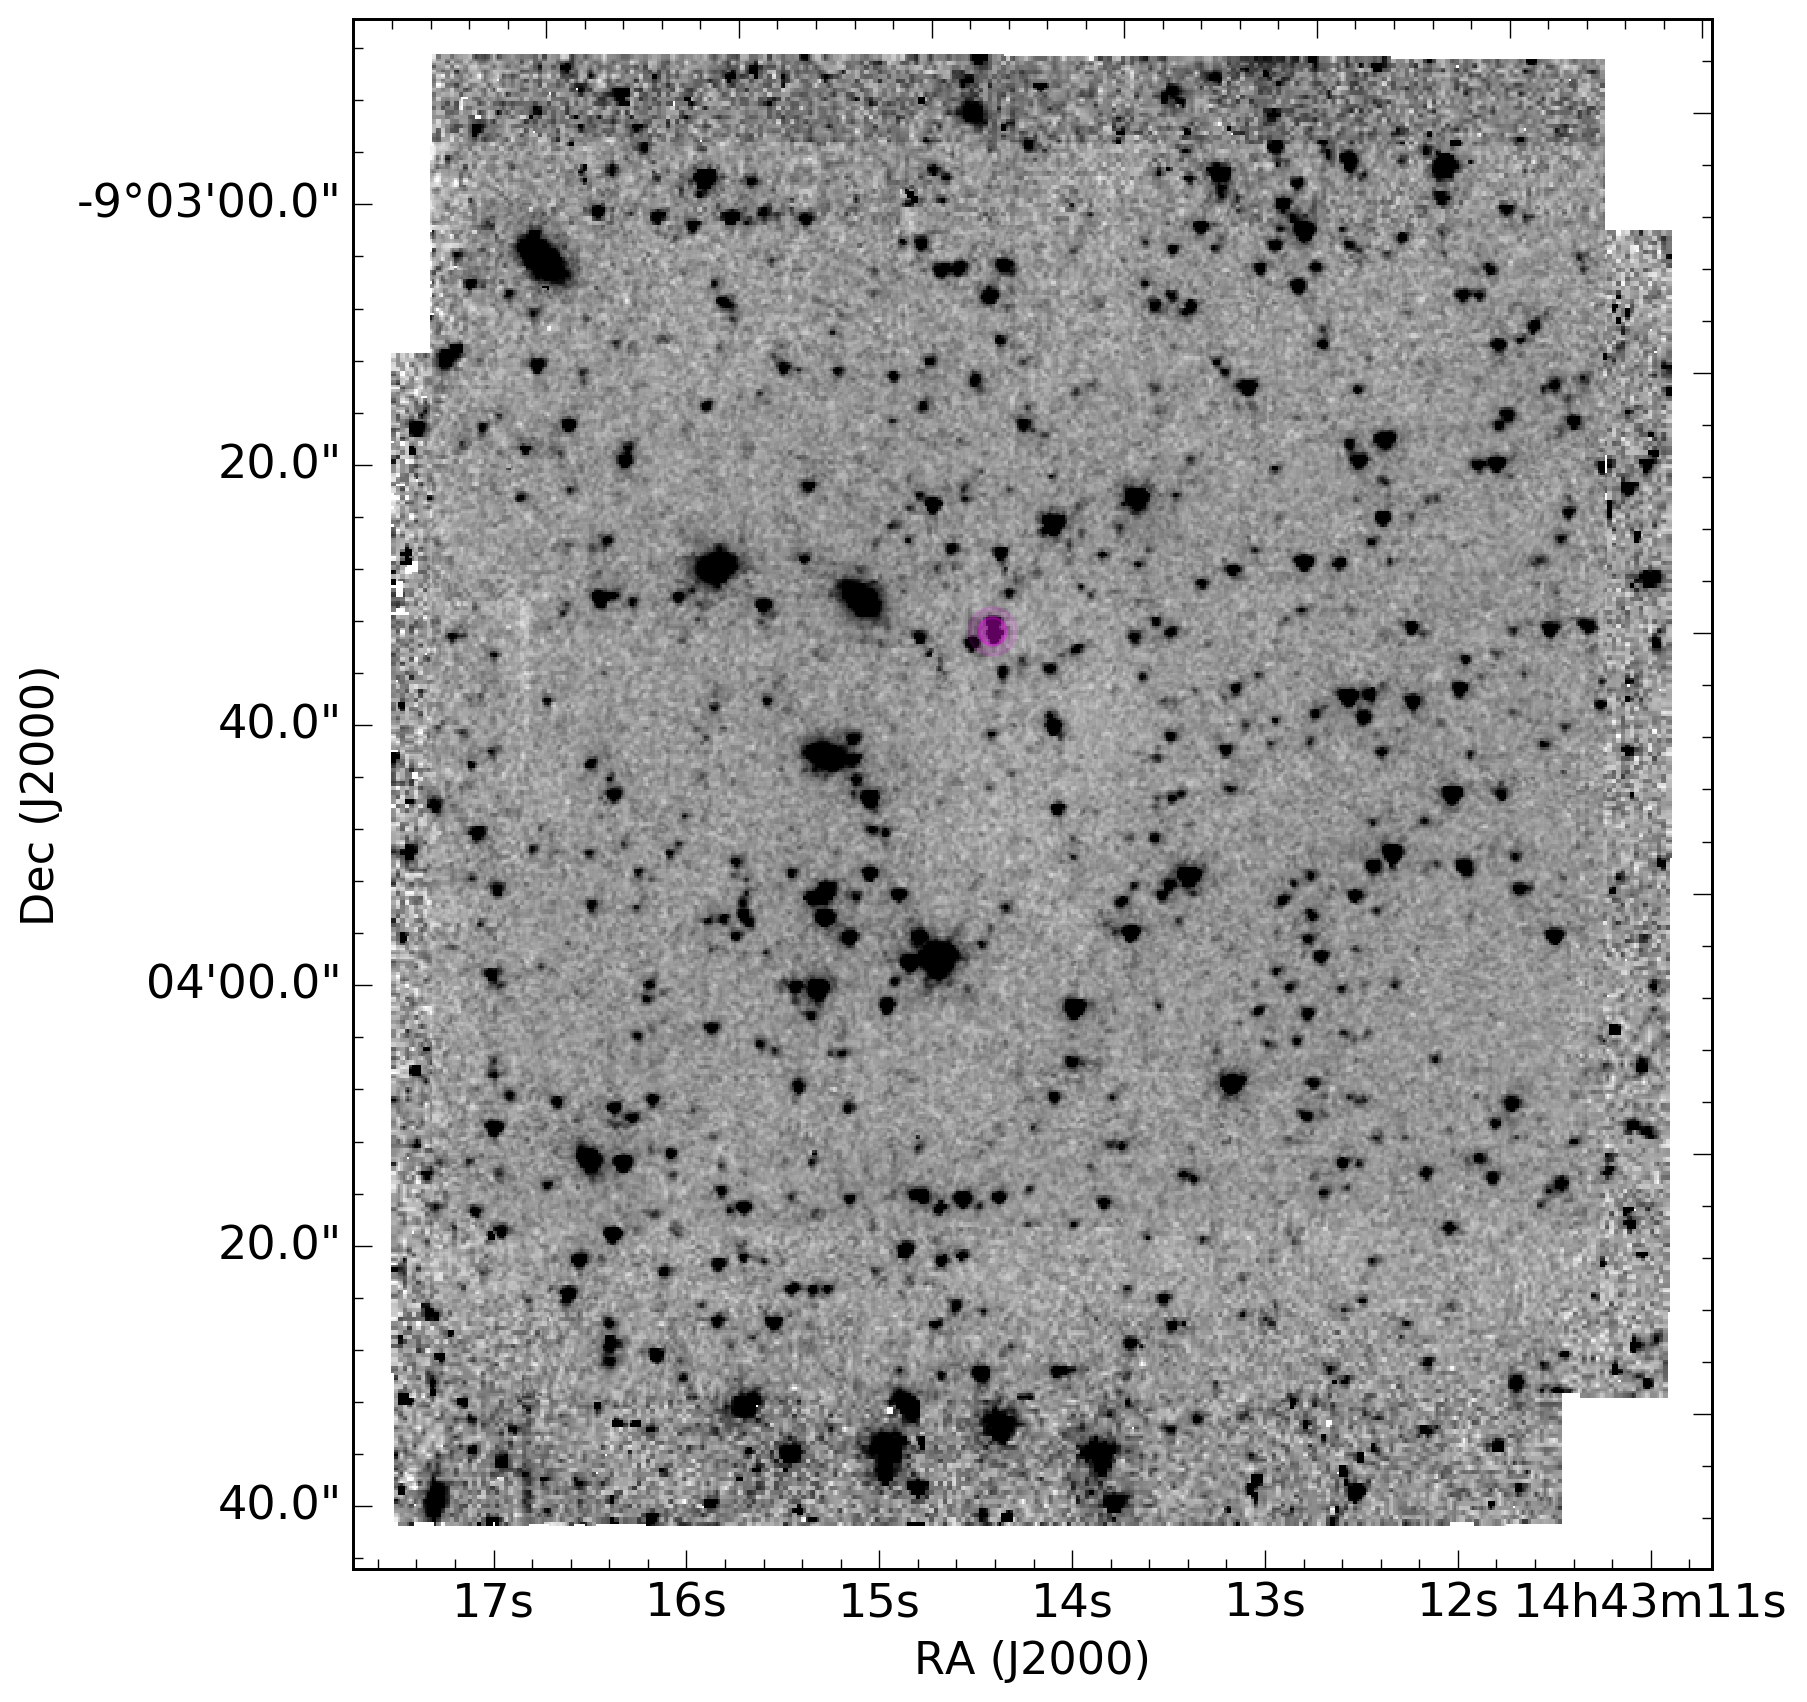

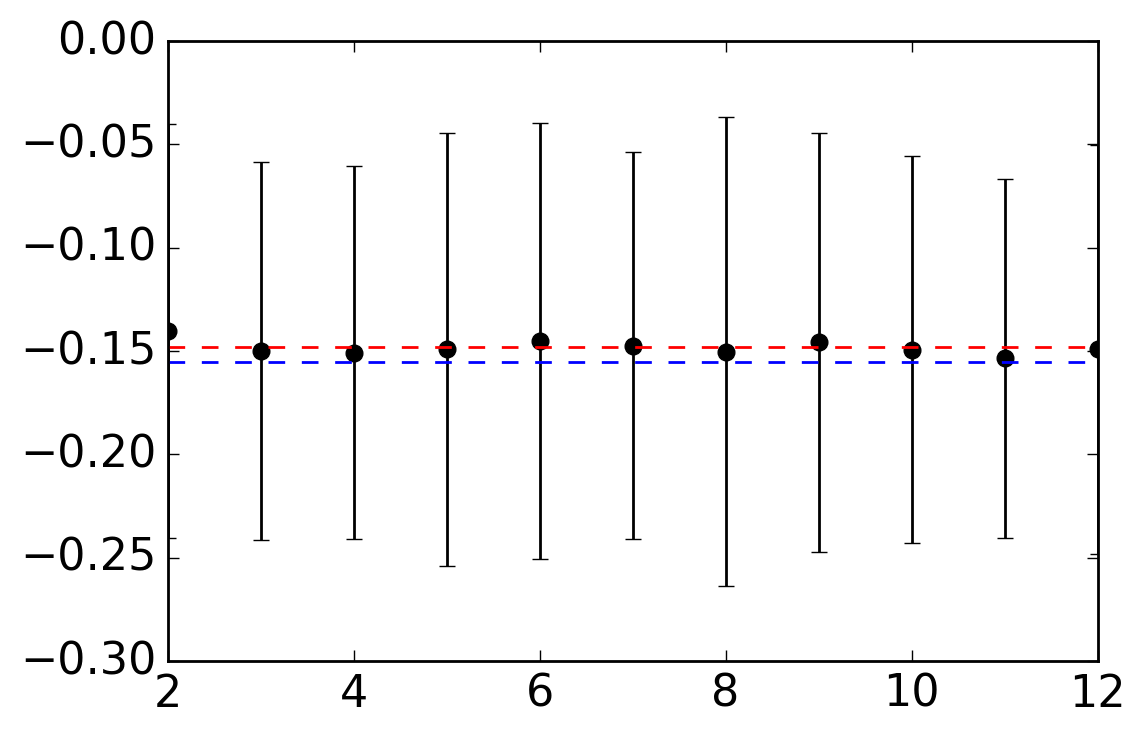

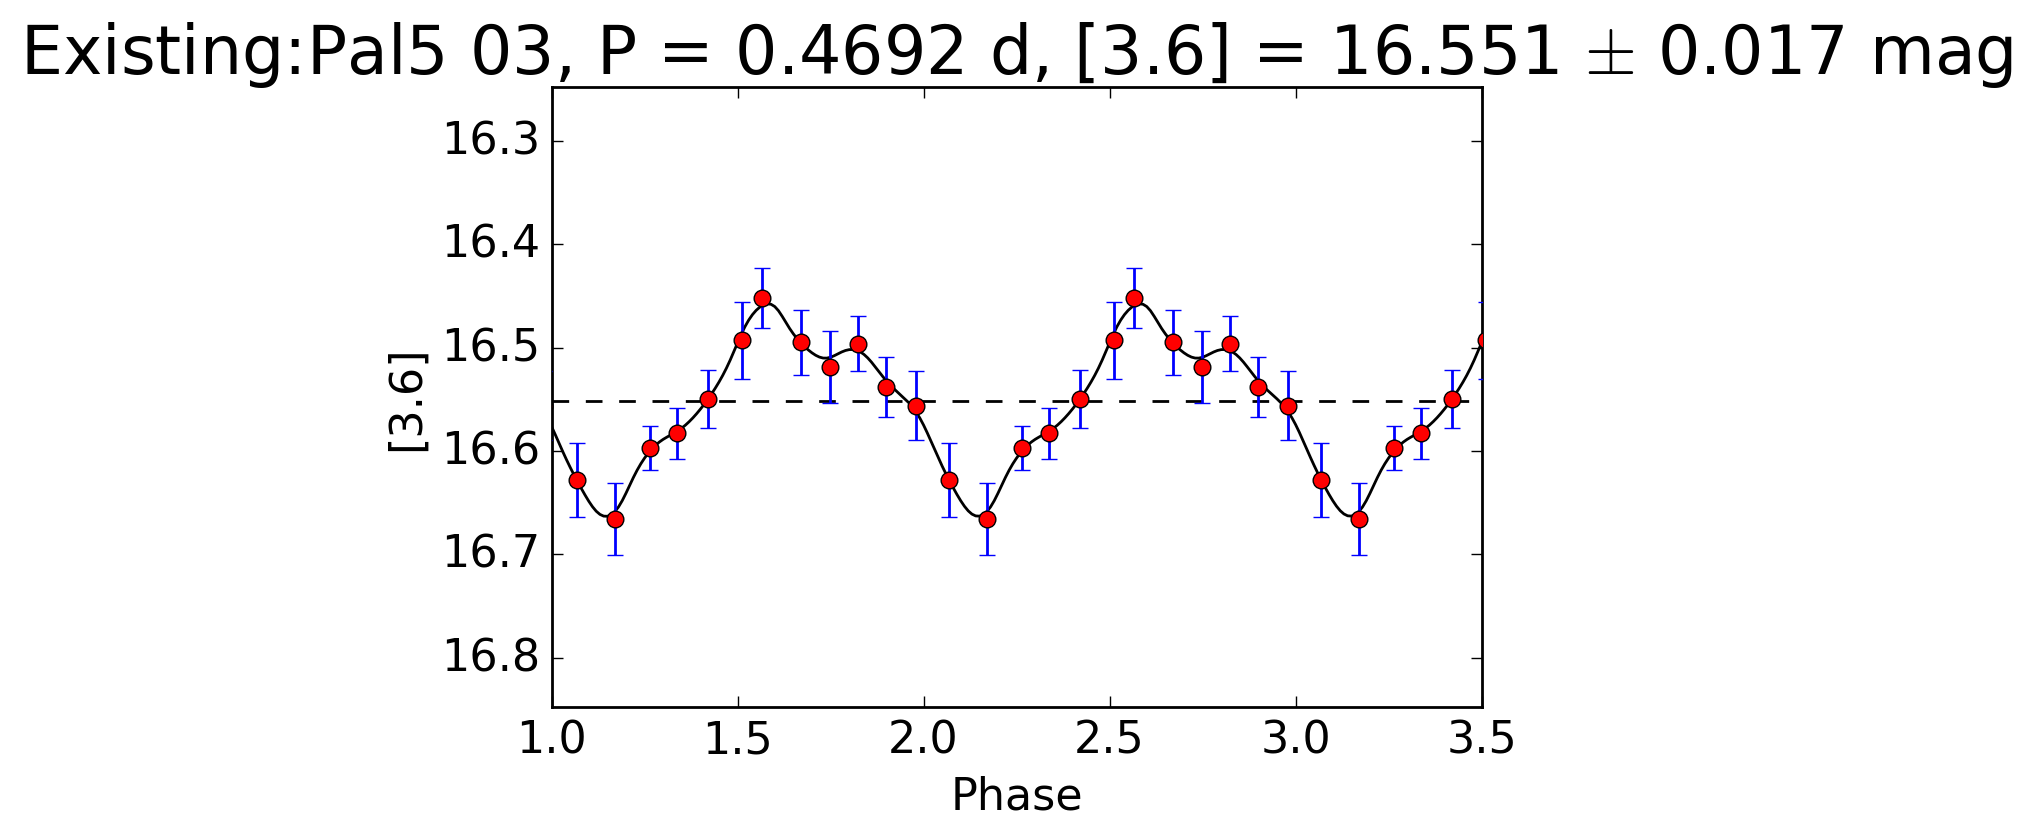

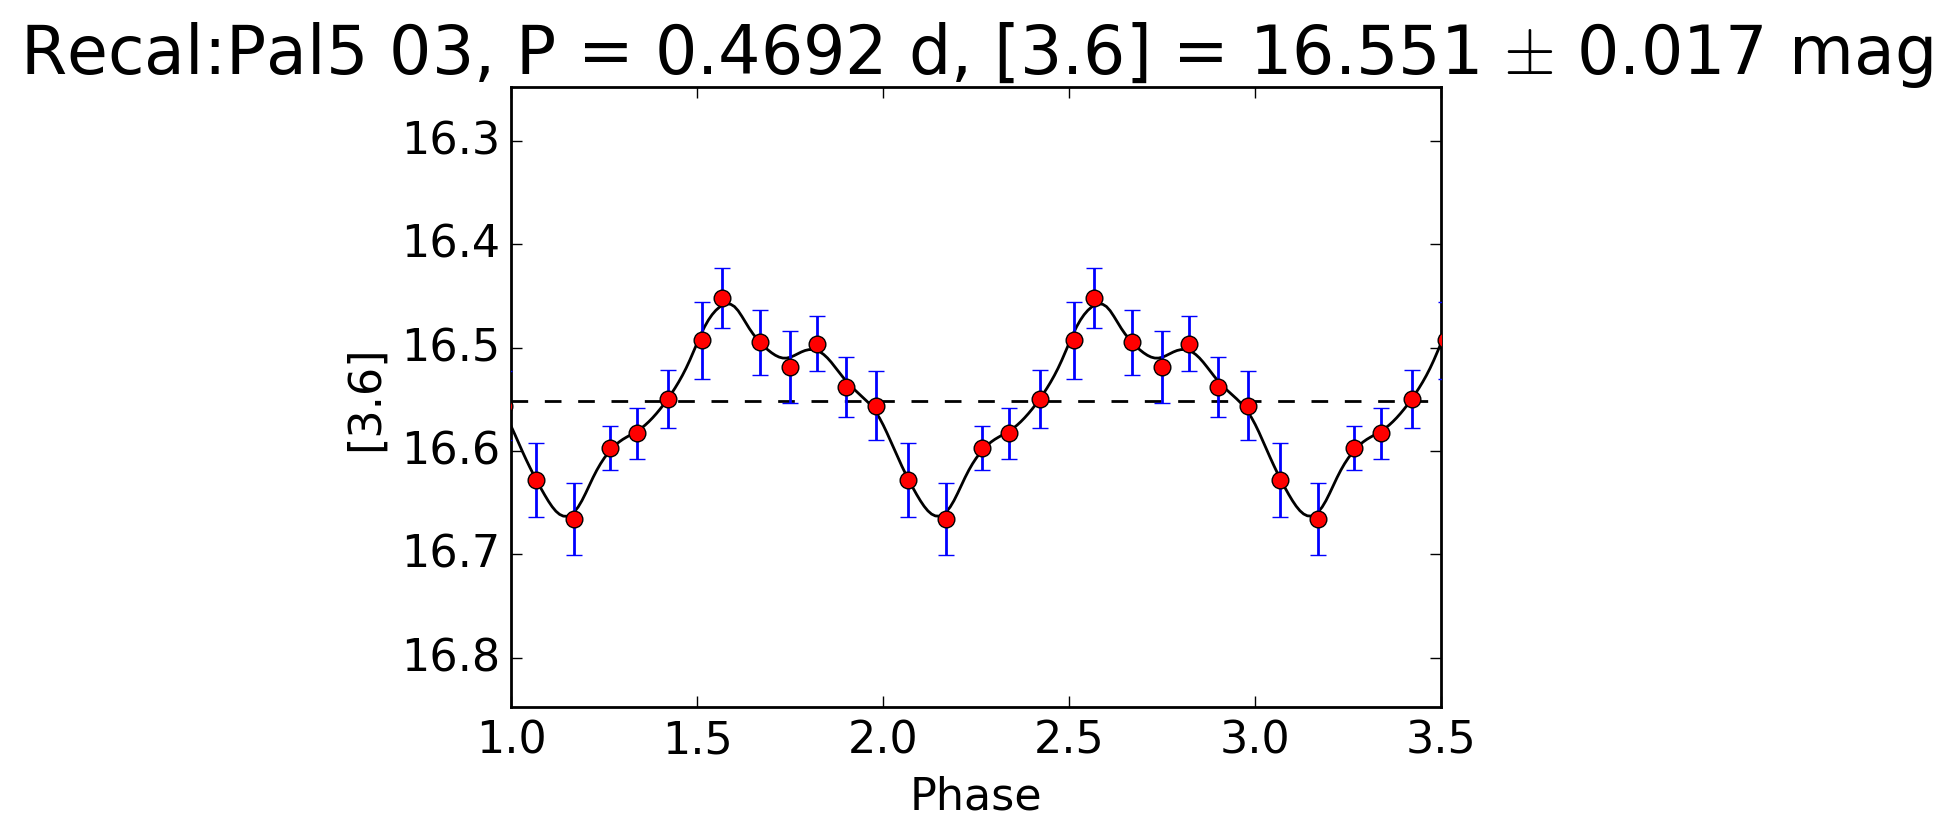

0

In [162]:
qa_code.calibrate_and_plot(target_list_reindexed.head(1))

In [107]:
targets

survey_ident    period    vmag          ra      dec target_name
0  CSS_J144258.2-090616  0.469196  17.254  220.742645 -9.10447     Pal5_03

In [109]:
targets.ix[0,'survey_ident']

'CSS_J144258.2-090616'

In [147]:
os.getcwd()

'/Users/vs522/Dropbox/TRACCS/TRACCS_Output/CSS_J144258_2090616/CSS_J144258_2090616_3p6um'